In [4]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields
import itertools
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

In [6]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [7]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [8]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str
with Timer('child_utils'): from child_frames import *
with Timer('model_utils'): from model_utils import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000045
utils ... done 0:00:00.030547
child_utils ... done 0:00:10.237032
child_utils ... done 0:00:00.018600
model_utils ... done 0:00:18.567470
weight_analysis ... done 0:00:00.019194


In [9]:
torch.set_grad_enabled(False);

In [10]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [11]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu']#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:09:40.277966


In [597]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[2].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time, there was a tribe of smart, resourceful people.

This tribe lived in a land


In [10]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'][1:] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [12]:
model_name = gpt_model_names[0]
model, tokenizer = models[model_name]
unify(model)
if model_name == 'EleutherAI/gpt-neox-20b/' and model_name + '/cpu' in models:
    unify(models[model_name + '/cpu'][0])

blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
attn0 = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

In [91]:
we = model.transformer.wte.weight.data
wu = model.lm_head.weight.data

es = [we]
for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
model.es = es
weBTAs = [es[i].T @ es[i] for i in range(2)]
model.weBTAs = weBTAs

In [13]:
_girls = [name for name in girls if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = [name for name in boys if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = sample(_boys, len(_girls))
def persons(): return _boys + _girls

In [ ]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; N = Negation, l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']
# NE types: boy girl planet letter number month day
# TreeSet(name_genders), TreeSet(name_prons), # resolve iu in speech,  item[0]
# BijectSet(place_landmarks), BijectSet(sport_players) # count, item[1]

In [14]:
def ith_gen(rels, cxt_len=3):
    hop = 0; cxt = sample(rels[hop][0].codom(), cxt_len)
    query, candidates, ans = None, (cxt, cxt), cxt[1]
    return cxt, query, candidates, ans

In [225]:
intermediary_heads = [(8, 1), (12, 10), (13, 13)]
circuit_ends = {
    'thing->type': ([(15, 8), (21, 5)], [(5, 12), (7, 2)]),
    'thing->capability': ([(13, 15)], [(6, 5), (3, 7), (5, 12)]),
    'capital->country': ([(19, 12)], [(5, 12)]), # inverse 3-7 by nrk 
    'fr->en': ([(16, 15), (21, 14)], [(5, 12)]),
    'opposite': ([(16, 14)], [(7, 9)]),
    'copy': ([(16, 7)], [(8, 7), (6, 2)]), # (1, 7), (3, 12), (6, 10)
    # did->does 6-2
}

In [223]:
predicting_heads, relating_heads = defaultdict(list), defaultdict(list)
for taskname, (pred_heads, rel_heads) in circuit_ends.items():
    for pred_head in pred_heads: predicting_heads[pred_head].append(taskname)
    for rel_head in rel_heads: relating_heads[rel_head].append(taskname)

In [1062]:
for block in blocks: remove_composed_heads(block.attn)
blocks[4].attn.composed_heads = [((4, 8), (4, 6))]; blocks[4].attn.ranges_i = ['ans]->*']  # opposite
blocks[6].attn.composed_heads = [((7, 9), (6, 2))]; blocks[6].attn.ranges_i = ['ans]->*']  # opposite
# blocks[8].attn.composed_heads = [((7, 2), (8, 7))]
# blocks[6].attn.composed_heads = [((7, 2), (6, 2))]
# blocks[4].attn.composed_heads = [((3, 12), (4, 8))]
# blocks[3].attn.composed_heads = [((3, 12), (3, 6))]
# blocks[11].attn.composed_heads = [('bos->query]', (11, 12))]
for block in blocks:
    if getattr(block.attn, 'composed_heads', None) is not None:
        compose_heads(model, block.attn, block.attn.composed_heads)

In [490]:
for block in blocks: remove_composed_heads(block.attn)

In [ ]:
for circuit in product(relating_heads, intermediary_heads[:2], predicting_heads):
    eigv_pos = plot_eigv(weightprod(model, list(circuit), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False)[0]
    print(circuit, eigv_pos)

In [1014]:
tasks = [
    # (lambda: [[EqSet(uppercase).equal], ], ith_gen, partial(_cxt2str, sep=' '), lambda q, _: '', 'Ġ->'), 
    # (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], g2c(MlM_gen),
    #     partial(_cxt2str, sep='. ', item2str=lambda item, vocab: f"The {item[0]} is {item[1]}'s"),
    #     # lambda query, vocab: f'So does the {query[0]} belong to {query[1]}',
    #     lambda query, vocab: f'{query[0]} {query[1]}'#f"So is the {query[0]} {query[1]}'s",
    # ), 
    # (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], MlM_gen,
    #  # partial(_cxt2str, prefix='There are ', item2str=lambda i, _: f"{i[1]}'s {i[0]}"), lambda q, _: f"So whose {q}", '?' # worse 
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f"The {i[0]} is {i[1]}'s"), lambda q, _: f'So the {q} belongs', 'Ġto'
    # ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    # (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MNlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f"No, it is {q}", "'s"
    # ),
    # (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')], MlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} has {wrap_noun(i[1])}"), lambda q, _: f'{q}', "'s"
    # ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'{conj()}{q}{xxx_be()}', "" #" is"
    ),
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('opposite')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'{conj()}{q}{xxx_be()}', "" #" is"
    ),
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('equal')], MNlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'No, {q}', " is"
    ), # c << g. cxt_len=3->2, gpt-j/neox better, davinci-001/002 worse!?
    (lambda: [EqSet(persons).use('equal'), SymSet(person_adjs).use('opposite')], MlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f"So {q} is", " not"
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} {i[1]}"), lambda q, _: f"So {q}", " not"
    ), # t: 16-14, somewhat 14-7
    # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [[SymSet(person_adjs).equal], [EqSet(persons).equal]], MlM_gen,
#      partial(cxt2str, item2str=lambda i, _: f'{i[1]} is {i[0]}'), lambda q, _: f'So who is {}', '?'
#     ),  # gpt-neox good
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], g2c(IlMlI_gen),
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
# #         lambda query, vocab: f'{query[0]} and {query[1]} are same?'
# #     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], lMlI_gen,
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} is {item[1]}'),
# #         lambda query, vocab: f'{query} is the same as', # bare query is better for gpt-neox!?
# #     ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(country2capital).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', ' from'
    ), # t: 19-12 >> 16-10 = 12-7
    # (lambda: [[EqSet(persons).equal], [BijectSet(city2resident).proj]], MlM_gen,
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q}', 'Ġis'
    # ), # a little worse than capital -> country
    (lambda: [EqSet(persons).use('equal'), TreeSet(capabilities_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(capabilities_of_things).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', ' can'
    ),  # t: 13-15, not very strong
    (lambda: [EqSet(persons).use('equal'), TreeSet(does2did).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} {i[1]}'), lambda q, _: f'{q}', ' usually'
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(does2did).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} {i[1]}'), lambda q, _: f'{q}', ' usually'
    ), # t: copy ov 16-7 + mlp. best performance among all tasks by all models. abstract > verbose
    (lambda: [EqSet(persons).use('equal'), TreeSet(en2fr).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} a {i[1]}'), lambda q, _: f'{q}', "'s"
    ), # t: good translate ov 16-15, 21-14!
]

In [874]:
results = {}; key = None

In [216]:
def result2dict(result): return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}
with gzip.open(f'results_fr2en.pkl.gz', 'wb') as f: pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

In [1074]:
nrows, k_shot = 12, 5; save_results = True
for task, cxt_len, abstract, do_g2c in tqdm(list(itertools.product(tasks[2:3], [3], [0, ], [False, ]))):
    # seed(42)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    if do_g2c: args['do_g2c'] = do_g2c
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})" + '_4-6qk->4-8_6-2qk->7-9'
    if 'equal' in str(task[0]()[1]) and cxt_len == 1: continue
    # if 'MNlM_gen' not in res_key: continue
    # if save_results and key is not None and res_key != key: continue
    if save_results and res_key in results:
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        batch_size = 6; verbose = not save_results or batch_size <= 6
        if verbose: print(f'===== {res_key} =====')
        all_examples, texts, all_bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
        result = Result(task, args, all_examples, texts)

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens, verbose=verbose)
            for text, examples, bos_tokens in zip(texts, all_examples, all_bos_tokens)
            if True or any(s in text[24:] for s in ['dangerous'])])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        if verbose: print(result.mean_loss, result.mean_acc)
        if save_results: results[res_key] = result
    if not save_results: continue

    for node_name in ['node']:
        node = getattr(result, node_name, None)
        if node is None:
            node = result.node = result.root = add_node(node, label_type=node_name.replace('node', 'labels'))
        node.data.attr = mr(attribute_step)(data_tuples[:], model, node)
    node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
        for ap in attn_patterns_by_step.get(node.data.step, [])} if 'g2c' not in res_key else None

100%|██████████| 1/1 [00:21<00:00, 21.55s/it]


In [ ]:
attrs = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot).exp() for ap in ['bos->ans0]', 'bos->query]']}
show_all_composed_heads(model); print(attrs['bos->ans0]'][16, 7], attrs['bos->ans0]'][16, 0], attrs['bos->query]'][11, 12])

### person_adjs.opposite

In [668]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0): 0.694, 0.7380952380952381
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0): 0.488, 0.8809523809523809
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0): 3.765, 0.16666666666666666


In [1077]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0): 0.892, 0.7142857142857143
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0): 3.309, 0.2857142857142857
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8: 3.436, 0.21428571428571427
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9: 3.461, 0.23809523809523808


Ocean has a pear. Rex has pink. Ocean's pear
Denver has a mouse. Fox has a donkey. Fox's donkey
Jamie has spaghetti. Justin has a gun. Jamie's spaghetti
                 ┌[0] top[0] 16-0 attn_labels┐
                 │                           └[1] top[0, 1, 2, 3] 13-2,11-12,12-10,8-1
                 ├[0] top[2] 13-2 attn_labels┐
                 │                           └[1] top[0, 1] 8-1,12-10
                 ├[0] top[0, 1] 16-0,16-7 attn_labels┐
                 │                                   └[1] top[0, 1, 2, 3, 4, 5, 6] 11-12,13-2,12-10,9-14,9-5,13-13,14-9
 [-1] root labels┤
                 │                           ┌[1] top[0, 1, 2, 3, 4] 11-12,9-14,12-10,14-9,9-5
                 ├[0] top[1] 16-7 attn_labels┤
                 │                           └[1] top[0] 11-12 attn_labels┐
                 │                                                        │              ┌[3] top[0, 1] 7-mlp,4-6
                 │                                                    

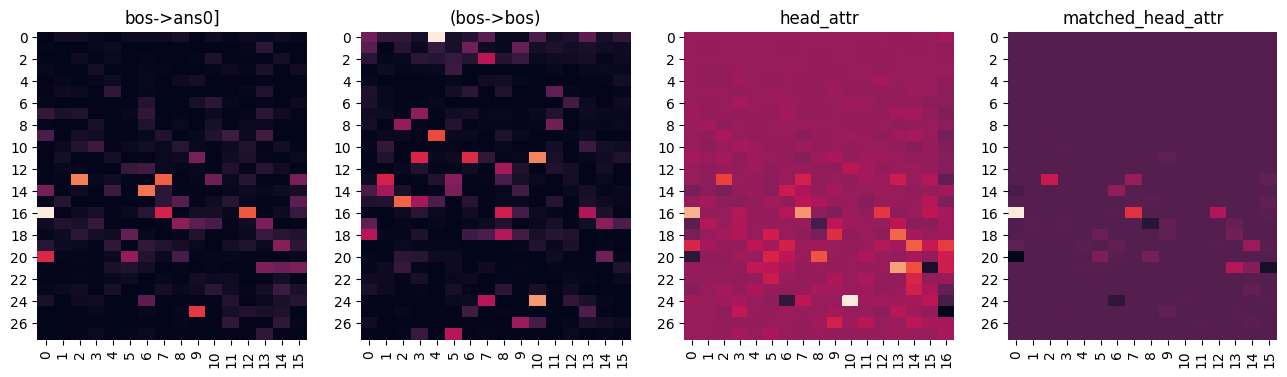

(array([16, 13, 14, 13, 16, 25, 20, 16, 20, 17]),
 array([ 0,  2,  6,  7, 12,  9,  0,  7,  5,  8]),
 array([0.50678074, 0.3719883 , 0.35892892, 0.33758184, 0.32886   ,
       0.2961244 , 0.2738683 , 0.26737428, 0.18921608, 0.18215941],
      dtype=float32))
(array([ 0, 24, 11, 15,  9, 11, 11, 13, 16,  2]),
 array([ 4, 10, 10,  2,  4,  6,  3,  1,  8,  7]),
 array([0.8188795 , 0.64647615, 0.6122394 , 0.55236304, 0.5057288 ,
       0.45408982, 0.43920258, 0.4314535 , 0.42517146, 0.37679413],
      dtype=float32))
(array([24, 16, 21, 16, 18, 19, 20, 21, 13, 19]),
 array([10,  0, 13,  7, 13, 14,  8, 14,  2, 16]),
 array([1.0957923 , 0.8426378 , 0.76649755, 0.7118449 , 0.53413117,
       0.5125741 , 0.46596137, 0.44534913, 0.4068646 , 0.380725  ],
      dtype=float32))
(array([16, 16, 13, 21, 16, 19, 13, 14, 21, 20]),
 array([ 0,  7,  2, 13, 12, 14,  7,  6, 14,  5]),
 array([0.4270326 , 0.19032902, 0.15134887, 0.12002318, 0.11762251,
       0.08758744, 0.08658092, 0.07721887, 0.06208498, 0.0

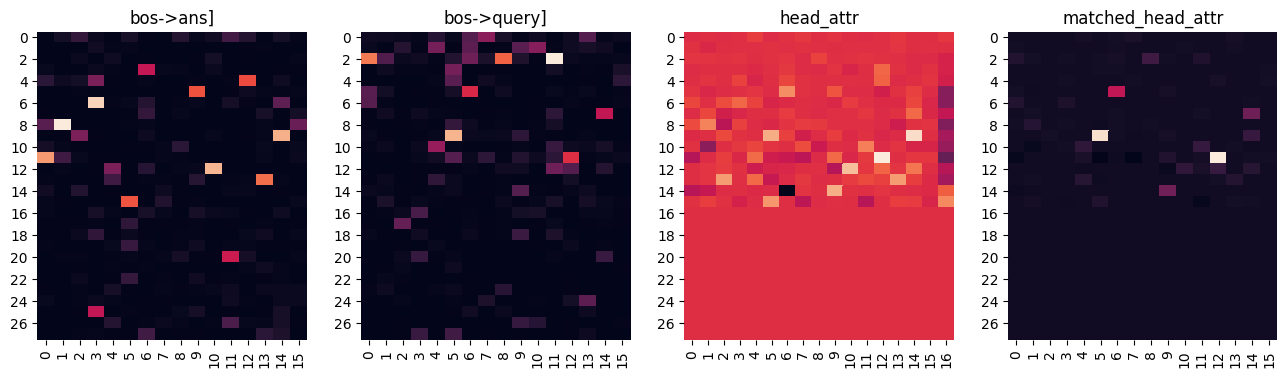

(array([ 8,  6, 12,  9, 11, 13, 15,  5,  4, 20]),
 array([ 1,  3, 10, 14,  0, 13,  5,  9, 12, 11]),
 array([0.07315122, 0.06863852, 0.06287291, 0.06196965, 0.05804516,
       0.05093372, 0.04700983, 0.04668443, 0.0456173 , 0.03660797],
      dtype=float32))
(array([ 2,  9,  2,  2, 11,  5,  7, 10,  0,  1]),
 array([11,  5,  0,  8, 12,  6, 14,  4,  7, 10]),
 array([0.9485045 , 0.81189495, 0.68293536, 0.6343936 , 0.53189635,
       0.51569563, 0.453461  , 0.35773623, 0.3289512 , 0.31980318],
      dtype=float32))
(array([11,  9, 12, 14,  9, 13, 13, 15,  5, 15]),
 array([12, 14, 10,  9,  5,  2, 13,  5,  6, 16]),
 array([0.81890506, 0.7492981 , 0.59458655, 0.5236171 , 0.51950836,
       0.446353  , 0.44299427, 0.41019282, 0.37815368, 0.35901353],
      dtype=float32))
(array([11,  9,  5, 14,  7,  2,  9, 10, 12, 12]),
 array([12,  5,  6,  9, 14,  8, 14, 11, 12, 10]),
 array([0.43557262, 0.42178622, 0.1950122 , 0.11036788, 0.10614577,
       0.0555643 , 0.04643374, 0.04386143, 0.04363906, 0.0

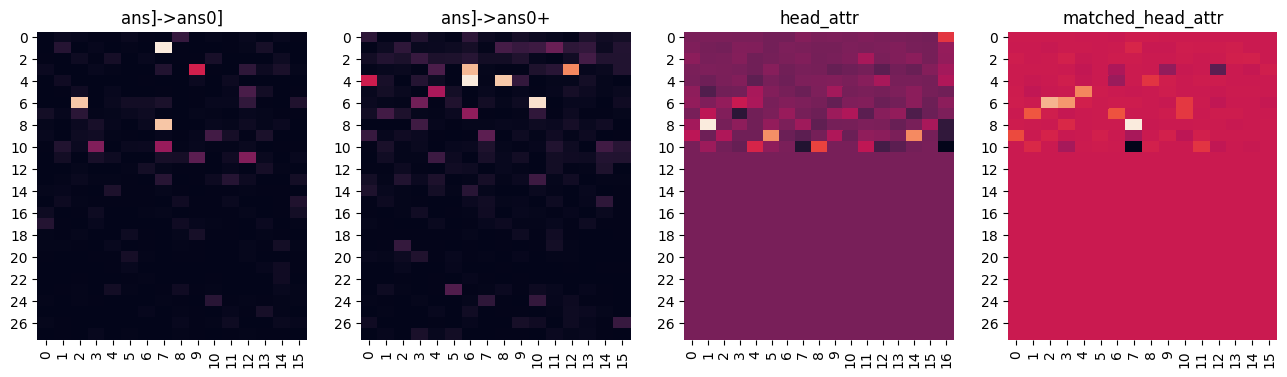

(array([ 1,  6,  8,  3, 10, 11, 10, 11,  5,  9]),
 array([ 7,  2,  7,  9,  7, 12,  3,  9, 12, 10]),
 array([0.88620716, 0.8000733 , 0.79810345, 0.45711425, 0.33615005,
       0.28795952, 0.2877815 , 0.2102443 , 0.17099653, 0.154066  ],
      dtype=float32))
(array([4, 6, 4, 3, 3, 4, 5, 7, 6, 1]),
 array([ 6, 10,  8,  6, 12,  0,  4,  6,  3, 11]),
 array([0.7711697 , 0.74834996, 0.70095575, 0.6696099 , 0.5797186 ,
       0.38864923, 0.32399455, 0.27782542, 0.22153145, 0.20865496],
      dtype=float32))
(array([ 8,  9,  9, 10,  0, 10,  6, 10,  7,  9]),
 array([ 1,  5, 14,  8, 16,  4,  3, 11,  1,  0]),
 array([0.7344241 , 0.4890677 , 0.4773428 , 0.32082194, 0.2900124 ,
       0.2391572 , 0.19812061, 0.17242157, 0.16971318, 0.16741759],
      dtype=float32))
(array([ 8,  6,  6,  5,  7,  7,  9,  7,  6, 10]),
 array([ 7,  2,  3,  4,  1,  6,  0, 10, 10, 11]),
 array([0.07683924, 0.05469965, 0.04388995, 0.03815788, 0.02287656,
       0.02147169, 0.018815  , 0.0132543 , 0.01282978, 0.01179318],


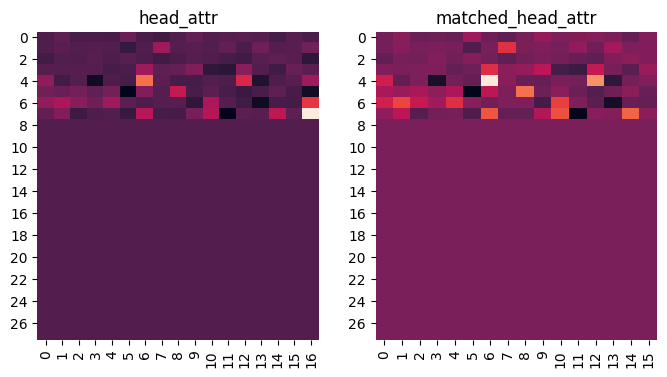

(array([7, 4, 6, 4, 5, 7, 7, 7, 6, 6]),
 array([16,  6, 16, 12,  8, 14,  6, 10,  1, 10]),
 array([0.7097077 , 0.43756548, 0.32889578, 0.29505107, 0.24721484,
       0.23116033, 0.21255623, 0.20642126, 0.1923367 , 0.18380749],
      dtype=float32))
(array([4, 4, 5, 7, 7, 7, 6, 6, 1, 6]),
 array([ 6, 12,  8, 14,  6, 10,  1, 10,  7,  4]),
 array([0.43756548, 0.29505107, 0.24721484, 0.23116033, 0.21255623,
       0.20642126, 0.1923367 , 0.18380749, 0.16341598, 0.16051959],
      dtype=float32))
[3] top[1] 4-6


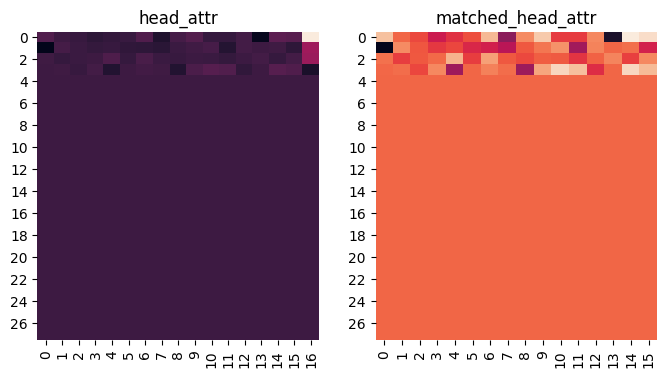

(array([0, 1, 2, 0, 0, 3, 3, 0, 0, 3]),
 array([16, 16, 16, 14, 15, 14, 10,  9,  0, 11]),
 array([2.0157855 , 0.56562185, 0.54043317, 0.18445623, 0.16308679,
       0.1544164 , 0.15107267, 0.13377215, 0.12110753, 0.1190377 ],
      dtype=float32))
(array([0, 0, 3, 3, 0, 0, 3, 3, 0, 2]),
 array([14, 15, 14, 10,  9,  0, 11, 15,  6,  4]),
 array([0.18445623, 0.16308679, 0.1544164 , 0.15107267, 0.13377215,
       0.12110753, 0.1190377 , 0.11157902, 0.11039036, 0.10046551],
      dtype=float32))


In [812]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[1], head_attr_fn=get_head_mlp_attr, attn_patterns=['ans]->ans0+'], k_shot=k_shot, mix=False)  # 

In [810]:
print(key); node = result.node = add_node(node, topi=[1], head_attr_fn=get_head_mlp_attr)#, label_type='attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-0 attn_labels┐
                 │                           └[1] top[0, 1, 2, 3] 13-2,11-12,12-10,8-1
                 ├[0] top[2] 13-2 attn_labels┐
                 │                           └[1] top[0, 1] 8-1,12-10
                 ├[0] top[0, 1] 16-0,16-7 attn_labels┐
                 │                                   └[1] top[0, 1, 2, 3, 4, 5, 6] 11-12,13-2,12-10,9-14,9-5,13-13,14-9
 [-1] root labels┤
                 │                           ┌[1] top[0, 1, 2, 3, 4] 11-12,9-14,12-10,14-9,9-5
                 ├[0] top[1] 16-7 attn_labels┤
                 │                           └[1] top[0] 11-12 attn_labels┐
                 │                                                        │              ┌[3] top[0, 1] 7-mlp,4-6
                 │                                                        │              ├*[3] top[1] 4-6...
                 │            

Max's unfriendly. Connor's rational. Ben's honest. Therefore, Connor may be irrational
Ocean's sick. Anna's white. Davis's ugly. Therefore, Anna, anyhow, is black
Jamie's female. Davis's loud. Winter's irrational. Therefore, Jamie should be male
                 ┌[0] top[0] 16-14 argmax_attn_labels
 [-1] root labels┤
                 └[0] 11-12 argmax_attn_labels┐
                                              └*[1] top[3] 8-1
[-1] root labels


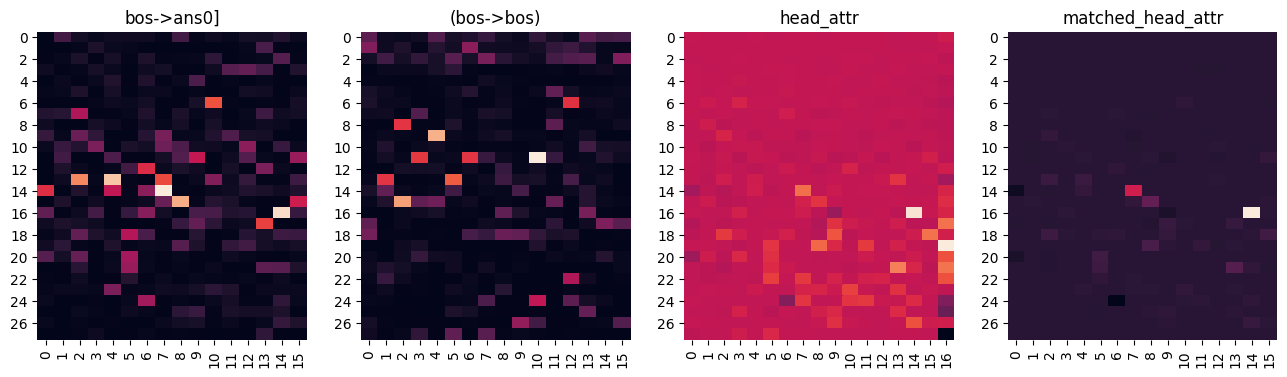

(array([14, 16, 13, 15, 13,  6, 13, 17, 14, 12]),
 array([ 7, 14,  4,  8,  2, 10,  7, 13,  0,  6]),
 array([0.20824544, 0.20042302, 0.18754974, 0.1749161 , 0.15661994,
       0.13327155, 0.12881634, 0.1245396 , 0.11698152, 0.1148847 ],
      dtype=float32))
(array([11,  9, 15, 13, 11,  8, 13, 11,  6, 24]),
 array([10,  4,  2,  5,  3,  2,  1,  6, 12, 10]),
 array([0.6395771 , 0.5431045 , 0.5152238 , 0.42205158, 0.3726969 ,
       0.36938503, 0.36835915, 0.3676792 , 0.36454272, 0.3042197 ],
      dtype=float32))
(array([19, 16, 21, 21, 18, 17, 14, 19, 18, 22]),
 array([16, 14, 13, 16, 15, 16,  7,  8,  9, 16]),
 array([0.7804427 , 0.74966913, 0.3825424 , 0.3422043 , 0.33574137,
       0.33515683, 0.3302865 , 0.30748007, 0.24915259, 0.23534441],
      dtype=float32))
(array([16, 14, 15, 21, 19, 20, 18, 21, 18, 13]),
 array([14,  7,  8, 13,  8,  5, 15,  5,  2,  4]),
 array([0.15025096, 0.06878066, 0.02525365, 0.01906339, 0.01434409,
       0.01102288, 0.01056057, 0.008725  , 0.00866908, 0.0

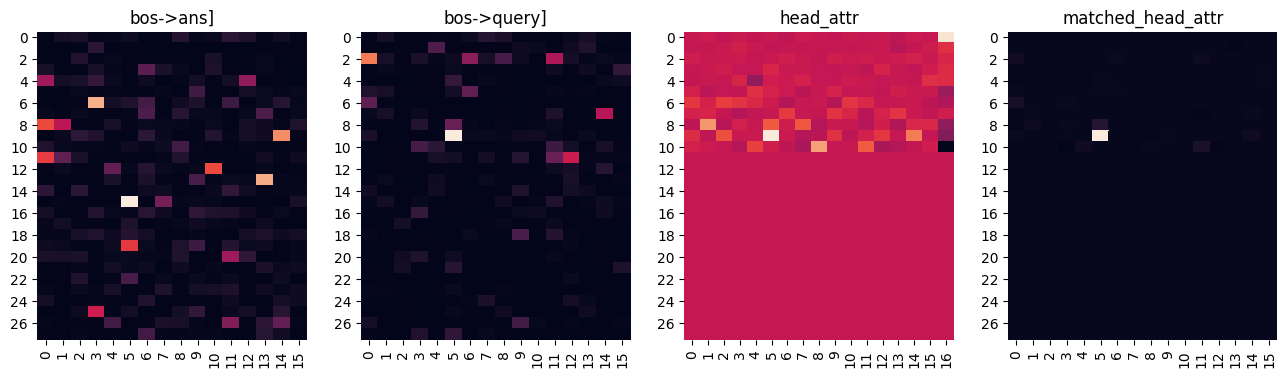

(array([15,  6, 13,  9, 12,  8, 11, 19, 25,  8]),
 array([ 5,  3, 13, 14, 10,  0,  0,  5,  3,  1]),
 array([0.05664116, 0.04813514, 0.04739175, 0.04316704, 0.03524441,
       0.03497791, 0.03347453, 0.03301175, 0.02862386, 0.02618447],
      dtype=float32))
(array([ 9,  2, 11,  7,  2,  2, 11,  8,  5,  6]),
 array([ 5,  0, 12, 14, 11,  6, 11,  5,  6,  0]),
 array([0.8163865 , 0.5899938 , 0.410708  , 0.37240934, 0.3514485 ,
       0.28799117, 0.21767905, 0.21722631, 0.20371866, 0.20037307],
      dtype=float32))
(array([ 9,  0, 10,  8,  9, 10,  8,  8,  9, 10]),
 array([ 5, 16,  8,  1, 14, 11,  5,  7,  2,  4]),
 array([55.870266, 53.59444 , 34.959003, 32.488705, 25.666319, 18.54064 ,
       18.131052, 17.496826, 15.519081, 12.162555], dtype=float32))
(array([ 9,  8, 10,  6,  2, 10,  9,  8,  2,  2]),
 array([ 5,  5, 11,  0,  0,  4, 14,  1, 11,  6]),
 array([45.611732  ,  3.9385417 ,  2.402478  ,  2.04972   ,  1.3407472 ,
        1.1114479 ,  1.107939  ,  0.8506994 ,  0.7435963 ,  0.6342699

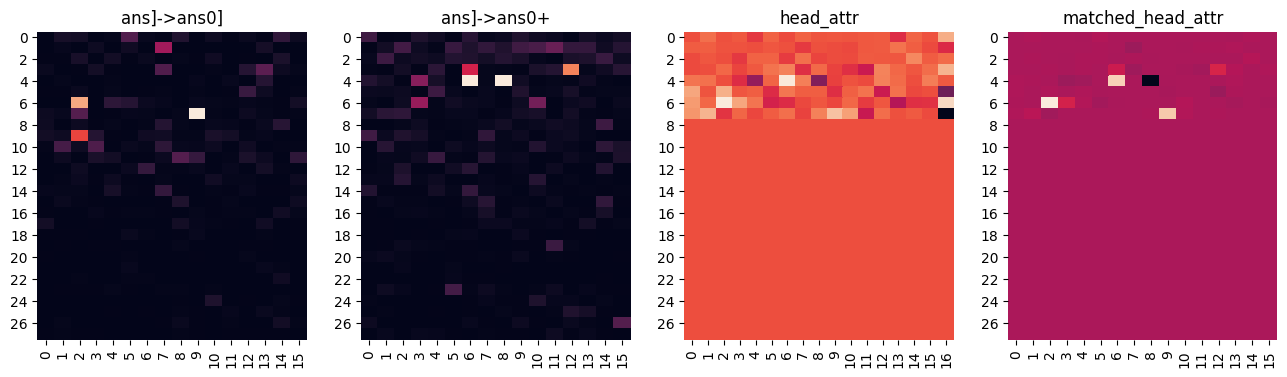

(array([ 7,  6,  9,  1,  3,  7, 11,  0,  3, 10]),
 array([ 9,  2,  2,  7, 13,  2,  8,  5,  7,  3]),
 array([0.5856456 , 0.48536706, 0.3580531 , 0.2348318 , 0.1377378 ,
       0.12990771, 0.12979455, 0.12525642, 0.12249539, 0.11907802],
      dtype=float32))
(array([ 4,  4,  3,  3,  6,  4,  6,  1, 26,  1]),
 array([ 8,  6, 12,  6,  3,  3, 10, 11, 15, 10]),
 array([0.43360743, 0.43360743, 0.32156208, 0.22797388, 0.16421   ,
       0.14659311, 0.12736218, 0.11556234, 0.0936593 , 0.08366342],
      dtype=float32))
(array([6, 4, 6, 7, 7, 3, 5, 0, 5, 6]),
 array([ 2,  6, 16,  9,  1, 16,  2, 16,  0,  3]),
 array([29.993317, 29.546144, 26.000221, 21.089344, 18.489653, 18.203466,
       17.439472, 17.145178, 15.609294, 15.505066], dtype=float32))
(array([6, 4, 7, 3, 6, 3, 7, 2, 3, 6]),
 array([ 2,  6,  9, 12,  3,  6,  1, 14, 13, 10]),
 array([14.557768  , 12.811428  , 12.350882  ,  2.7963111 ,  2.546087  ,
        1.9497676 ,  0.907304  ,  0.6314964 ,  0.53702587,  0.50895995],
      dtype=floa

In [1075]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [1069]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [1076]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9
                 ┌[0] top[0] 16-14 argmax_attn_labels
 [-1] root labels┤
                 └[0] 11-12 argmax_attn_labels┐
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1, 2, 3] 6-2,4-6,6-mlp,7-9...


Maria's tall. Chance's small. James's fat. So James must be thin
Ocean's popular. Eva's ignorant. Cole's asleep. Cole is awake
Anna's big. Amy's popular. Ford's rich. So Anna, anyhow, is small
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0] 8-1┐
                 │                                                  └[2] top[0] 7-9
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3, 4] 9-5,0-mlp,10-8,8-1,9-14
                 └[0] 11-12 argmax_attn_labels┤
                                              └*[1] top[3] 8-1
[-1] root labels


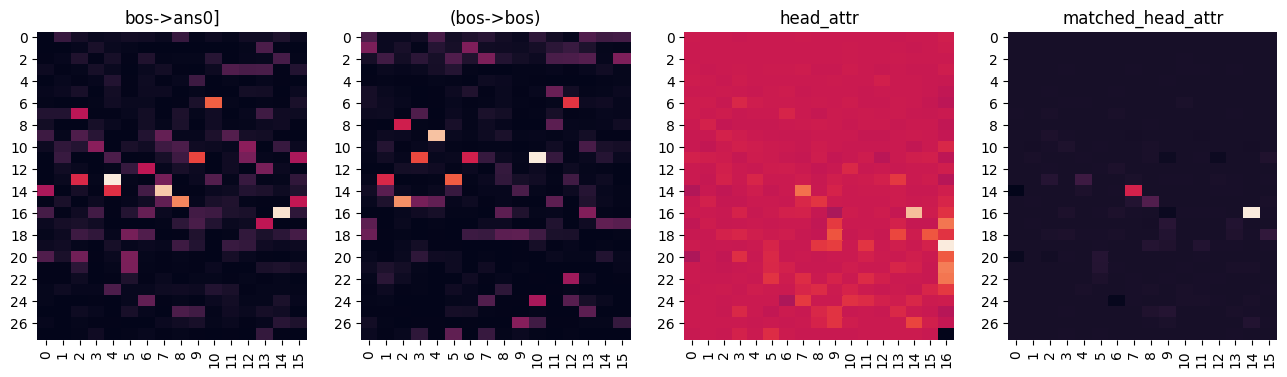

(array([13, 16, 14, 15,  6, 11, 14, 13, 15, 17]),
 array([ 4, 14,  7,  8, 10,  9,  4,  2, 15, 13]),
 array([0.22264607, 0.21675868, 0.20187375, 0.16625838, 0.14811732,
       0.13642725, 0.12535676, 0.12126677, 0.10648211, 0.10496186],
      dtype=float32))
(array([11,  9, 15, 13, 11,  6, 13, 11,  8, 24]),
 array([10,  4,  2,  5,  3, 12,  1,  6,  2, 10]),
 array([0.688087  , 0.6153098 , 0.53001374, 0.45274708, 0.42551735,
       0.39567447, 0.37348667, 0.35554954, 0.35297215, 0.28674328],
      dtype=float32))
(array([19, 16, 21, 17, 22, 14, 20, 18, 18, 18]),
 array([16, 14, 16, 16, 16,  7, 16, 15,  9, 13]),
 array([0.9022522 , 0.690594  , 0.41560623, 0.3885763 , 0.38366738,
       0.36577043, 0.2784512 , 0.26661554, 0.26054785, 0.21196164],
      dtype=float32))
(array([16, 14, 15, 13, 18, 17, 13, 20, 19, 21]),
 array([14,  7,  8,  4, 15,  9,  2,  5,  8,  5]),
 array([0.14969225, 0.07383945, 0.02383028, 0.01570599, 0.01073586,
       0.00702333, 0.0062104 , 0.00590632, 0.0055096 , 0.0

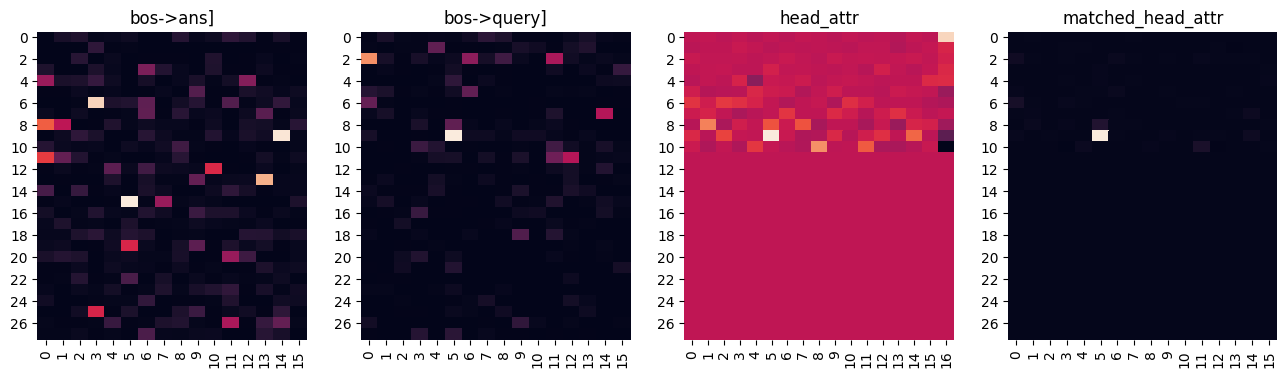

(array([15,  9,  6, 13,  8, 11, 12, 19, 25,  8]),
 array([ 5, 14,  3, 13,  0,  0, 10,  5,  3,  1]),
 array([0.05010605, 0.0493435 , 0.04708727, 0.04254458, 0.03309478,
       0.02969296, 0.02725989, 0.02696433, 0.02666441, 0.02336149],
      dtype=float32))
(array([ 9,  2, 11,  7,  2,  2, 11,  6,  5,  8]),
 array([ 5,  0, 12, 14, 11,  6, 11,  0,  6,  5]),
 array([0.79701614, 0.61389613, 0.35320947, 0.35202956, 0.33495912,
       0.28028968, 0.22637649, 0.20837824, 0.20115303, 0.19822793],
      dtype=float32))
(array([ 9,  0, 10,  8,  9, 10,  8,  8,  9,  6]),
 array([ 5, 16,  8,  1, 14, 11,  7,  5,  2,  2]),
 array([55.39738 , 49.616943, 31.632116, 27.808489, 21.774178, 19.165083,
       17.635012, 17.490614, 14.312903, 11.825717], dtype=float32))
(array([ 9,  8, 10,  6,  2,  9,  7, 10,  2,  8]),
 array([ 5,  5, 11,  0,  0, 14, 14,  4,  6,  1]),
 array([44.152607  ,  3.467128  ,  2.6155236 ,  2.2038271 ,  1.331198  ,
        1.074414  ,  1.040023  ,  0.837178  ,  0.65109575,  0.6496478

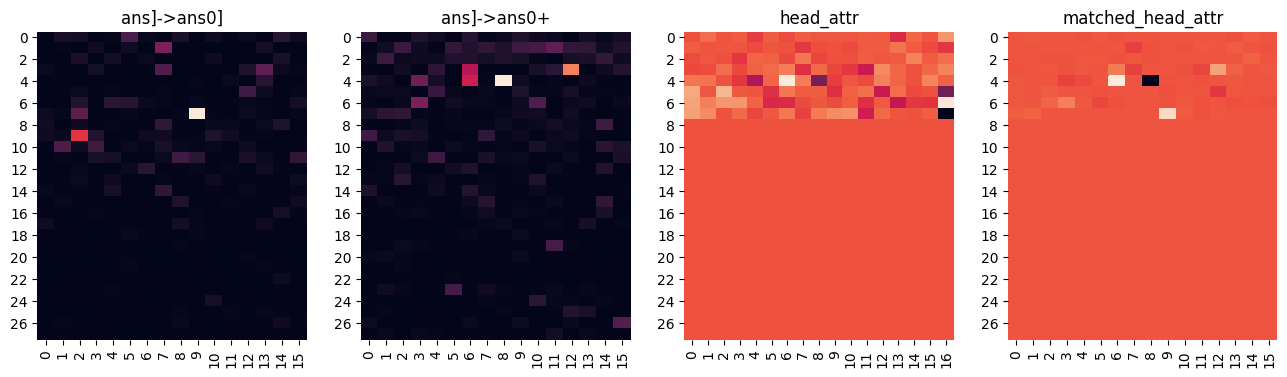

(array([ 7,  9,  1,  3,  7,  3, 10,  0,  5, 10]),
 array([ 9,  2,  7, 13,  2,  7,  1,  5, 12,  3]),
 array([0.6156518 , 0.35236335, 0.19486421, 0.14994635, 0.14852458,
       0.12887928, 0.12490392, 0.12209375, 0.10351754, 0.10279302],
      dtype=float32))
(array([ 4,  3,  4,  3,  6,  4,  1, 26,  6, 23]),
 array([ 8, 12,  6,  6,  3,  3, 11, 15, 10,  5]),
 array([0.4697789 , 0.34520796, 0.23944962, 0.21452254, 0.14928742,
       0.13172652, 0.11744248, 0.10204825, 0.09817006, 0.08559577],
      dtype=float32))
(array([4, 6, 5, 5, 6, 7, 6, 6, 0, 7]),
 array([ 6, 16,  2,  0,  0,  0,  3,  2, 16, 10]),
 array([31.74972  , 30.699425 , 20.102781 , 16.75409  , 15.511513 ,
       14.9631815, 13.159032 , 12.669658 , 12.650295 , 11.741937 ],
      dtype=float32))
(array([4, 7, 3, 6, 3, 6, 7, 2, 3, 7]),
 array([ 6,  9, 12,  3,  6,  2,  1, 14, 13,  0]),
 array([7.6024585 , 6.6880555 , 3.5932333 , 1.9644779 , 1.7549682 ,
       0.70391935, 0.5802615 , 0.539919  , 0.531424  , 0.36514163],
      dtyp

In [1040]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1042]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [1041]:
print(key); node = result.node = add_node(node, topi=[0,1], head_attr_fn=get_head_mlp_attr)#label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0] 8-1┐
                 │                                                  └[2] top[0] 7-9
 [-1] root labels┤
                 │                            ┌[1] top[0, 1, 2, 3, 4] 9-5,0-mlp,10-8,8-1,9-14
                 └[0] 11-12 argmax_attn_labels┤
                                              └[1] top[3] 8-1┐
                                                             └*[2] top[0, 1] 4-6,6-mlp...


Scott's small. Justice's outside. Ford's white. Yes, Justice is outside
Jessica's unpopular. Emily's brave. Miller's dishonest. Miller may be dishonest
Eva's clean. Hunter's friendly. Houston's male. So Hunter, anyhow, is friendly
 [-1] root labels┐
                 │                           ┌[0] top[0] 11-12 attn_labels attr_k┐
                 │                           │                                   └[1] top[0] 0-mlp
                 └[0] top[1] 16-7 attn_labels┤
                                             │                            ┌*[1] top[1] 9-14
                                             └[0] top[0] 11-12 attn_labels┤
                                                                          │              ┌[2] top[0, 1] 4-6,6-2
                                                                          └[1] top[0] 8-1┤
                                                                                         └[2] top[0] 4-6┐
                                            

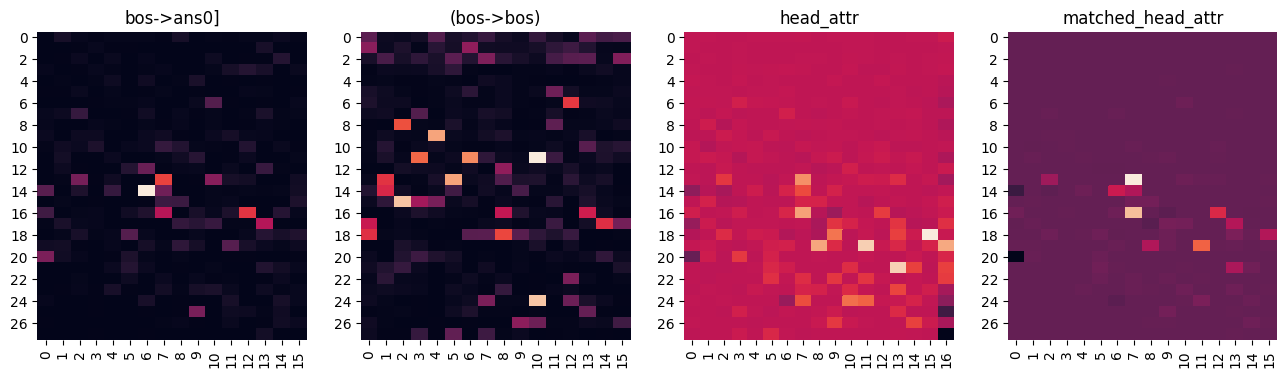

(array([14, 13, 16, 16, 17, 13, 20, 25, 13, 14]),
 array([ 6,  7, 12,  7, 13, 10,  0,  9,  2,  7]),
 array([0.57723653, 0.35018384, 0.33171707, 0.25989714, 0.25609133,
       0.19704944, 0.18054645, 0.17705825, 0.17358647, 0.16592593],
      dtype=float32))
(array([11, 24, 15,  9, 13, 11, 11,  8, 18,  6]),
 array([10, 10,  2,  4,  5,  6,  3,  2,  8, 12]),
 array([0.61781436, 0.5574382 , 0.5543564 , 0.5044085 , 0.5029615 ,
       0.46727133, 0.4209884 , 0.39333877, 0.3801319 , 0.35967335],
      dtype=float32))
(array([18, 21, 19, 19, 19, 16, 13, 18, 24, 24]),
 array([15, 13, 11, 16,  8,  7,  7,  9, 10, 11]),
 array([0.9096529 , 0.78256613, 0.77824384, 0.6187095 , 0.60609144,
       0.5858564 , 0.5188478 , 0.40511808, 0.38800666, 0.34161237],
      dtype=float32))
(array([13, 16, 19, 16, 14, 17, 18, 14, 19, 21]),
 array([ 7,  7, 11, 12,  6, 13, 15,  7,  8, 13]),
 array([0.18169212, 0.1522624 , 0.100751  , 0.06947783, 0.05831077,
       0.04526314, 0.04441185, 0.04304539, 0.04256573, 0.0

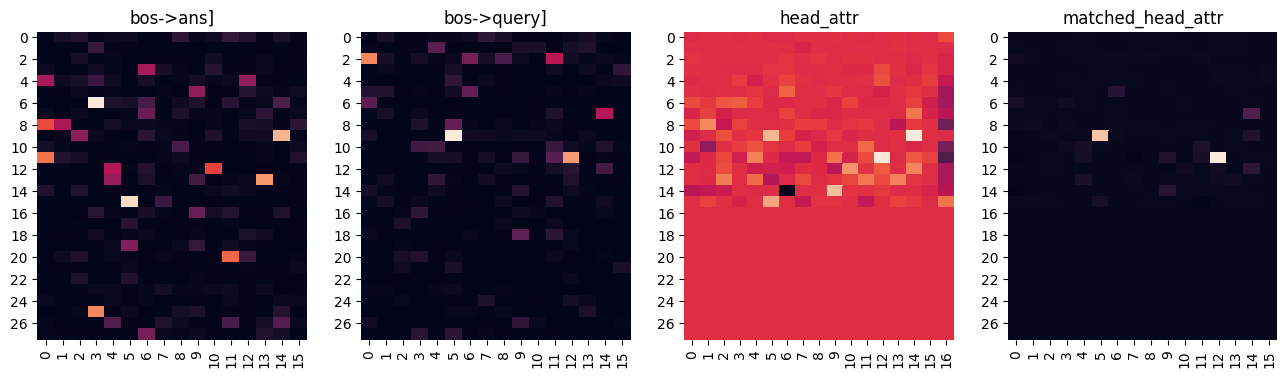

(array([ 6, 15,  9, 13, 25, 11, 20,  8, 12, 12]),
 array([ 3,  5, 14, 13,  3,  0, 11,  0, 10,  4]),
 array([0.04770884, 0.04549202, 0.04106524, 0.0374262 , 0.03578469,
       0.03369733, 0.03226086, 0.02957663, 0.02889249, 0.0212364 ],
      dtype=float32))
(array([ 9, 11,  2,  2,  7,  2,  8,  5, 18,  1]),
 array([ 5, 12,  0, 11, 14,  6,  5,  6,  9,  4]),
 array([0.83601713, 0.6662075 , 0.6237856 , 0.39077282, 0.37646383,
       0.2476645 , 0.22024627, 0.21284907, 0.2049056 , 0.19926755],
      dtype=float32))
(array([ 9, 11, 14,  9, 15, 12,  8, 12, 13, 11]),
 array([14, 12,  9,  5,  5, 10,  1, 14, 13,  4]),
 array([0.76311445, 0.7415245 , 0.5631954 , 0.52961487, 0.4570491 ,
       0.3809614 , 0.33047193, 0.31903157, 0.29810354, 0.29532954],
      dtype=float32))
(array([11,  9,  7, 12, 14,  5,  9, 11, 10, 13]),
 array([12,  5, 14, 14,  9,  6, 14,  9, 11,  4]),
 array([0.4940092 , 0.4427671 , 0.09577715, 0.04658753, 0.04405687,
       0.04091111, 0.03133748, 0.02920548, 0.02617496, 0.0

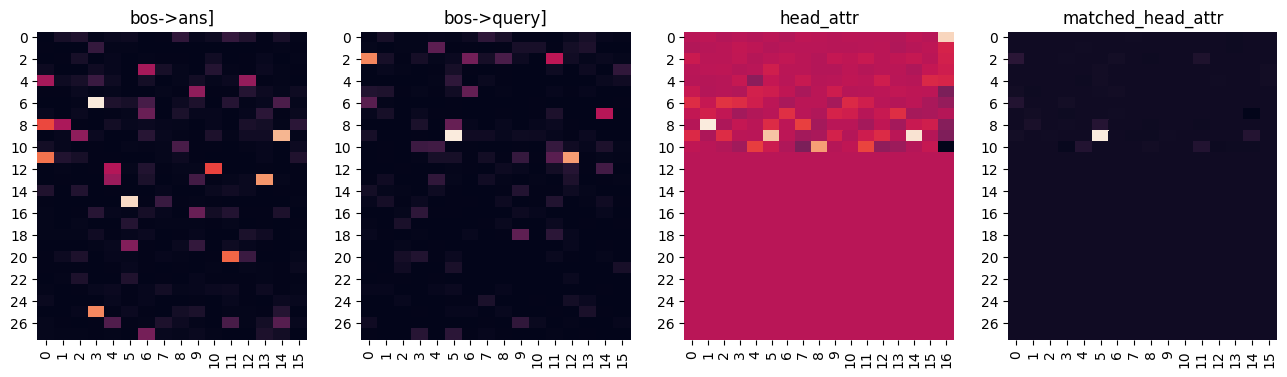

(array([ 6, 15,  9, 13, 25, 11, 20,  8, 12, 12]),
 array([ 3,  5, 14, 13,  3,  0, 11,  0, 10,  4]),
 array([0.04770884, 0.04549202, 0.04106524, 0.0374262 , 0.03578469,
       0.03369733, 0.03226086, 0.02957663, 0.02889249, 0.0212364 ],
      dtype=float32))
(array([ 9, 11,  2,  2,  7,  2,  8,  5, 18,  1]),
 array([ 5, 12,  0, 11, 14,  6,  5,  6,  9,  4]),
 array([0.83601713, 0.6662075 , 0.6237856 , 0.39077282, 0.37646383,
       0.2476645 , 0.22024627, 0.21284907, 0.2049056 , 0.19926755],
      dtype=float32))
(array([ 8,  9,  0,  9, 10, 10,  8, 10,  6,  7]),
 array([ 1, 14, 16,  5,  8, 11,  7,  4,  2,  6]),
 array([0.59493357, 0.5721984 , 0.5331251 , 0.4838613 , 0.38159037,
       0.17281978, 0.1578762 , 0.15268047, 0.1292929 , 0.11914852],
      dtype=float32))
(array([ 9,  2,  8,  9, 10,  6, 10,  2,  8,  6]),
 array([ 5,  0,  5, 14,  4,  0, 11, 11,  1,  3]),
 array([0.40451634, 0.03016051, 0.0241309 , 0.02349746, 0.02164595,
       0.02139217, 0.020827  , 0.01686619, 0.01205003, 0.0

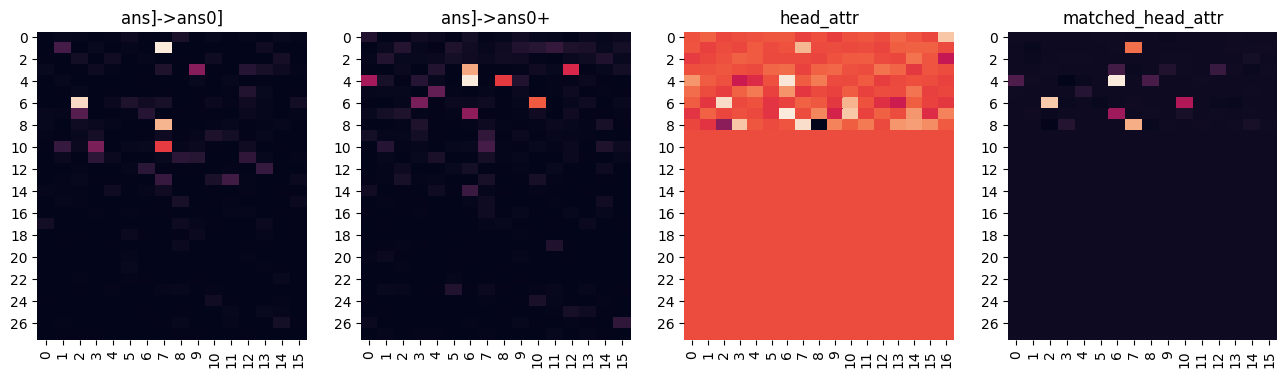

(array([ 1,  6,  8, 10,  3, 10,  7,  1, 13, 13]),
 array([ 7,  2,  7,  7,  9,  3,  2,  1, 11,  7]),
 array([0.8048037 , 0.76950383, 0.6895408 , 0.4770111 , 0.27474135,
       0.25369987, 0.17997047, 0.14532772, 0.13749723, 0.11752789],
      dtype=float32))
(array([ 4,  3,  6,  4,  3,  4,  7,  6,  5, 10]),
 array([ 6,  6, 10,  8, 12,  0,  6,  3,  4,  7]),
 array([0.7813161 , 0.6490304 , 0.5106969 , 0.45844525, 0.42164356,
       0.3204711 , 0.2828238 , 0.23884372, 0.19926937, 0.14330117],
      dtype=float32))
(array([7, 4, 8, 6, 8, 7, 0, 1, 6, 8]),
 array([ 6,  6,  7,  2,  3, 10, 16,  7, 10, 14]),
 array([0.40421855, 0.38861123, 0.36894202, 0.35866925, 0.30260488,
       0.30072796, 0.29966113, 0.2586509 , 0.24945886, 0.1894974 ],
      dtype=float32))
(array([4, 6, 8, 1, 6, 7, 4, 4, 3, 3]),
 array([ 6,  2,  7,  7, 10,  6,  0,  8,  6, 12]),
 array([0.3036282 , 0.27599737, 0.25440058, 0.2081632 , 0.12739787,
       0.11432263, 0.05366898, 0.04882533, 0.0452567 , 0.03662259],
      dtyp

In [1010]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [983]:
forked_node_k.k_node = q_node; forked_node_k.model = model
del forked_node_k.k_node; del forked_node_k.model

In [928]:
forked_node.k_node = k_node; forked_node.model = model
del forked_node.k_node; del forked_node.model

In [1007]:
node = node.parent.parent

In [1012]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr) #label_type='attn_labels', attn_pattern='bos->query]', step=0, attribute_k=True) # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)
 [-1] root labels┐
                 │                           ┌[0] top[0] 11-12 attn_labels attr_k┐
                 │                           │                                   └[1] top[0] 0-mlp
                 └[0] top[1] 16-7 attn_labels┤
                                             │                            ┌[1] top[1] 9-14┐
                                             │                            │               └*[2] top[0, 1, 2, 3] 7-6,4-6,8-7,6-2...
                                             └[0] top[0] 11-12 attn_labels┤
                                                                          │              ┌[2] top[0, 1] 4-6,6-2
                                                                          └[1] top[0] 8-1┤
                                                                                         └[2] top[0] 4-6┐
                                                                 

Eric's insensitive. Jake's careless. So Jake is careless
Cal's healthy. Fox's popular. So Fox is popular
Miller's healthy. Christopher's irresponsible. So Miller is healthy
 [-1] root labels┐
                 │                           ┌[1] top[0, 1, 2, 3, 4] 9-14,11-12,14-9,15-5,12-10
                 └[0] top[0] 16-7 attn_labels┤
                                             └[1] top[1] 11-12 attn_labels┐
                                                                          └*[2] top[0, 1] 8-1,9-14
[-1] root labels


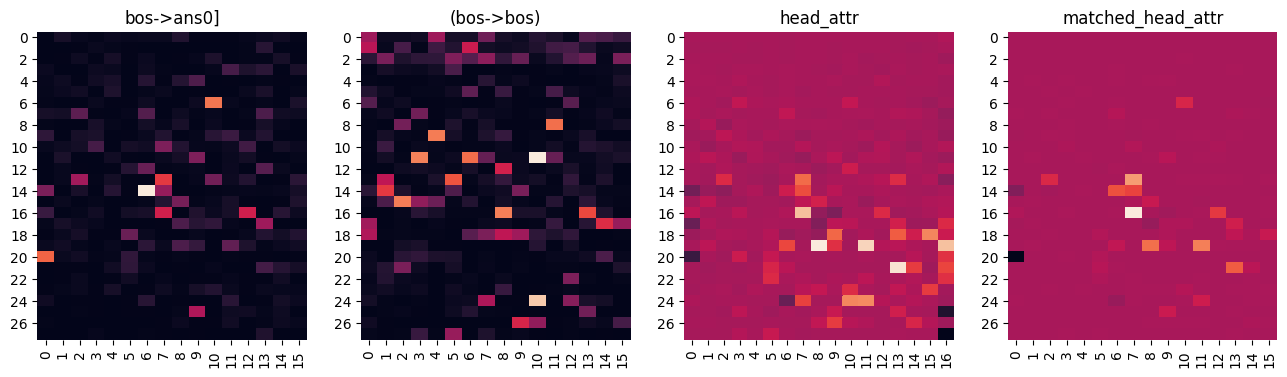

(array([14,  6, 20, 13, 16, 16, 25, 13, 17, 14]),
 array([ 6, 10,  0,  7,  7, 12,  9,  2, 13,  7]),
 array([0.5582747 , 0.39720023, 0.3764074 , 0.32527274, 0.2886181 ,
       0.28770533, 0.24183121, 0.22325404, 0.21911837, 0.20982452],
      dtype=float32))
(array([11, 24, 11, 16, 15,  9,  8, 11, 13, 16]),
 array([10, 10,  3,  8,  2,  4, 11,  6,  5, 13]),
 array([0.7025062 , 0.64137477, 0.5179586 , 0.51339966, 0.5111511 ,
       0.5092442 , 0.48898828, 0.48653507, 0.45158994, 0.43381476],
      dtype=float32))
(array([19, 21, 19, 19, 16, 24, 18, 24, 13, 18]),
 array([ 8, 13, 11, 16,  7, 11, 15, 10,  7,  9]),
 array([0.84503436, 0.81464404, 0.7598767 , 0.6872287 , 0.67977685,
       0.49128267, 0.48184812, 0.48137867, 0.39599666, 0.38570717],
      dtype=float32))
(array([16, 13, 19, 19, 21, 14, 14, 16, 13,  6]),
 array([ 7,  7, 11,  8, 13,  6,  7, 12,  2, 10]),
 array([0.1961959 , 0.12880692, 0.10608027, 0.09434007, 0.08102574,
       0.07293119, 0.06462653, 0.05547665, 0.04339284, 0.0

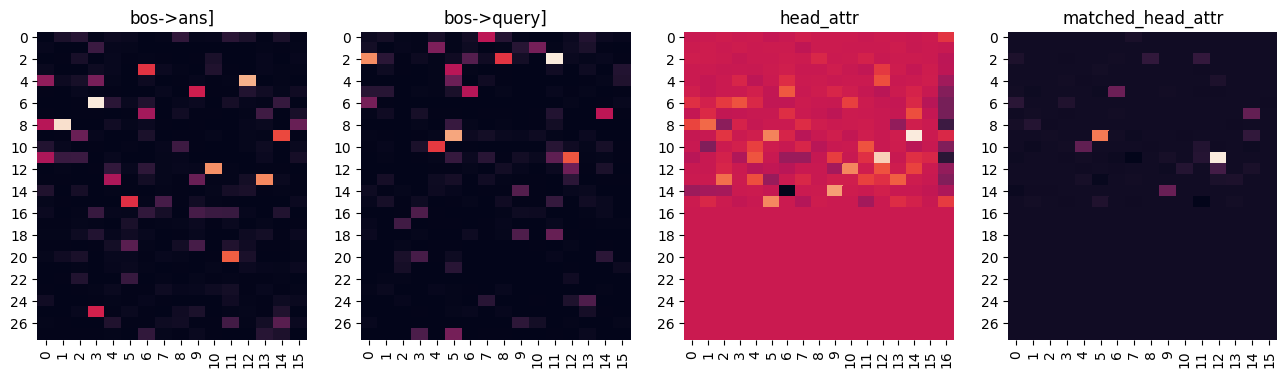

(array([ 6,  8,  4, 12, 13, 20,  9,  3, 15, 25]),
 array([ 3,  1, 12, 10, 13, 11, 14,  6,  5,  3]),
 array([0.07361275, 0.07142778, 0.06265893, 0.05679419, 0.05532019,
       0.04887915, 0.04549951, 0.04217789, 0.04146723, 0.03834671],
      dtype=float32))
(array([ 2,  9,  2, 11, 10,  2,  0,  7,  3,  5]),
 array([11,  5,  0, 12,  4,  8,  7, 14,  5,  6]),
 array([0.91010565, 0.7478374 , 0.6951008 , 0.5875778 , 0.5363391 ,
       0.52446353, 0.4239209 , 0.423516  , 0.41275877, 0.40676704],
      dtype=float32))
(array([ 9, 11, 14, 15, 12,  9, 13,  8, 13,  5]),
 array([14, 12,  9,  5, 10,  5,  2,  1, 13,  6]),
 array([0.9731534 , 0.84340286, 0.5922267 , 0.49070737, 0.4827818 ,
       0.46873233, 0.38941   , 0.36653927, 0.32019576, 0.29375523],
      dtype=float32))
(array([11,  9,  5, 14,  7, 10, 12,  2,  2,  9]),
 array([12,  5,  6,  9, 14,  4, 12, 11,  8, 14]),
 array([0.49556482, 0.35053557, 0.11948995, 0.11671048, 0.10980111,
       0.10529977, 0.07014427, 0.04663164, 0.04454374, 0.0

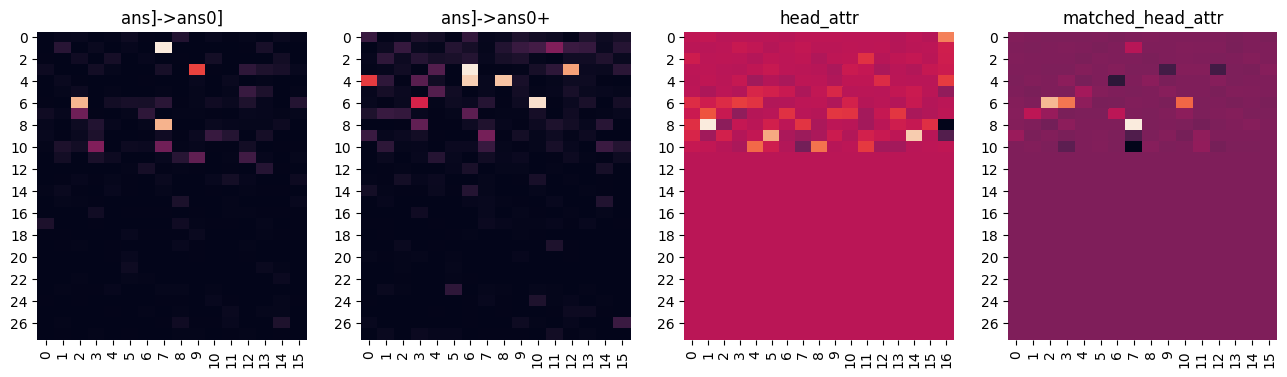

(array([ 1,  6,  8,  3, 10, 10,  7, 11, 11,  5]),
 array([ 7,  2,  7,  9,  3,  7,  2,  9, 12, 12]),
 array([0.8655817 , 0.7469694 , 0.73901284, 0.5242302 , 0.28276452,
       0.24902661, 0.24497032, 0.21375817, 0.14846885, 0.13181344],
      dtype=float32))
(array([3, 6, 4, 4, 3, 4, 6, 1, 9, 8]),
 array([ 6, 10,  6,  8, 12,  0,  3, 11,  7,  3]),
 array([0.6921727 , 0.6717471 , 0.64146197, 0.62182754, 0.56110847,
       0.41024655, 0.3654102 , 0.22567885, 0.20759772, 0.17456508],
      dtype=float32))
(array([ 8,  9,  9,  0, 10, 10,  7,  6,  4, 10]),
 array([ 1, 14,  5, 16,  8,  4,  1,  3, 16, 11]),
 array([0.6744655 , 0.5700911 , 0.46161965, 0.34342766, 0.30712804,
       0.28020674, 0.22938085, 0.1710095 , 0.16370714, 0.16258606],
      dtype=float32))
(array([8, 6, 6, 6, 7, 7, 1, 5, 9, 7]),
 array([ 7,  2,  3, 10,  1,  6,  7,  4,  0,  2]),
 array([0.10846771, 0.08722406, 0.06248862, 0.05686156, 0.02364046,
       0.02253045, 0.02078707, 0.01427018, 0.01038358, 0.00975198],
      dtyp

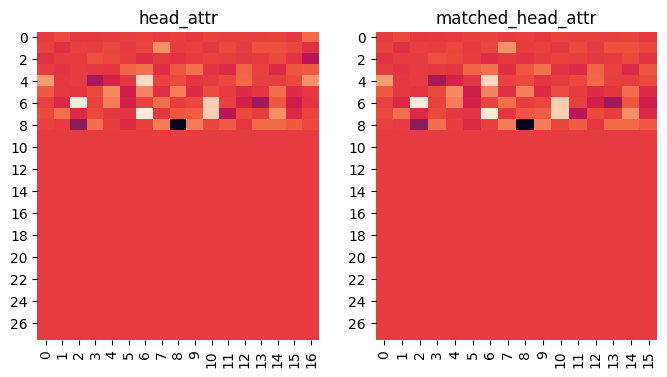

(array([7, 6, 4, 7, 6, 4, 4, 1, 7, 5]),
 array([ 6,  2,  6, 10, 10,  0, 16,  7, 14,  4]),
 array([0.44601646, 0.4425241 , 0.39619324, 0.36433756, 0.3595545 ,
       0.22638793, 0.20105277, 0.20072232, 0.19787328, 0.18211304],
      dtype=float32))
(array([7, 6, 4, 7, 6, 4, 1, 7, 5, 5]),
 array([ 6,  2,  6, 10, 10,  0,  7, 14,  4,  6]),
 array([0.44601646, 0.4425241 , 0.39619324, 0.36433756, 0.3595545 ,
       0.22638793, 0.20072232, 0.19787328, 0.18211304, 0.16436715],
      dtype=float32))


In [843]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

Blake's healthy. Jessica's friendly. So Blake is not sick
Edward's young. Joshua's happy. So Joshua is not sad
London's honest. Denver's brave. So Denver is not cowardly
                 ┌[0] top[1] 14-7 attn_labels┐
                 │                           └[1] top[0, 1, 2] 13-12,12-10,8-1
                 │                             ┌[1] top[0] 13-12
                 ├*[0] top[0] 16-14 attn_labels┤
                 │                             └[1] top[2] 14-9
 [-1] root labels┤
                 │                                    ┌[1] top[1, 2] 8-1,12-10┐
                 │                                    │                       └[2] top[0, 1] 7-9,0-mlp
                 └[0] top[0, 1] 16-14,14-7 attn_labels┤
                                                      │                ┌[2] top[0] 12-16┐
                                                      │                │                └[3] top[0, 1, 2, 3, 4, 5] 8-16,6-16,10-16,9-16,0-16,5-16
                                

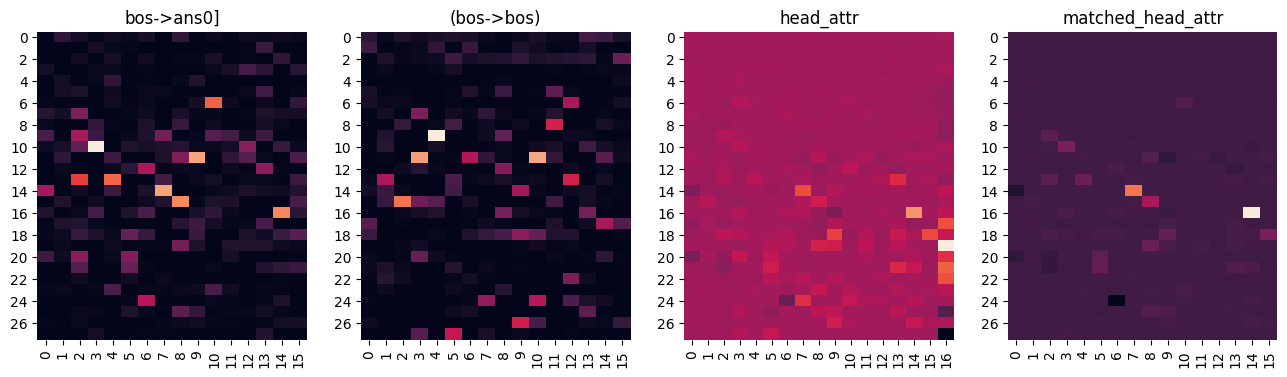

(array([10, 11, 14, 15, 16, 13,  6, 13, 24, 12]),
 array([ 3,  9,  7,  8, 14,  4, 10,  2,  6,  6]),
 array([0.37134004, 0.30393416, 0.30273253, 0.28130803, 0.27897608,
       0.25139096, 0.24814011, 0.22160813, 0.16848639, 0.15729591],
      dtype=float32))
(array([ 9, 11, 11, 15,  8, 13, 26, 27, 24, 11]),
 array([ 4, 10,  3,  2, 11, 12,  9,  5, 10,  6]),
 array([0.8820905 , 0.7280377 , 0.70745   , 0.625958  , 0.4606202 ,
       0.45521706, 0.4508668 , 0.42849737, 0.39656475, 0.39108062],
      dtype=float32))
(array([19, 16, 21, 22, 17, 14, 18, 18, 20, 24]),
 array([16, 14, 16, 16, 16,  7, 15,  9, 16,  7]),
 array([1.0461987 , 0.6599013 , 0.46456406, 0.41269252, 0.40026292,
       0.39435828, 0.37990025, 0.35752973, 0.28889537, 0.28566948],
      dtype=float32))
(array([16, 14, 15, 18, 10, 19, 13, 18, 21, 20]),
 array([14,  7,  8, 15,  3,  8,  4,  9,  5,  5]),
 array([0.18409668, 0.11938508, 0.05450191, 0.03203739, 0.0301017 ,
       0.02259064, 0.02195425, 0.0199887 , 0.0186738 , 0.0

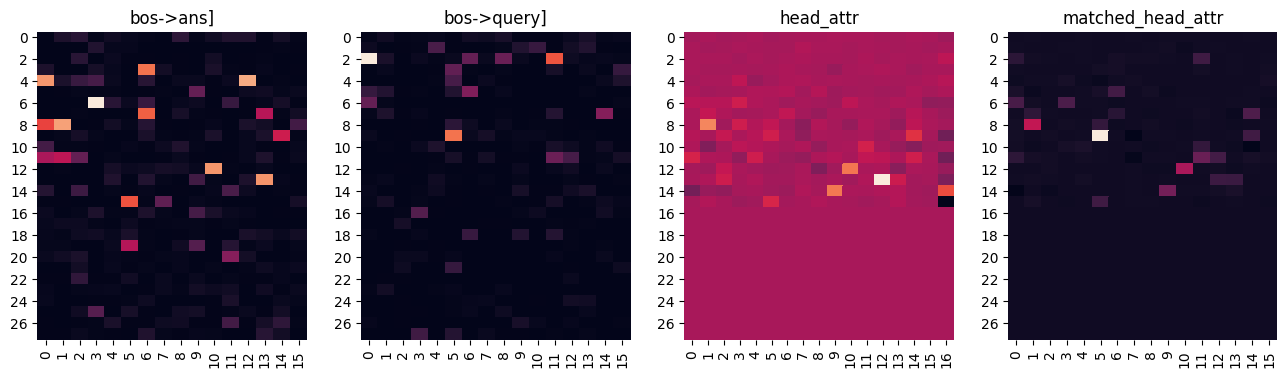

(array([ 6,  4,  8,  4, 12, 13,  3,  7, 15,  8]),
 array([ 3, 12,  1,  0, 10, 13,  6,  6,  5,  0]),
 array([0.09588981, 0.07981099, 0.07778356, 0.07549171, 0.07517102,
       0.07471517, 0.06766129, 0.06395748, 0.06131319, 0.05842683],
      dtype=float32))
(array([ 2,  9,  2,  7,  5, 11,  2,  2,  6,  3]),
 array([ 0,  5, 11, 14,  6, 11,  8,  6,  0,  5]),
 array([0.82332313, 0.5797336 , 0.5275772 , 0.27639997, 0.2655019 ,
       0.22794889, 0.22415121, 0.21508822, 0.21482679, 0.20799215],
      dtype=float32))
(array([13,  8, 14, 12, 14,  9, 15, 11, 10,  9]),
 array([12,  1,  9, 10, 16, 14,  5,  0, 11,  5]),
 array([0.79704994, 0.45128766, 0.4135838 , 0.40694627, 0.28861862,
       0.20918734, 0.16421658, 0.15664797, 0.14409404, 0.13337755],
      dtype=float32))
(array([ 9,  8, 12, 14, 11,  7,  6,  6, 11,  5]),
 array([ 5,  1, 10,  9, 11, 14,  3,  0, 12,  6]),
 array([0.07732345, 0.03510276, 0.03059056, 0.02050295, 0.01853049,
       0.01308615, 0.01259741, 0.01199688, 0.01104592, 0.0

In [654]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr, 

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)  # 

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 7, 9, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [661]:
node = node.children[1]

In [649]:
print(key); node = result.node = add_node(node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr)# label_type='attn_labels')  # 

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[1] 14-7 attn_labels┐
                 │                           └*[1] top[0, 1, 2] 13-12,12-10,8-1...
                 │                            ┌[1] top[0] 13-12
                 ├[0] top[0] 16-14 attn_labels┤
                 │                            └[1] top[2] 14-9
 [-1] root labels┤
                 │                                    ┌[1] top[1, 2] 8-1,12-10┐
                 │                                    │                       └[2] top[0, 1] 7-9,0-mlp
                 └[0] top[0, 1] 16-14,14-7 attn_labels┤
                                                      │                ┌[2] top[0] 12-16┐
                                                      │                │                └[3] top[0, 1, 2, 3, 4, 5] 8-16,6-16,10-16,9-16,0-16,5-16
                                                      └[1] top[0] 13-12┤
                                              

### thing->type

In [574]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 0.376, 0.8333333333333334
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.889, 0.21428571428571427


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [990]:
node.name

'[0] top[0] 11-12 attn_labels attr_k'

In [552]:
print(key); node = result.node = add_node(node, topi=[0,2,4], head_attr_fn=get_head_mlp_attr)#, label_type='argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-0 attn_labels┐
                 │                           └[1] top[0, 1, 2, 3, 4] 13-2,12-10,11-12,13-13,8-1
                 ├[0] top[2] 13-2 attn_labels:┐
                 │                            └[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 │                                  ┌[1] top[0] 9-14
                 ├[0] top[1] 16-7 argmax_attn_labels┤
                 │                                  └*[1] top[0, 2, 4] 9-14,12-10,13-13...
                 └[0] top[1] 16-7 attn_labels┐
                                             └[1] top[2] 12-10


In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 16, 7, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [566]:
node = node.parent.parent

In [559]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] 16-7 argmax_attn_labels┐
                                             └*[1] top[0] 12-10...


In [460]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] 16-7 attn_labels:
 [-1] root labels┤
                 └[0] 16-7 argmax_attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0] 0-16...


### fr->en

In [155]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0): 0.091, 0.84375
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=1): 0.109, 0.875
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0): 2.069, 0.53125
MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=1): 1.034, 0.59375


Israel a du lait. Israel's milk
Brandon a un couteau. Brandon's knife
Allen a un cochon. Allen's pig
 [-1] root labels┐
                 └[0] top[0, 1] 16-15,21-14 attn_labels┐
                                                       └*[1] top[0, 1, 2] 12-10,8-1,9-14
[-1] root labels


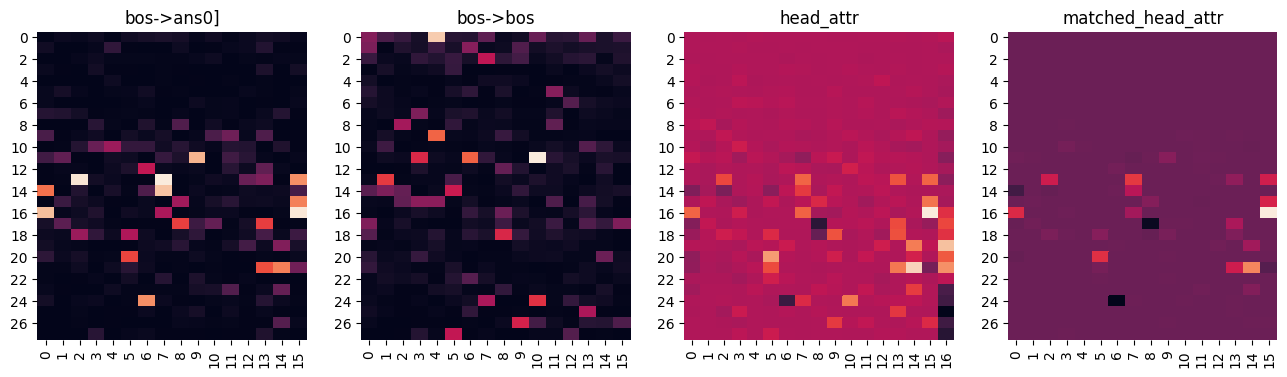

(array([13, 16, 13, 14, 16, 11, 13, 24, 15, 21, 14, 21, 20, 17, 17]),
 array([ 7, 15,  2,  7,  0,  9, 15,  6, 15, 14,  0, 13,  5,  8, 13]),
 array([0.66507304, 0.65941036, 0.6532651 , 0.59731275, 0.5896815 ,
       0.5695822 , 0.50988984, 0.5093812 , 0.489153  , 0.48744863,
       0.46580842, 0.41835535, 0.4071696 , 0.3992159 , 0.3972712 ],
      dtype=float32))
(array([11,  0,  9, 11, 13, 24, 11, 18, 26, 14, 27,  2, 25, 24,  8]),
 array([10,  4,  4,  6,  1, 10,  3,  8,  9,  5,  5,  7, 13,  7,  2]),
 array([0.82325715, 0.7535265 , 0.5542335 , 0.5505289 , 0.48243132,
       0.46744004, 0.4501853 , 0.44567642, 0.43307006, 0.40848514,
       0.39341664, 0.38745815, 0.352824  , 0.34722546, 0.3354797 ],
      dtype=float32))
(array([16, 21, 19, 20, 21, 19, 24, 21, 15, 13, 13, 16, 16, 20, 13]),
 array([15, 14, 16,  5, 16, 14, 10, 13, 15, 15,  7,  0,  7, 16, 13]),
 array([1.143993  , 1.0130931 , 0.91834545, 0.73390096, 0.6805589 ,
       0.5891374 , 0.57405627, 0.5709487 , 0.54420555, 0.48401

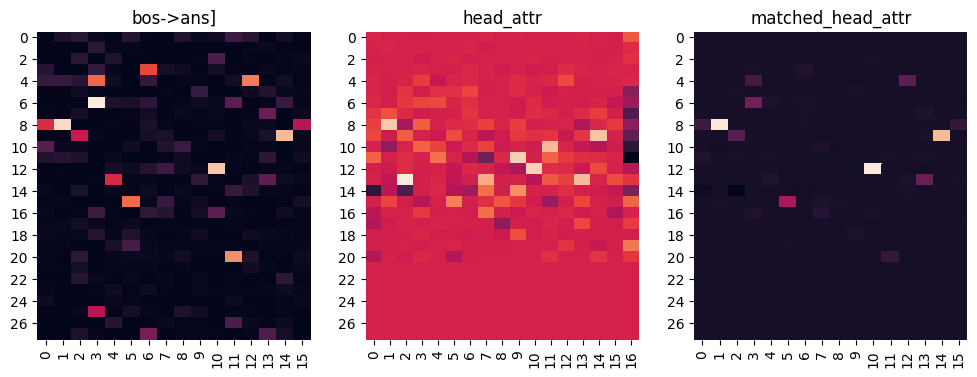

(array([ 6,  8, 12,  9, 20,  4, 15,  4,  3,  8, 13,  9, 25,  8, 27]),
 array([ 3,  1, 10, 14, 11, 12,  5,  3,  6,  0,  4,  2,  3, 15,  6]),
 array([0.13968189, 0.13417457, 0.12679906, 0.12240308, 0.10705693,
       0.10137565, 0.09620658, 0.09442291, 0.08526141, 0.07678007,
       0.07621292, 0.06889101, 0.06462397, 0.06405073, 0.04249103],
      dtype=float32))
(array([13, 12, 11,  8,  9, 13, 10, 13, 14, 15, 19, 11, 14, 16, 15]),
 array([ 2, 10,  9,  1, 14, 13, 11,  7,  9,  5, 16,  4,  7,  7, 16]),
 array([1.3678852 , 1.18516   , 1.1498721 , 1.1138935 , 1.065869  ,
       1.0114813 , 1.0095367 , 0.8983786 , 0.69823766, 0.59541434,
       0.5488477 , 0.50439763, 0.4983311 , 0.49625224, 0.42811126],
      dtype=float32))
(array([12,  8,  9, 15,  6, 13,  4,  9,  4,  8, 20,  8, 16, 11,  3]),
 array([10,  1, 14,  5,  3, 13, 12,  2,  3,  0, 11, 15,  7,  0,  6]),
 array([0.15027718, 0.14945619, 0.13046564, 0.05728278, 0.03667311,
       0.03406322, 0.02878587, 0.02701621, 0.01823672, 0.01607

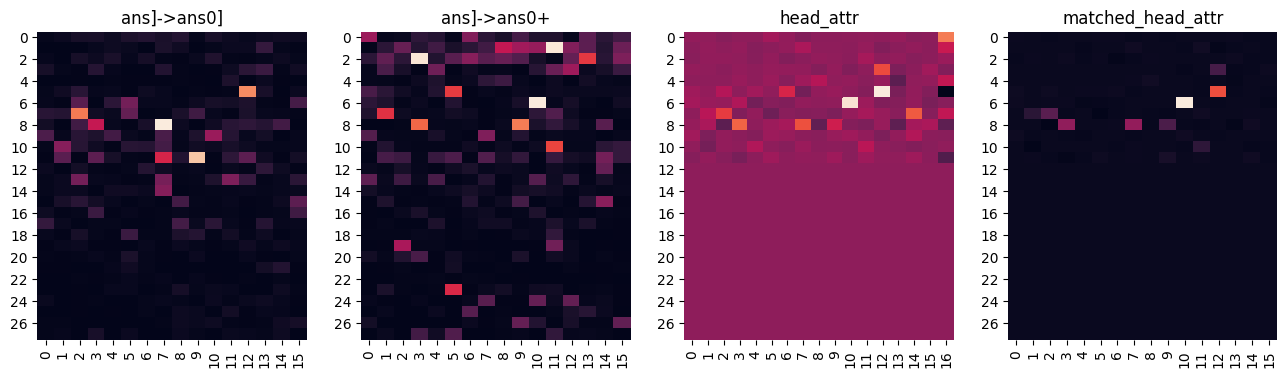

(array([ 8, 11,  5,  7, 11,  8,  9, 10, 14, 13, 13, 13,  6,  7, 11]),
 array([ 7,  9, 12,  2,  7,  3, 10,  1,  7, 11,  7,  2,  5,  5,  3]),
 array([0.4755939 , 0.42812014, 0.36201295, 0.34255573, 0.25273508,
       0.23216969, 0.18275474, 0.1601826 , 0.15916634, 0.15095642,
       0.1447461 , 0.14088392, 0.139579  , 0.1214673 , 0.11487199],
      dtype=float32))
(array([ 6,  1,  2,  8,  8, 10,  5,  2,  7, 23,  1, 19,  1,  3,  0]),
 array([10, 11,  3,  9,  3, 11,  5, 13,  1,  5,  8,  2,  9, 12,  0]),
 array([0.6008854 , 0.5956851 , 0.5930259 , 0.4361009 , 0.40856576,
       0.36812997, 0.35569283, 0.3516693 , 0.3426043 , 0.32842135,
       0.2892606 , 0.25214756, 0.24156478, 0.23607935, 0.23267354],
      dtype=float32))
(array([ 5,  6,  0,  8,  7,  8,  3,  7,  5,  8,  1,  4,  7, 10,  7]),
 array([12, 10, 16,  3, 14,  7, 12,  2,  6,  9, 16, 16, 16, 11,  1]),
 array([1.5978066 , 1.5485189 , 0.9164641 , 0.78764224, 0.7426104 ,
       0.69456375, 0.65689963, 0.5827241 , 0.43686688, 0.37791

In [172]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [173]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-15,21-14 attn_labels┐
                                                       └[1] top[0, 1, 2] 12-10,8-1,9-14┐
                                                                                       └*[2] top[0, 1, 2, 3, 4, 5] 6-10,5-12,8-7,8-3,7-2,8-9...


[[(5, 12, -1.016), (8, 7, -0.743), (7, 2, -1.071)], [(12, 10, -2.065), (8, 1, -2.009), (9, 14, -2.1)], [(16, 15, -0.416), (21, 14, -0.719)]]


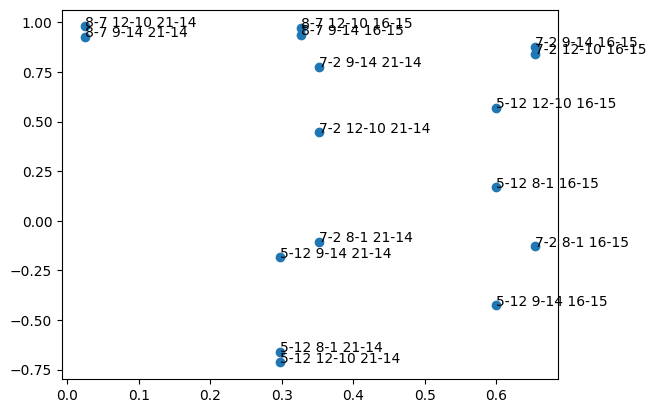

In [174]:
analyze_head_chains(model, get_head2scores(node));

Morgan a du pain. Allen a une banane. Allen's banana
Marco a du sucre. Adam a un chien. Marco's sugar
Alex a un cochon. Taylor a une poire. Alex's pig
                 ┌[0] top[1, 2] 16-15,21-14 argmax_attn_labels┐
                 │                                            └*[1] top[0, 1] 8-1,12-10┐
                 │                                                                     └[2] top[0, 1] 6-10,5-12
 [-1] root labels┤
                 └[0] top[0] 20-5 argmax_attn_labels┐
                                                    └[1] top[0, 1] 12-10,8-1┐
                                                                            └[2] top[0, 1, 2] 6-10,5-12,8-7
[-1] root labels


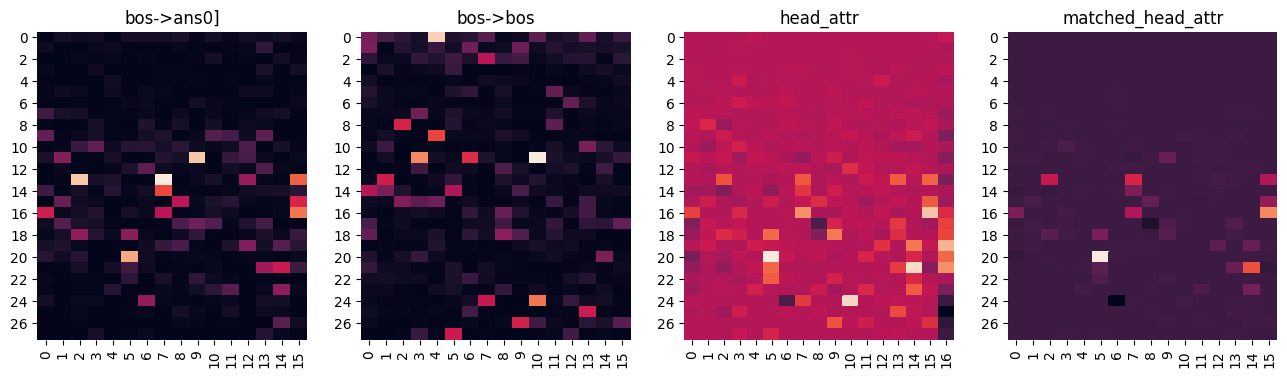

(array([13, 13, 11, 20, 16, 13, 14, 15, 16, 21, 15, 16, 21, 13, 24]),
 array([ 7,  2,  9,  5, 15, 15,  7, 15,  0, 14,  8,  7, 13, 12,  6]),
 array([0.37859485, 0.34557262, 0.3441495 , 0.31221935, 0.27006534,
       0.25252765, 0.23244298, 0.20399798, 0.1926609 , 0.18835565,
       0.17520411, 0.17202647, 0.1484158 , 0.14534342, 0.13996433],
      dtype=float32))
(array([11,  0, 11, 24,  9, 11,  8, 26, 13, 25, 27, 24,  2, 14, 14]),
 array([10,  4,  3, 10,  4,  6,  2,  9,  1, 13,  5,  7,  7,  0,  5]),
 array([0.8454481 , 0.78806716, 0.6356056 , 0.5981218 , 0.5161181 ,
       0.4719623 , 0.44778827, 0.44500896, 0.4291389 , 0.42286924,
       0.42084104, 0.41400927, 0.3832747 , 0.3815526 , 0.36956218],
      dtype=float32))
(array([20, 21, 24, 16, 19, 21, 16, 18, 19, 18, 21, 20, 13, 22, 23]),
 array([ 5, 14, 10, 15, 16, 16,  7,  9, 14,  5,  5, 16, 15,  5, 14]),
 array([0.73761964, 0.6846971 , 0.67393804, 0.59847045, 0.54584324,
       0.43656415, 0.4358937 , 0.3675637 , 0.36016673, 0.31874

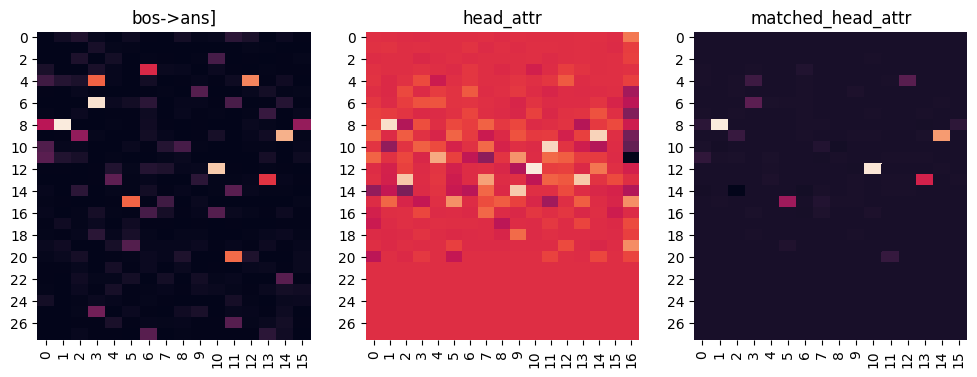

(array([ 8,  6, 12,  9,  4, 20, 15,  4, 13,  3,  8,  8,  9, 25, 13]),
 array([ 1,  3, 10, 14, 12, 11,  5,  3, 13,  6,  0, 15,  2,  3,  4]),
 array([0.13890716, 0.1352233 , 0.12662534, 0.11778666, 0.10360546,
       0.09576563, 0.093794  , 0.09308708, 0.07958443, 0.07579448,
       0.06364718, 0.05160855, 0.0506944 , 0.04064878, 0.03405727],
      dtype=float32))
(array([12,  8, 10,  9, 14, 13, 13, 11, 13, 11, 15, 15, 19,  0, 12]),
 array([10,  1, 11, 14,  9, 13,  2,  4,  7,  9,  5, 16, 16, 16, 14]),
 array([96.45615 , 89.21335 , 85.02794 , 82.042915, 77.35024 , 76.69446 ,
       75.081726, 58.92456 , 55.28678 , 48.409286, 46.392017, 45.773907,
       44.2779  , 33.90633 , 33.191055], dtype=float32))
(array([ 8, 12,  9, 13, 15,  6,  4,  4,  9, 20, 11,  8,  8, 10, 15]),
 array([ 1, 10, 14, 13,  5,  3, 12,  3,  2, 11,  0, 15,  0,  7,  7]),
 array([12.392373  , 12.213793  ,  9.663561  ,  6.103685  ,  4.351293  ,
        2.2719676 ,  2.1546042 ,  1.2877797 ,  1.0684081 ,  1.0077606 ,
      

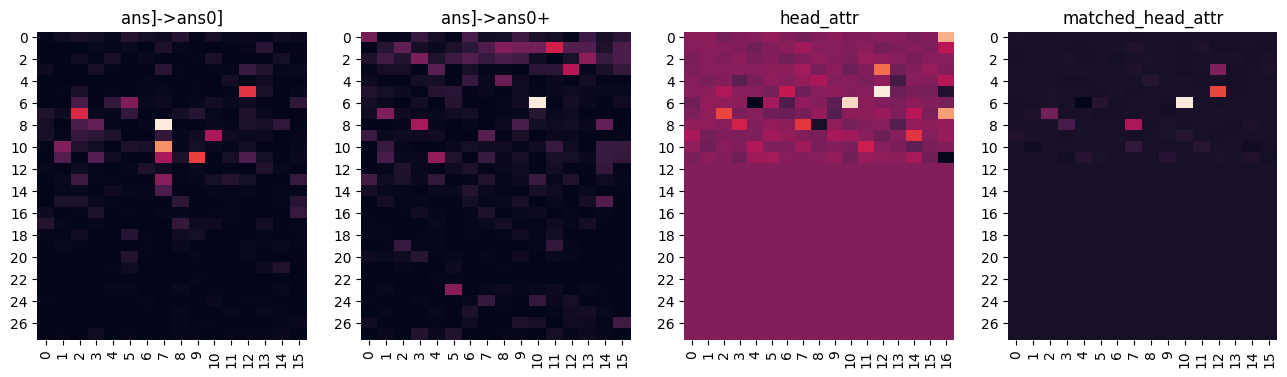

(array([ 8, 10, 11,  5,  7,  9, 11, 13, 10,  6,  8, 11, 11, 11, 14]),
 array([ 7,  7,  9, 12,  2, 10,  7,  7,  1,  5,  3,  1,  3, 12,  7]),
 array([0.42912892, 0.33038098, 0.25959954, 0.24605907, 0.2339274 ,
       0.18017651, 0.17804514, 0.14645128, 0.14159231, 0.14023449,
       0.11185123, 0.09218132, 0.09119799, 0.08718757, 0.08442611],
      dtype=float32))
(array([ 6,  1,  3,  8, 11,  2, 23,  1,  7,  2,  0,  1,  1,  4,  8]),
 array([10, 11, 12,  3,  4, 13,  5,  8,  1,  3,  0,  9, 10,  8, 14]),
 array([0.45290673, 0.23457985, 0.20795569, 0.18734798, 0.16794637,
       0.16015674, 0.15447323, 0.14811431, 0.14525083, 0.14131062,
       0.13503283, 0.133549  , 0.13303897, 0.12374572, 0.11678767],
      dtype=float32))
(array([ 5,  6,  0,  7,  3,  7,  8,  9,  8, 10,  5,  1,  7,  4,  5]),
 array([12, 10, 16, 16, 12,  2,  7, 14,  3, 11,  6, 16, 14, 16,  2]),
 array([120.478745, 111.78111 ,  93.447014,  84.96243 ,  66.191345,
        51.3719  ,  44.905724,  43.240707,  33.634712,  31.494

In [198]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [202]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1, 2] 16-15,21-14 argmax_attn_labels┐
                 │                                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                                    └*[2] top[0, 1, 2] 6-10,5-12,8-7...
 [-1] root labels┤
                 └[0] top[0] 20-5 argmax_attn_labels┐
                                                    └[1] top[0, 1] 12-10,8-1┐
                                                                            └[2] top[0, 1, 2] 6-10,5-12,8-7


[[(5, 12, -1.402), (8, 7, -0.846)], [(12, 10, -2.067), (8, 1, -1.974)], [(20, 5, -1.164)]]


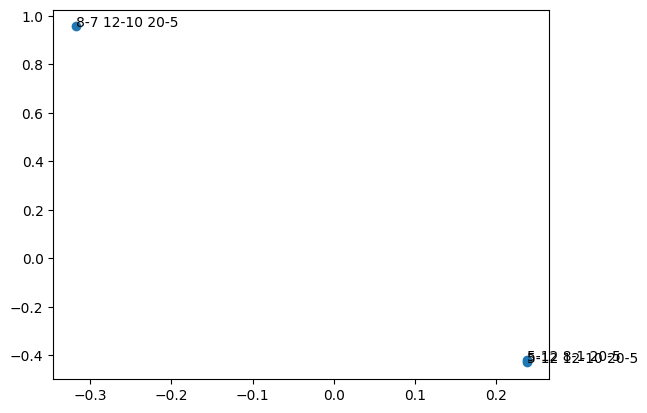

[(((5, 12), (12, 10), (20, 5)), -0.42940863966941833, 0.23799992),
 (((5, 12), (8, 1), (20, 5)), -0.4207330048084259, 0.23799992),
 (((8, 7), (12, 10), (20, 5)), 0.9564396142959595, -0.31800002)]

In [207]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [20]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0): 0.613, 0.65625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=1): 0.650, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0): 0.056, 0.8125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=1): 0.596, 0.5625
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0): 1.258, 0.53125
MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=1): 1.894, 0.5


Frank slept. Frank usually sleeps
Alice rode. Alice usually rides
Christopher sang. Christopher usually sings
                 ┌[0] top3 21-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5] 19-16,8-16,13-13,17-16,7-16,6-16
                 ├[0] top[0] 17-9 attn_labels┐
                 │                           └[1] top[0, 1, 2] 12-10,8-1,13-13┐
                 │                                                            └[2] top[0] 6-10
 [-1] root labels┤
                 │                     ┌[1] top[0, 1, 2, 3, 4, 5] 18-16,13-13,14-7,16-16,12-10,17-16
                 ├[0] top0 19-16 labels┤
                 │                     └[1] top0 18-16┐
                 │                                    └[2] top0 17-16┐
                 │                                                   └[3] top[0, 1] 16-16,15-16
                 └[0] top[1] 14-7 attn_labels┐
                                             └[1] top[0, 1] 8-1,12-10┐
                          

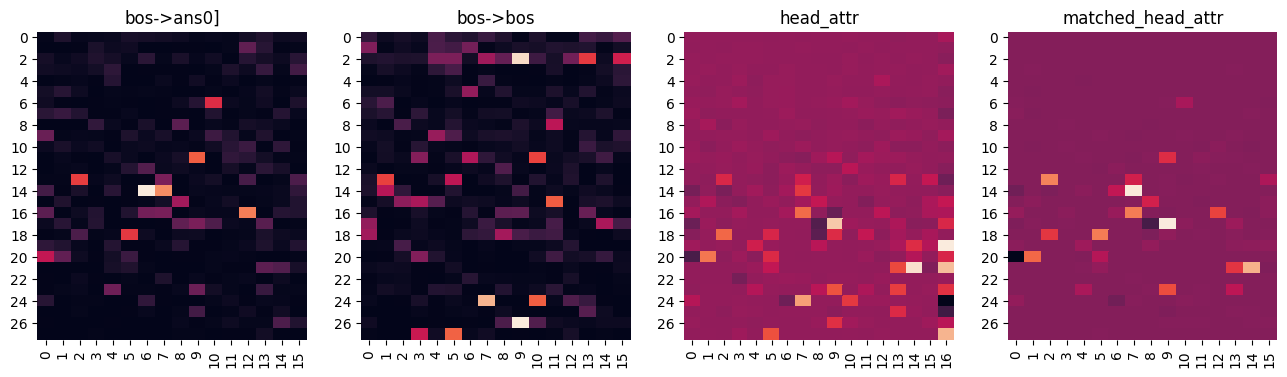

(array([14, 14, 16, 11, 13, 18,  6, 20, 15, 13, 17, 16, 16, 23, 23]),
 array([ 6,  7, 12,  9,  2,  5, 10,  0,  8,  7,  9,  7,  6,  4,  9]),
 array([0.85053706, 0.6500037 , 0.61923915, 0.5647938 , 0.5079791 ,
       0.49610338, 0.47459432, 0.4081268 , 0.34213424, 0.26491833,
       0.2629329 , 0.25978458, 0.250454  , 0.2417204 , 0.23296326],
      dtype=float32))
(array([26,  2, 24, 27, 24, 15, 11, 13,  2,  2, 27, 13,  8, 14, 11]),
 array([ 9,  9,  7,  5, 10, 11, 10,  1, 13, 15,  3,  5, 11,  1,  6]),
 array([0.6795221 , 0.65142053, 0.58230895, 0.45473418, 0.4501121 ,
       0.44651207, 0.41289532, 0.41123965, 0.40085185, 0.35015178,
       0.33596236, 0.32014546, 0.31358275, 0.3053663 , 0.29598162],
      dtype=float32))
(array([19, 21, 17, 21, 27, 24, 20, 16, 18, 23, 27, 21, 23, 24, 14]),
 array([16, 14,  9, 16, 16,  7,  1,  7,  2,  9,  5, 13, 13, 10,  7]),
 array([0.865344  , 0.82300496, 0.7396604 , 0.70264715, 0.67156684,
       0.60092556, 0.47076255, 0.4377886 , 0.43010864, 0.36878

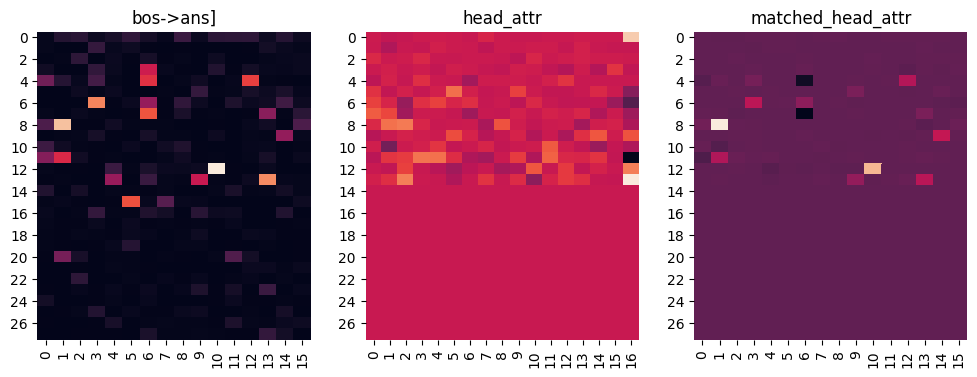

(array([12,  8, 13,  6,  7, 15,  4,  4, 11,  3, 13, 13,  6,  9,  7]),
 array([10,  1, 13,  3,  6,  5, 12,  6,  1,  6,  9,  4,  6, 14, 13]),
 array([0.12681027, 0.11265984, 0.09633334, 0.09427278, 0.08145289,
       0.08031502, 0.07613147, 0.07204751, 0.06903001, 0.06417467,
       0.06275836, 0.04822404, 0.04725975, 0.04663799, 0.04384679],
      dtype=float32))
(array([13,  0, 12, 13,  8, 11,  8, 11,  5, 11,  7, 10,  9, 12,  9]),
 array([16, 16, 16,  2,  2,  3,  1,  4,  5, 11,  0, 11, 14, 10, 16]),
 array([0.16580129, 0.13871351, 0.07851087, 0.07825278, 0.07363422,
       0.07062691, 0.06831115, 0.06828167, 0.06617963, 0.0580426 ,
       0.05367828, 0.05189107, 0.05025084, 0.04958178, 0.04747736],
      dtype=float32))
(array([ 8, 12,  9,  6, 13,  4, 11, 13,  6,  7,  5,  4,  8,  8, 11]),
 array([ 1, 10, 14,  3, 13, 12,  1,  9,  6, 13,  9,  3,  0, 15,  2]),
 array([0.00769592, 0.00628748, 0.0023436 , 0.002148  , 0.00206927,
       0.00196569, 0.00188263, 0.00120913, 0.00103156, 0.00060

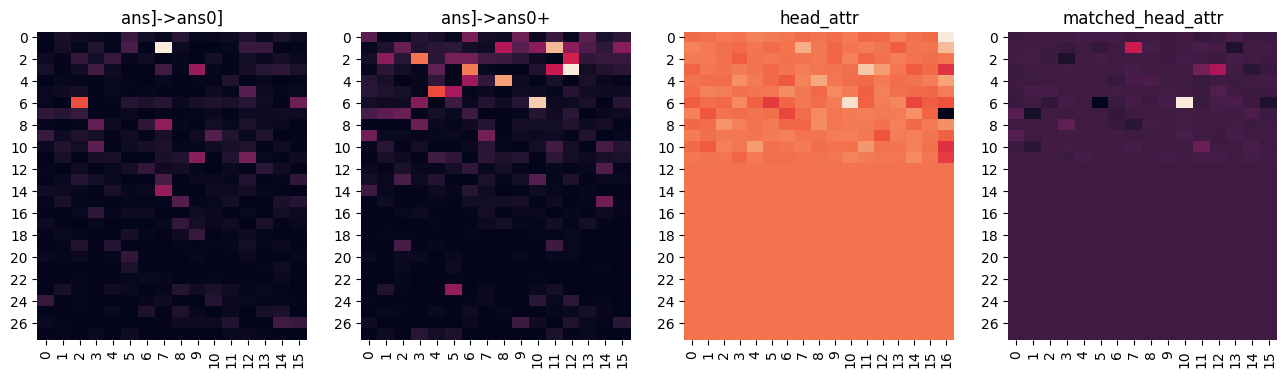

(array([ 1,  6,  3, 14,  8, 11, 11,  6,  8, 10,  5,  9, 15, 13,  1]),
 array([ 7,  2,  9,  7,  7,  9, 12, 15,  3,  3, 12, 10,  8,  7,  5]),
 array([0.59689635, 0.37583384, 0.23045115, 0.22509749, 0.21538366,
       0.20129856, 0.17559409, 0.16600989, 0.14965314, 0.14034203,
       0.13494678, 0.13342586, 0.12842903, 0.11388268, 0.11386438],
      dtype=float32))
(array([ 3,  6,  1,  4,  3,  2,  5,  2,  3,  1,  5,  4, 23,  2,  1]),
 array([12, 10, 11,  8,  6,  3,  4, 12, 11,  8,  5,  6,  5,  1, 10]),
 array([0.71891814, 0.6593494 , 0.6243433 , 0.57720447, 0.52169746,
       0.5090132 , 0.44837376, 0.37572223, 0.35465297, 0.31775787,
       0.2989378 , 0.28457427, 0.26522297, 0.25320855, 0.2531614 ],
      dtype=float32))
(array([ 0,  6,  3,  1,  1,  4,  4,  3, 10, 10,  8,  7,  4,  8,  8]),
 array([16, 10, 11, 16,  7,  8, 16, 12,  4, 11,  2, 14,  3, 16,  8]),
 array([0.18103647, 0.16388233, 0.12327103, 0.10443205, 0.0845451 ,
       0.07418627, 0.06752016, 0.05715105, 0.05654876, 0.05100

In [122]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [132]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

19-16 + 21-14
tensor([-11.1853,  -6.6410,  -2.1373,  -0.6626])
 Ġhits 0.0 {'Ġwins': 0.867, 'Ġwin': 0.085, 'Ġloses': 0.021, 'Ġwinning': 0.007} 	 India hit. India usually hits
*Ġeats 0.999 {'Ġeats': 0.999, 'Ġeat': 0.001, 'Ġfood': 0.0, 'Ġeating': 0.0} 	 Madison ate. Madison usually eats
 Ġleaves 0.0 {'Ġeats': 0.823, 'Ġsky': 0.036, 'ĠSky': 0.029, 'Sky': 0.016} 	 Sky left. Sky usually leaves
 Ġforg 0.146 {'Ġignores': 0.16, 'Ġforg': 0.146, 'Ġoverlook': 0.071, 'Ġloses': 0.046} 	 Christopher forgot. Christopher usually forgets
*Ġrides 0.992 {'Ġrides': 0.992, 'Ġride': 0.007, 'Ġriders': 0.0, 'Ġriding': 0.0} 	 Ryan rode. Ryan usually rides
*Ġswim 0.757 {'Ġswim': 0.757, 'Ġswimming': 0.147, 'Ġpools': 0.029, 'Ġsets': 0.012} 	 Brian swam. Brian usually swims
*Ġwrites 0.391 {'Ġwrites': 0.391, 'Ġsets': 0.085, 'Ġchooses': 0.065, 'Ġopens': 0.052} 	 Max wrote. Max usually writes
*Ġdrinks 0.851 {'Ġdrinks': 0.851, 'Ġdrinking': 0.079, 'Ġdrink': 0.067, 'Ġdrank': 0.002} 	 Sarah drank. Sarah usually drinks
tens

In [125]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

 Ġhits 0.079 {'Ġhit': 0.086, 'Ġhits': 0.079, 'Ġwins': 0.068} 	 India hit. India usually hits
*Ġeats 0.52 {'Ġeats': 0.52, 'Ġhits': 0.119, 'Ċ': 0.116} 	 Madison ate. Madison usually eats
*Ġleaves 0.733 {'Ġleaves': 0.733, 'Ġleft': 0.205, 'Ġeats': 0.028} 	 Sky left. Sky usually leaves
*Ġforg 0.953 {'Ġforg': 0.953, 'Ġforgot': 0.025, 'Ċ': 0.011} 	 Christopher forgot. Christopher usually forgets
*Ġrides 0.965 {'Ġrides': 0.965, 'Ġr': 0.011, 'Ġrode': 0.009} 	 Ryan rode. Ryan usually rides
*Ġswim 0.609 {'Ġswim': 0.609, 'Ġsw': 0.388, 'Ċ': 0.0} 	 Brian swam. Brian usually swims
*Ġwrites 0.993 {'Ġwrites': 0.993, 'Ġwrote': 0.004, 'Ġwrite': 0.001} 	 Max wrote. Max usually writes
*Ġdrinks 0.997 {'Ġdrinks': 0.997, 'Ġdrank': 0.001, 'Ġdr': 0.001} 	 Sarah drank. Sarah usually drinks


0.11801207065582275

 Ġwrites 0.024 {'Ġwrote': 0.129, 'Ġdidn': 0.041, 'Ġdid': 0.032} 	 Richard wrote. Richard usually writes
 Ġforg 0.23 {'Ġwrites': 0.304, 'Ġforg': 0.23, 'Ġforgot': 0.163} 	 August forgot. August usually forgets
*Ġcuts 0.804 {'Ġcuts': 0.804, 'Ċ': 0.08, 'Ġforg': 0.041} 	 Christian cut. Christian usually cuts
*Ġwrites 0.895 {'Ġwrites': 0.895, 'Ġwrote': 0.024, 'Ġforg': 0.01} 	 Jimmy wrote. Jimmy usually writes
*Ġdraws 0.988 {'Ġdraws': 0.988, 'Ġdrew': 0.004, 'Ġd': 0.002} 	 India drew. India usually draws
*Ġfalls 0.987 {'Ġfalls': 0.987, 'Ġfell': 0.008, 'Ġf': 0.001} 	 Eva fell. Eva usually falls
*Ġwrites 0.995 {'Ġwrites': 0.995, 'Ċ': 0.001, 'Ġwrote': 0.001} 	 Alice wrote. Alice usually writes
*Ġhears 0.993 {'Ġhears': 0.993, 'Ġhe': 0.004, 'Ċ': 0.001} 	 Israel heard. Israel usually hears


0.02956319972872734

 Ġknows 0.006 {'Ġknew': 0.319, 'Ġdid': 0.176, 'Ġhad': 0.044} 	 Danny knew. Danny usually knows
 Ġgoes 0.106 {'Ġknows': 0.307, 'Ġgoes': 0.106, 'Ċ': 0.042} 	 Major went. Major usually goes
*Ġswim 0.445 {'Ġswim': 0.445, 'Ġgoes': 0.272, 'Ġsw': 0.158} 	 Amy swam. Amy usually swims
*Ġsits 0.921 {'Ġsits': 0.921, 'Ġsat': 0.047, 'Ġsit': 0.007} 	 Mary sat. Mary usually sits
*Ġstands 0.971 {'Ġstands': 0.971, 'Ġstand': 0.01, 'Ġstood': 0.007} 	 Madison stood. Madison usually stands
*Ġswim 0.847 {'Ġswim': 0.847, 'Ġsw': 0.124, 'Ċ': 0.007} 	 Jimmy swam. Jimmy usually swims
*Ġwrites 0.982 {'Ġwrites': 0.982, 'Ġwrote': 0.008, 'Ċ': 0.003} 	 Boston wrote. Boston usually writes
*Ġrides 0.976 {'Ġrides': 0.976, 'Ġro': 0.008, 'Ġr': 0.004} 	 Carter rode. Carter usually rides


0.06418607383966446

 Ġsleeps 0.021 {'Ġslept': 0.598, 'Ġdid': 0.075, 'Ġfell': 0.035} 	 Frank slept. Frank usually sleeps
*Ġrides 0.723 {'Ġrides': 0.723, 'Ċ': 0.029, 'Ġdrives': 0.027} 	 Alice rode. Alice usually rides
*Ġsings 0.936 {'Ġsings': 0.936, 'Ċ': 0.034, 'Ġsang': 0.015} 	 Christopher sang. Christopher usually sings
*Ġrides 0.981 {'Ġrides': 0.981, 'Ġrode': 0.008, 'Ċ': 0.002} 	 Mark rode. Mark usually rides
*Ġreads 0.988 {'Ġreads': 0.988, 'Ġread': 0.009, 'Ċ': 0.001} 	 David read. David usually reads
*Ġleaves 0.975 {'Ġleaves': 0.975, 'Ġleft': 0.022, 'Ġgoes': 0.001} 	 Charlie left. Charlie usually leaves
*Ġplays 0.997 {'Ġplays': 0.997, 'Ġplayed': 0.002, 'Ġplay': 0.0} 	 Cruz played. Cruz usually plays
*Ġdrinks 0.999 {'Ġdrinks': 0.999, 'Ġdrank': 0.0, 'Ġdr': 0.0} 	 Rose drank. Rose usually drinks


0.012026864103972912

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [80]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top3 21-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5] 19-16,8-16,13-13,17-16,7-16,6-16
                 ├[0] top[0] 17-9 attn_labels┐
                 │                           └[1] top[0, 1, 2] 12-10,8-1,13-13┐
                 │                                                            └[2] top[0] 6-10
 [-1] root labels┤
                 │                     ┌[1] top[0, 1, 2, 3, 4, 5] 18-16,13-13,14-7,16-16,12-10,17-16
                 ├[0] top0 19-16 labels┤
                 │                     └[1] top0 18-16┐
                 │                                    └[2] top0 17-16┐
                 │                                                   └[3] top[0, 1] 16-16,15-16
                 └[0] top[1] 14-7 attn_labels┐
                                             └[1] top[0, 1] 8-1,12-10┐
                                                          

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

Clark saw. Steven hit. Clark usually saw
Gordon cut. Jennifer slept. Gordon usually cut
Adam listened. Paris drank. Paris usually drank
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0, 1, 2, 3, 4] 9-14,13-13,15-5,8-1,12-10
[-1] root labels


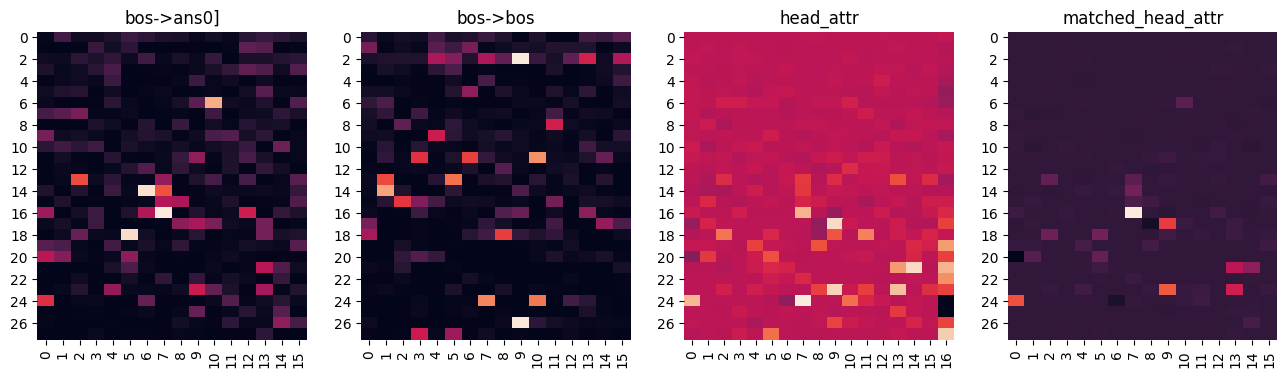

(array([16, 14, 18,  6, 14, 13, 24, 16, 23, 20]),
 array([ 7,  6,  5, 10,  7,  2,  0, 12,  9,  0]),
 array([0.33769614, 0.32891655, 0.3250873 , 0.28486922, 0.21600586,
       0.21201065, 0.18984829, 0.17090465, 0.16854346, 0.15781386],
      dtype=float32))
(array([ 2, 26, 14, 11, 24, 24, 13, 13, 11, 18]),
 array([ 9,  9,  1, 10,  7, 10,  5,  1,  6,  8]),
 array([0.65909505, 0.65177613, 0.5395132 , 0.50833255, 0.494129  ,
       0.472503  , 0.46299702, 0.40930894, 0.39412192, 0.3920003 ],
      dtype=float32))
(array([24, 17, 21, 23, 27, 23, 24, 16, 21, 19]),
 array([ 7,  9, 14,  9, 16, 13,  0,  7, 16, 16]),
 array([0.64306515, 0.58984536, 0.58733946, 0.5648923 , 0.547274  ,
       0.5035572 , 0.4811009 , 0.4682147 , 0.46713334, 0.40391248],
      dtype=float32))
(array([16, 23, 24, 17, 23, 21, 21, 18, 14, 18]),
 array([ 7,  9,  0,  9, 13, 13, 14,  5,  7,  2]),
 array([0.15811428, 0.0952089 , 0.09133618, 0.08347355, 0.0690743 ,
       0.06068112, 0.04091691, 0.02987663, 0.02983743, 0.0

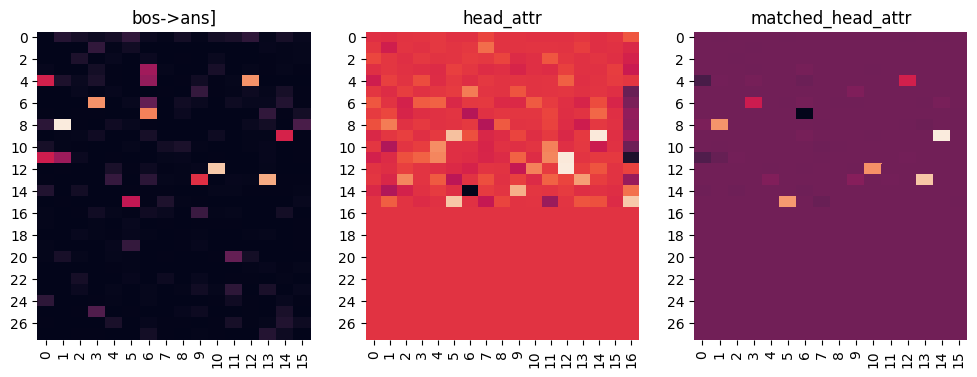

(array([ 8, 12, 13,  4,  6,  7, 13,  9,  4, 11]),
 array([ 1, 10, 13, 12,  3,  6,  9, 14,  0,  0]),
 array([0.1437951 , 0.13080217, 0.11967651, 0.11131979, 0.11128592,
       0.1059174 , 0.0810867 , 0.07583573, 0.07519059, 0.07326123],
      dtype=float32))
(array([12,  9, 11, 15, 15,  9, 14, 13, 10, 13]),
 array([12, 14, 12, 16,  5,  5,  9, 13,  4,  2]),
 array([0.37417367, 0.37021786, 0.36882713, 0.2932169 , 0.28841484,
       0.27767238, 0.2378357 , 0.20194149, 0.16612877, 0.15445608],
      dtype=float32))
(array([ 9, 13, 15,  8, 12,  4,  6, 13, 13,  5]),
 array([14, 13,  5,  1, 10, 12,  3,  9,  4,  9]),
 array([0.02807574, 0.02416765, 0.0198662 , 0.0192815 , 0.01897335,
       0.00900953, 0.00835238, 0.00195902, 0.00145776, 0.00125842],
      dtype=float32))
[1] top[0, 1, 2, 3, 4] 9-14,13-13,15-5,8-1,12-10


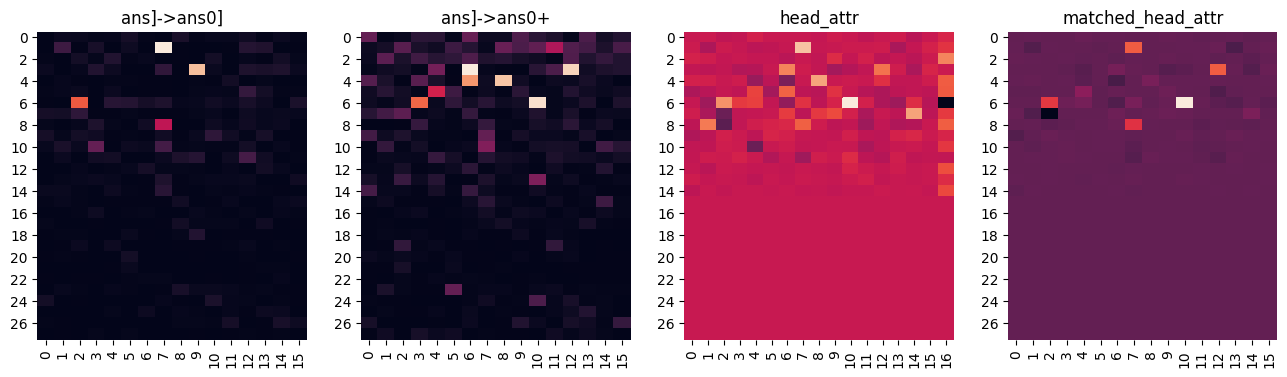

(array([ 1,  3,  6,  8, 10, 11, 10,  1,  5,  3]),
 array([ 7,  9,  2,  7,  3, 12,  7,  1, 12,  7]),
 array([0.83972347, 0.74452806, 0.5490011 , 0.39427528, 0.21765375,
       0.15169941, 0.14826664, 0.13523111, 0.11660346, 0.10653704],
      dtype=float32))
(array([ 3,  6,  3,  4,  4,  6,  5,  1, 10, 13]),
 array([ 6, 10, 12,  8,  6,  3,  4, 11,  7, 10]),
 array([0.6465495 , 0.6282912 , 0.6065796 , 0.58160174, 0.5085105 ,
       0.44040567, 0.33797097, 0.28025934, 0.2120715 , 0.20469171],
      dtype=float32))
(array([6, 1, 4, 7, 6, 2, 3, 8, 3, 5]),
 array([10,  7,  8, 14,  2, 16,  6,  1, 12,  6]),
 array([0.28712532, 0.22576089, 0.18511446, 0.18228263, 0.16013803,
       0.1436727 , 0.14044558, 0.12861389, 0.12123893, 0.10173981],
      dtype=float32))
(array([6, 1, 3, 6, 8, 5, 7, 6, 4, 3]),
 array([10,  7, 12,  2,  7,  4, 14,  7,  8,  6]),
 array([0.04502955, 0.02436542, 0.02422032, 0.01989158, 0.01873749,
       0.00588606, 0.0034985 , 0.0029532 , 0.00286286, 0.00256484],
      dtyp

In [88]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [89]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,13-13,15-5,8-1,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


[[(6, 2, -0.6)], [(9, 14, -2.579), (13, 13, -2.123), (15, 5, -2.675), (8, 1, -1.939), (12, 10, -2.034)], [(16, 7, -1.086)]]


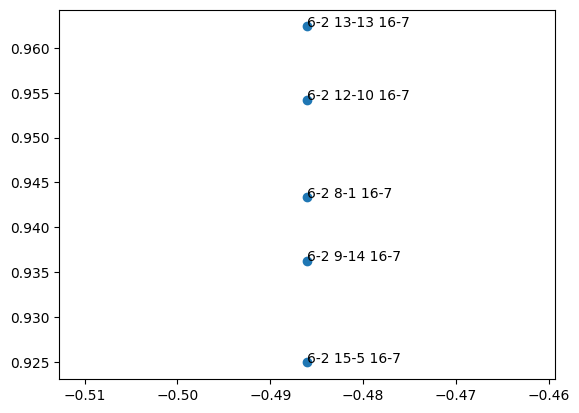

In [93]:
analyze_head_chains(model, get_head2scores(node));

Clark listened. Steven hit. Clark usually listens
Gordon drove. Jennifer came. Gordon usually drives
Adam drank. Paris played. Paris usually plays
                 ┌[0] top2 19-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5, 6] 13-13,18-16,0-16,17-16,16-16,13-7,12-10
 [-1] root labels┤
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,8-1,13-13,15-5,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...
[-1] root labels


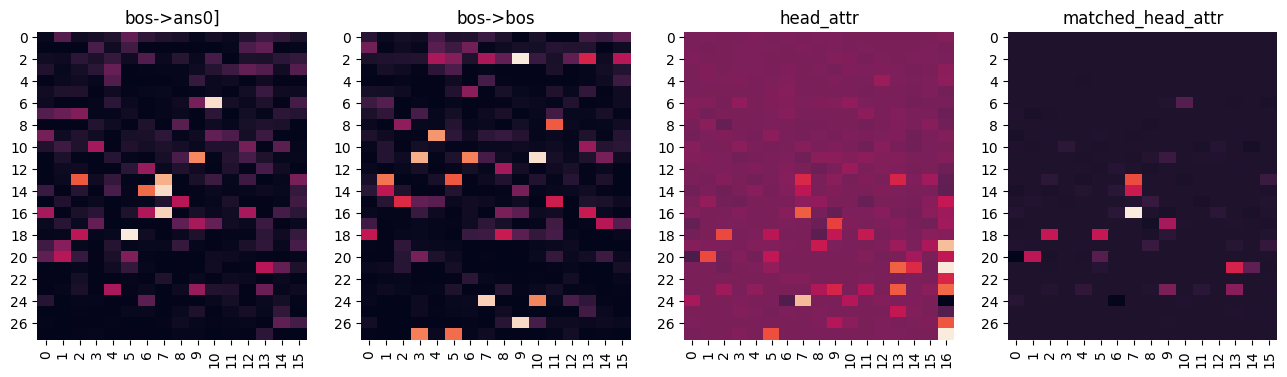

(array([18,  6, 14, 16, 13, 11, 14, 13, 18, 21, 20, 15, 16, 23, 16]),
 array([ 5, 10,  7,  7,  7,  9,  6,  2,  2, 13,  1,  8,  6,  4, 12]),
 array([0.2983389 , 0.28820443, 0.2863393 , 0.2790994 , 0.2538027 ,
       0.22487968, 0.20580497, 0.19407192, 0.13978389, 0.13563417,
       0.13404511, 0.13403967, 0.12860045, 0.12419111, 0.12374637],
      dtype=float32))
(array([ 2, 11, 26, 24, 11,  9, 24, 11, 27, 13, 27,  8, 13, 15,  2]),
 array([ 9, 10,  9,  7,  3,  4, 10,  6,  3,  1,  5, 11,  5,  2, 13]),
 array([0.6470899 , 0.6279394 , 0.6174656 , 0.6031659 , 0.5472693 ,
       0.5082008 , 0.4853102 , 0.47763446, 0.47442156, 0.4579418 ,
       0.44843292, 0.42434904, 0.4200021 , 0.35556775, 0.34164923],
      dtype=float32))
(array([27, 21, 19, 24, 23, 21, 16, 23, 26, 27, 20, 18, 17, 21, 13]),
 array([16, 16, 16,  7, 16, 13,  7, 13, 16,  5,  1,  2,  9, 14,  7]),
 array([0.785635  , 0.7787492 , 0.6512048 , 0.6450858 , 0.42145282,
       0.40103018, 0.39905715, 0.39141443, 0.38082016, 0.36272

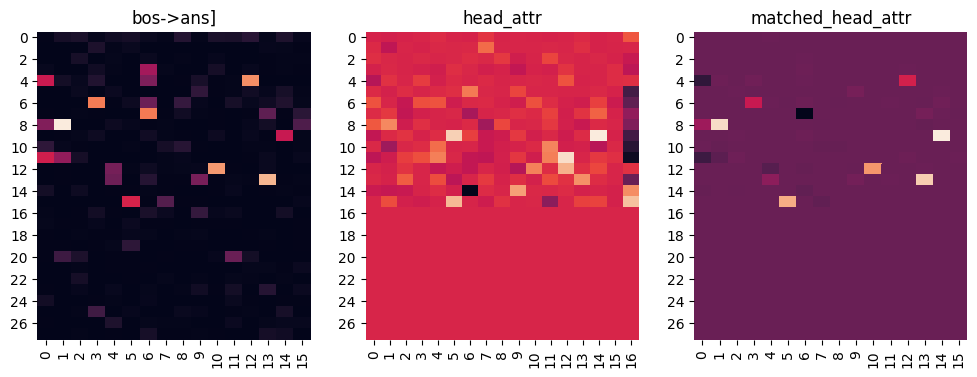

(array([ 8, 13, 12,  4,  6,  7, 15, 11,  4,  9,  3, 11,  8,  4, 13]),
 array([ 1, 13, 10, 12,  3,  6,  5,  0,  0, 14,  6,  1,  0,  6,  9]),
 array([0.17028806, 0.14635944, 0.13452874, 0.1304233 , 0.12330985,
       0.12248456, 0.09038118, 0.08744972, 0.0847979 , 0.08367576,
       0.06948622, 0.0624789 , 0.05523906, 0.05437044, 0.05212175],
      dtype=float32))
(array([ 9, 11,  9, 15, 15, 12, 14, 13, 14,  8, 10, 12, 11, 11,  5]),
 array([14, 12,  5, 16,  5, 12,  9, 13, 16,  1, 11, 10, 11,  4,  6]),
 array([0.31843647, 0.29306674, 0.26961648, 0.24265416, 0.22907841,
       0.21402957, 0.18663037, 0.16206226, 0.15496024, 0.14777872,
       0.1438428 , 0.13856322, 0.1354141 , 0.13470995, 0.12683359],
      dtype=float32))
(array([ 9,  8, 13, 15, 12,  4,  6,  8, 13,  5,  7, 13,  6,  4, 11]),
 array([14,  1, 13,  5, 10, 12,  3,  0,  4,  9, 13,  9, 14,  3,  2]),
 array([0.02664541, 0.02516495, 0.02371934, 0.02070438, 0.01864073,
       0.00916248, 0.00813291, 0.00434521, 0.00297637, 0.00111

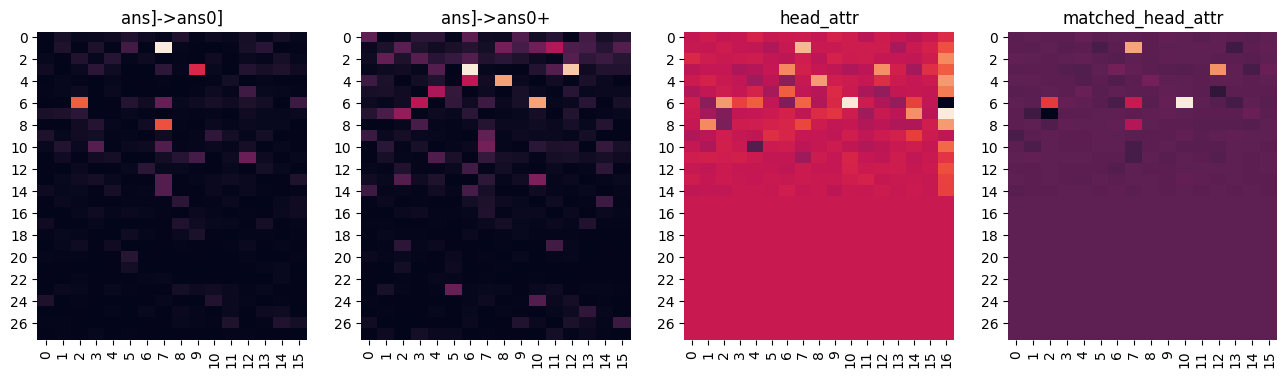

(array([ 1,  6,  8,  3, 11,  6, 10, 13, 14, 10, 11,  1,  5,  6,  9]),
 array([ 7,  2,  7,  9, 12,  7,  3,  7,  7,  7,  9,  5, 12, 15, 10]),
 array([0.6636512 , 0.43942252, 0.42063063, 0.35935327, 0.18032193,
       0.1756329 , 0.1490513 , 0.14319508, 0.14289089, 0.13747151,
       0.12182162, 0.11494457, 0.10936392, 0.10653887, 0.08529431],
      dtype=float32))
(array([ 3,  3,  6,  4,  4,  6,  1,  5,  7, 13, 10,  1,  1, 23,  2]),
 array([ 6, 12, 10,  8,  6,  3, 11,  4,  2, 10,  7,  8, 10,  5,  1]),
 array([0.62119454, 0.56322455, 0.5071423 , 0.5027758 , 0.29134205,
       0.2900751 , 0.27302217, 0.26205313, 0.22884506, 0.19794567,
       0.18443327, 0.18392691, 0.17536832, 0.16530606, 0.15924153],
      dtype=float32))
(array([ 7,  6,  1,  4,  8,  4,  6,  7,  3,  2,  8,  3,  5, 10,  6]),
 array([16, 10,  7,  8, 16, 16,  2, 14, 12, 16,  1,  6, 16, 16,  7]),
 array([0.22037762, 0.21655253, 0.16155893, 0.13247228, 0.13136293,
       0.12852329, 0.12828586, 0.11970419, 0.11824282, 0.11330

In [111]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [119]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1,2,3,4,5,6], head_attr_fn=get_head_mlp_attr, mix=True)

27-16 + 21-16 + 19-16 + 24-7 + 23-16 + 21-13 + 16-7
tensor([-12.2394,  -6.4726,  -2.7077,  -1.4430])
 Ġdances 0.001 {'Ġstarted': 0.037, 'Ġmoved': 0.026, 'Ġled': 0.016, 'Ġneeded': 0.012} 	 India danced. Laura listened. India usually dances
*Ġsits 0.461 {'Ġsits': 0.461, 'Ġlistens': 0.015, 'Ġreads': 0.013, 'Ġsat': 0.011} 	 Wilson sat. Steven played. Wilson usually sits
 Ġforg 0.006 {'Ġsits': 0.054, 'Ġlistens': 0.025, 'Ġshuts': 0.02, 'Ġlaughs': 0.017} 	 Chelsea listened. Russell forgot. Russell usually forgets
 Ġdraws 0.062 {'Ġfalls': 0.07, 'Ġfeels': 0.063, 'Ġdraws': 0.062, 'Ġwears': 0.02} 	 Winter fell. Danny drew. Danny usually draws
*Ġleaves 0.956 {'Ġleaves': 0.956, 'Ġflies': 0.009, 'Ġgoes': 0.005, 'Ġfloats': 0.004} 	 Richard flew. Major left. Major usually leaves
*Ġwalks 0.801 {'Ġwalks': 0.801, 'Ġwalked': 0.021, 'Ġgoes': 0.008, 'Ġeats': 0.008} 	 Mac walked. Sarah came. Mac usually walks
 Ġreads 0.021 {'Ġlistens': 0.166, 'Ġwears': 0.057, 'Ġeats': 0.044, 'Ġbuys': 0.025} 	 Joy read. Jane 

In [121]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

 Ġdances 0.016 {'Ġdanced': 0.428, 'Ġdid': 0.072, 'Ġhad': 0.035} 	 India danced. Laura listened. India usually dances
 Ġsits 0.152 {'Ġsat': 0.279, 'Ġsits': 0.152, 'Ġplayed': 0.098} 	 Wilson sat. Steven played. Wilson usually sits
 Ġforg 0.038 {'Ċ': 0.242, 'Ġsits': 0.177, 'Ġforgot': 0.092} 	 Chelsea listened. Russell forgot. Russell usually forgets
*Ġdraws 0.711 {'Ġdraws': 0.711, 'Ġfalls': 0.124, 'Ġforg': 0.022} 	 Winter fell. Danny drew. Danny usually draws
*Ġleaves 0.785 {'Ġleaves': 0.785, 'Ġflies': 0.175, 'Ġleft': 0.028} 	 Richard flew. Major left. Major usually leaves
*Ġwalks 0.946 {'Ġwalks': 0.946, 'Ġwalked': 0.041, 'Ċ': 0.002} 	 Mac walked. Sarah came. Mac usually walks
*Ġreads 0.977 {'Ġreads': 0.977, 'Ġread': 0.011, 'Ġsings': 0.006} 	 Joy read. Jane sang. Joy usually reads
*Ġcuts 0.973 {'Ġcuts': 0.973, 'Ġdances': 0.016, 'Ċ': 0.004} 	 Christian cut. Robin danced. Christian usually cuts


0.13787510991096497

 Ġreads 0.029 {'Ġread': 0.196, 'Ġrode': 0.119, 'Ġreads': 0.029} 	 Mary rode. Saint read. Saint usually reads
 Ġfalls 0.026 {'Ġtalks': 0.594, 'Ġtalked': 0.104, 'Ċ': 0.067} 	 Paris fell. Dallas talked. Paris usually falls
 Ġlistens 0.196 {'Ċ': 0.202, 'Ġsits': 0.201, 'Ġlistens': 0.196} 	 Joshua listened. Morgan sat. Joshua usually listens
*Ġlooks 0.867 {'Ġlooks': 0.867, 'Ġdrives': 0.091, 'Ċ': 0.013} 	 Hope looked. Sarah drove. Hope usually looks
 Ġstands 0.066 {'Ġdances': 0.894, 'Ġstands': 0.066, 'Ġd': 0.023} 	 Adam danced. Sam stood. Sam usually stands
 Ġdrinks 0.009 {'Ġstands': 0.982, 'Ġdrinks': 0.009, 'Ġstood': 0.002} 	 Dean stood. Lewis drank. Lewis usually drinks
*Ġstands 0.984 {'Ġstands': 0.984, 'Ġremembers': 0.005, 'Ġforg': 0.003} 	 Madison stood. Jamie forgot. Madison usually stands
*Ġsits 0.399 {'Ġsits': 0.399, 'Ġstands': 0.352, 'Ġreads': 0.208} 	 August read. Morgan sat. Morgan usually sits


1.700960397720337

 Ġrides 0.004 {'Ġrode': 0.219, 'Ġwalked': 0.096, 'Ġdrove': 0.066} 	 Paul walked. Carter rode. Carter usually rides
*Ġdraws 0.757 {'Ġdraws': 0.757, 'Ġdrew': 0.062, 'Ċ': 0.045} 	 Wilson played. Brandon drew. Brandon usually draws
*Ġsings 0.923 {'Ġsings': 0.923, 'Ċ': 0.056, 'Ġsang': 0.004} 	 Alexander flew. Christopher sang. Christopher usually sings
 Ġlooks 0.005 {'Ġplays': 0.957, 'Ċ': 0.007, 'Ġlooks': 0.005} 	 Jessica looked. River played. Jessica usually looks
 Ġhears 0.094 {'Ġstands': 0.88, 'Ġhears': 0.094, 'Ġlistens': 0.006} 	 King heard. Alex stood. King usually hears
 Ġfalls 0.356 {'Ġdreams': 0.486, 'Ġfalls': 0.356, 'Ġflies': 0.097} 	 Dream flew. Virginia fell. Virginia usually falls
*Ġforg 0.76 {'Ġforg': 0.76, 'Ġreads': 0.168, 'Ġforgot': 0.029} 	 Adam read. Lewis forgot. Lewis usually forgets
*Ġcomes 0.533 {'Ġcomes': 0.533, 'Ġhits': 0.419, 'Ġch': 0.006} 	 Charlie hit. Alexander came. Alexander usually comes


1.9350627660751343

 Ġlistens 0.003 {'Ġlistened': 0.085, 'Ġhit': 0.067, 'Ġhad': 0.048} 	 Clark listened. Steven hit. Clark usually listens
*Ġdrives 0.428 {'Ġdrives': 0.428, 'Ġlistens': 0.256, 'Ġhits': 0.054} 	 Gordon drove. Jennifer came. Gordon usually drives
 Ġplays 0.021 {'Ġdrinks': 0.413, 'Ġdrives': 0.257, 'Ġdrank': 0.098} 	 Adam drank. Paris played. Paris usually plays
*Ġsits 0.677 {'Ġsits': 0.677, 'Ġhears': 0.167, 'Ġlistens': 0.063} 	 Carter heard. Marco sat. Marco usually sits
*Ġeats 0.906 {'Ġeats': 0.906, 'Ġreads': 0.077, 'Ġate': 0.003} 	 Forest read. Jimmy ate. Jimmy usually eats
*Ġruns 0.849 {'Ġruns': 0.849, 'Ġran': 0.124, 'Ġhears': 0.013} 	 Mary ran. Kate heard. Mary usually runs
*Ġfalls 0.525 {'Ġfalls': 0.525, 'Ġgoes': 0.33, 'Ġfell': 0.093} 	 Joshua fell. Jennifer went. Joshua usually falls
 Ġcomes 0.007 {'Ġhears': 0.767, 'Ġlistens': 0.051, 'Ġruns': 0.023} 	 Raven heard. George came. George usually comes


1.259585976600647

In [107]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top2 19-16 labels┐
                 │                     └[1] top[0, 1, 2, 3, 4, 5, 6] 13-13,18-16,0-16,17-16,16-16,13-7,12-10
 [-1] root labels┤
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1, 2, 3, 4] 9-14,8-1,13-13,15-5,12-10┐
                                                                                              └*[2] top[0, 1, 2, 3] 6-10,1-7,3-12,6-2...


### thing->capability

In [1067]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.536, 0.71875
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.068, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.434, 0.9375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.939, 0.59375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.783, 0.375
MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 2.983, 0.3125


Joy has a shovel. Joy can dig
Anne has an oven. Anne can bake
Morgan has an opener. Morgan can open
                 ┌[0] top[3] 21-14 attn_labels┐
                 │                            └*[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 └[0] top[0] 13-15 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └[2] top[0, 1] 5-12,6-5
[-1] root labels


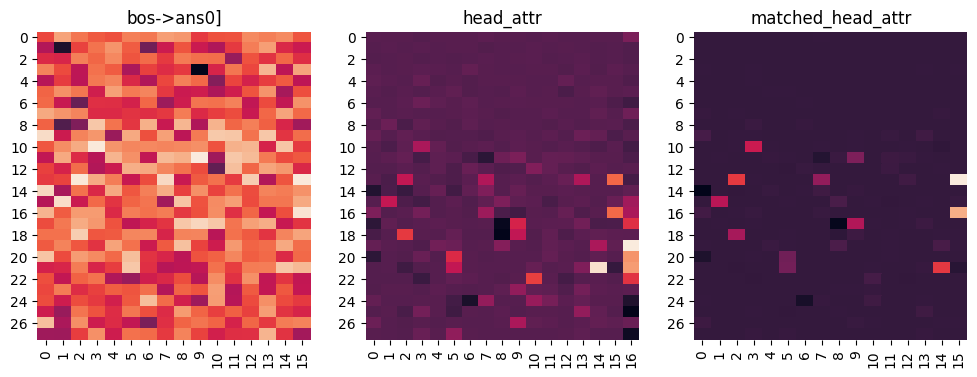

(array([11, 13, 10, 13, 16, 15,  9, 13, 14, 17]),
 array([ 9, 15,  3,  2, 15,  1,  0,  7,  0,  9]),
 array([-0.14714415, -0.2006315 , -0.23355517, -0.26417497, -0.41782066,
       -0.61550653, -0.6393409 , -0.7433788 , -0.797306  , -0.8511508 ],
      dtype=float32))
(array([19, 21, 21, 20, 16, 13, 22, 18, 22, 17]),
 array([16, 14, 16, 16, 15, 15, 10,  2, 16, 16]),
 array([0.9669722 , 0.93124914, 0.7171801 , 0.6906748 , 0.57370543,
       0.5668469 , 0.4673213 , 0.45413122, 0.4346339 , 0.4218084 ],
      dtype=float32))
(array([13, 16, 13, 21, 10, 15, 17, 18, 13, 11]),
 array([15, 15,  2, 14,  3,  1,  9,  2,  7,  9]),
 array([0.463802  , 0.37777373, 0.24096721, 0.23862551, 0.19308263,
       0.17202733, 0.16099189, 0.14699656, 0.12431726, 0.09572738],
      dtype=float32))
[0] top[3] 21-14 attn_labels


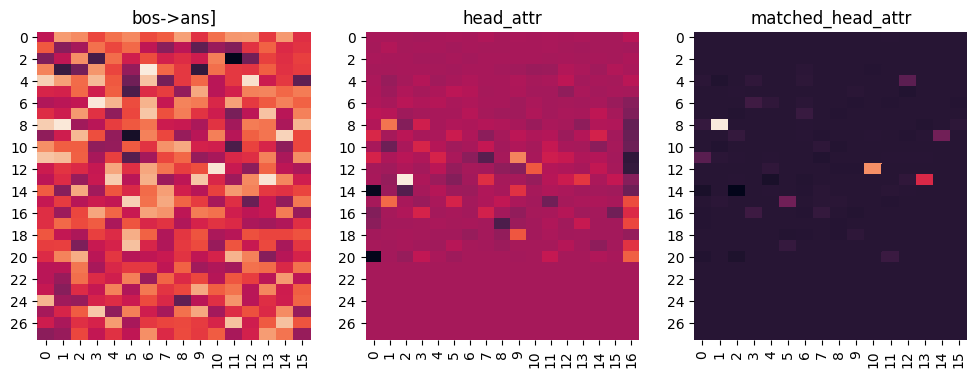

(array([ 3,  6,  8, 12, 13,  4,  9, 15,  4,  8]),
 array([ 6,  3,  1, 10, 13, 12, 14,  5,  0,  0]),
 array([-1.8900397, -1.9861841, -1.9935457, -2.0704236, -2.1309817,
       -2.1911201, -2.569666 , -2.65084  , -2.6649342, -2.7308824],
      dtype=float32))
(array([13, 11,  8, 15, 20, 12, 18, 15, 17, 13]),
 array([ 2,  9,  1,  1, 16, 10,  9, 16, 16, 13]),
 array([0.9693556 , 0.54882455, 0.4903853 , 0.44860652, 0.41993737,
       0.39253396, 0.38554567, 0.35057077, 0.33573037, 0.2764322 ],
      dtype=float32))
(array([ 8, 12, 13,  9, 15,  4, 11,  6, 16, 20]),
 array([ 1, 10, 13, 14,  5, 12,  0,  3,  3, 11]),
 array([0.06679617, 0.04951123, 0.03281822, 0.01400853, 0.01355164,
       0.00978034, 0.00974331, 0.0046957 , 0.00444124, 0.00386391],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


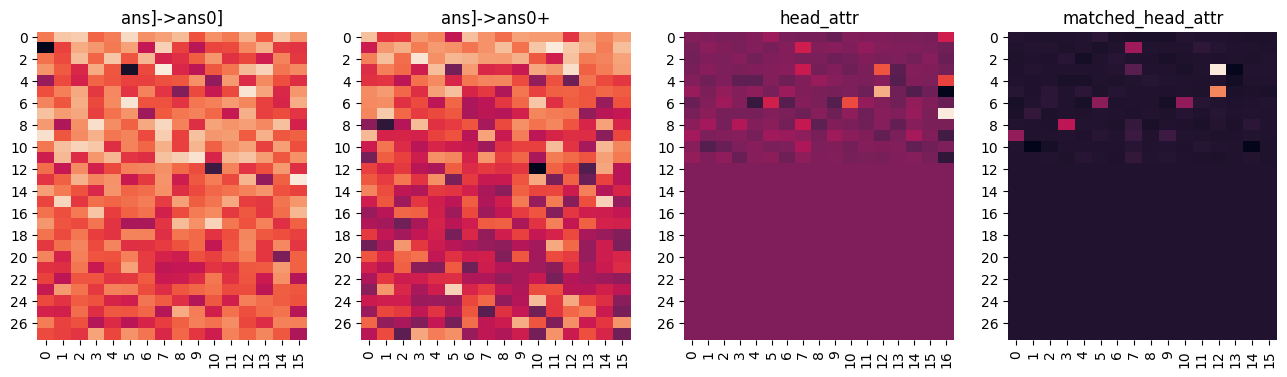

(array([ 3, 13,  6,  5, 11,  9,  8,  0,  8, 15]),
 array([ 7, 15,  5, 12,  9,  0,  3,  5,  7,  1]),
 array([-0.7408663 , -0.82177925, -0.99211776, -0.99960953, -1.0147696 ,
       -1.0846481 , -1.1120336 , -1.3045301 , -1.3536525 , -1.4159632 ],
      dtype=float32))
(array([ 1,  2,  3, 15, 23,  7,  1,  1,  6,  2]),
 array([11,  3, 12, 14,  5,  1, 12, 10, 10, 12]),
 array([-0.45876172, -0.6674943 , -0.77585876, -1.1123114 , -1.1477245 ,
       -1.292181  , -1.360568  , -1.4152813 , -1.4212046 , -1.5401304 ],
      dtype=float32))
(array([7, 5, 3, 6, 4, 6, 1, 0, 3, 8]),
 array([16, 12, 12, 10, 16,  5,  7, 16,  7,  7]),
 array([0.85277843, 0.653574  , 0.40451133, 0.37757128, 0.358612  ,
       0.24907212, 0.24412367, 0.240504  , 0.22025868, 0.21027657],
      dtype=float32))
(array([3, 5, 8, 1, 9, 6, 6, 3, 9, 9]),
 array([12, 12,  3,  7,  0, 10,  5,  7,  9,  7]),
 array([0.08944558, 0.06484558, 0.03723576, 0.03001407, 0.02758179,
       0.02713796, 0.02556876, 0.01372992, 0.00712178, 0.0

In [963]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [928]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

13 15
(0.8066678047180176, 0.9004504680633545)
axe->['chop'] {'Tree': 29, 'Ġtree': 28, 'tree': 27, 'Ġtrees': 27, 'ĠTree': 25}
car->['drive'] {'Ġtransportation': 29, 'Ġvehicles': 28, 'Ġvehicle': 28, 'Ġcars': 28, 'Ġveh': 27}
gun->['shoot'] {'Ġguns': 22, 'guns': 21, 'Ġgun': 21, 'Ġfirearms': 21, 'gun': 21}
pencil->['write'] {'Ġpencil': 19, 'Ġsketch': 16, 'Ġscrib': 16, 'Ġdrawings': 15, 'Ġhandwriting': 15}
oven->['bake'] {'Ġbaked': 29, 'Ġbaking': 28, 'Ġbake': 27, 'Ġcooking': 26, 'Ġoven': 26}
drill->['drill'] {'Ġdrilled': 23, 'Ġdrilling': 20, 'Ġholes': 20, 'Ġgroundwater': 18, 'Ġhole': 18}
TV->['watch'] {'ĠTelevision': 24, 'Ġtelevision': 24, 'TV': 23, 'ĠTV': 22, 'tv': 21}
dagger->['stab'] {'Ġdagger': 18, 'Ġknives': 15, 'Ġanchors': 14, 'Ġstabbing': 14, 'Ġknife': 14}
hammer->['hammer'] {'Ġnails': 20, 'Ġnail': 18, 'Ġmetals': 18, 'Ġgold': 17, 'Ġmetal': 16}
plane->['fly'] {'plane': 24, 'Ġplane': 22, 'planes': 20, 'Ġplanes': 20, 'ĠPlanes': 19}
lighter->['light'] {'Ġshine': 18, 'Ġburning': 18, 'Ġdark

In [955]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

5 12 qk
(-0.3945971131324768, 0.9673698544502258)
axe->['chop'] {'Ġwielding': -7, 'cutting': -8, 'Ġscissors': -8, 'Ġcutting': -9, 'Ġstabbing': -9}
car->['drive'] {'ĠNASCAR': -4, 'ĠVolkswagen': -6, 'ĠSubaru': -7, 'ĠYamaha': -8, 'Ġdashboard': -8}
gun->['shoot'] {'Ġammunition': 7, 'Ġprojectile': 4, 'ĠAmmunition': 3, 'Ġprojectiles': 3, 'Ġmuzzle': -1}
pencil->['write'] {'Ġstrokes': -3, 'Strike': -6, 'stab': -6, 'strike': -7, 'ãĢĤ': -8}
oven->['bake'] {'Temperature': -5, 'perature': -6, 'Ġtemperatures': -11, 'ĠTemperature': -11, 'ĠKelvin': -12}
TV->['watch'] {'steamapps': -4, 'Ġbroadcasters': -4, 'ĠBroadcasting': -5, 'Ġbroadcasting': -6, 'Ġcamer': -6}
dagger->['stab'] {'Ġstab': -5, 'stab': -5, 'Ġstabbing': -6, 'Ġstabbed': -6, 'Kill': -9}
plane->['fly'] {'Ġairstrikes': -1, 'ettel': -3, 'ĠTimbers': -4, 'selage': -5, 'Ġaerospace': -6}
violin->['play'] {'Ġplayable': -7, '-': -9, 'Apple': -10, 'plugins': -11, '.-': -11}
opener->['open'] {'----------': -10, '-----------': -11, 'ãĢĤ': -11, '.[': -1

In [964]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
                 ┌[0] top[0] 13-15 attn_labels┐
                 │                            └[1] top[0, 1] 8-1,12-10┐
                 │                                                    └[2] top[0, 1] 5-12,6-5
 [-1] root labels┤
                 └[0] top[3] 21-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0, 1] 3-12,5-12...


Bo has a TV. Carl has a violin. Bo's TV
Christopher has a piano. Morgan has a phone. Morgan's phone
August has a glider. Ruby has a phone. August's glider
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0, 1] 9-14,12-10
[-1] root labels


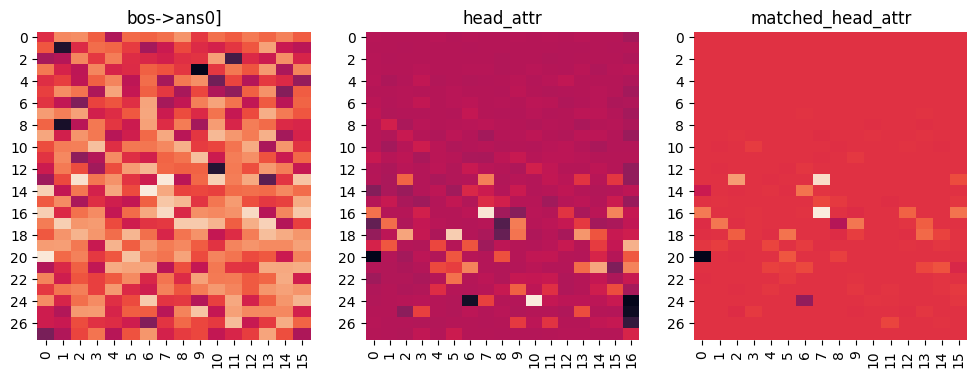

(array([14, 13, 20, 13, 16, 16, 17, 13, 14, 16]),
 array([ 6,  7,  0,  2, 12,  7, 13, 10,  0,  0]),
 array([-0.67910457, -0.73494   , -0.8150024 , -1.0380262 , -1.2517586 ,
       -1.2713937 , -1.4745697 , -1.519208  , -1.5411124 , -1.5599736 ],
      dtype=float32))
(array([24, 16, 18, 19, 21, 18, 18, 21, 21, 16]),
 array([10,  7,  5, 16, 14,  2, 13, 16,  6, 15]),
 array([0.7735991 , 0.75092703, 0.6598029 , 0.5622365 , 0.5258782 ,
       0.5206388 , 0.47235307, 0.41243085, 0.41176367, 0.41143954],
      dtype=float32))
(array([16, 13, 13, 16, 17, 17, 14, 18, 16, 18]),
 array([ 7,  7,  2,  0,  1,  9,  6,  5, 15, 13]),
 array([0.21059036, 0.19192813, 0.11227688, 0.07454718, 0.07133908,
       0.07103192, 0.06780844, 0.06750422, 0.06735991, 0.05855125],
      dtype=float32))
[0] top[0] 16-7 attn_labels


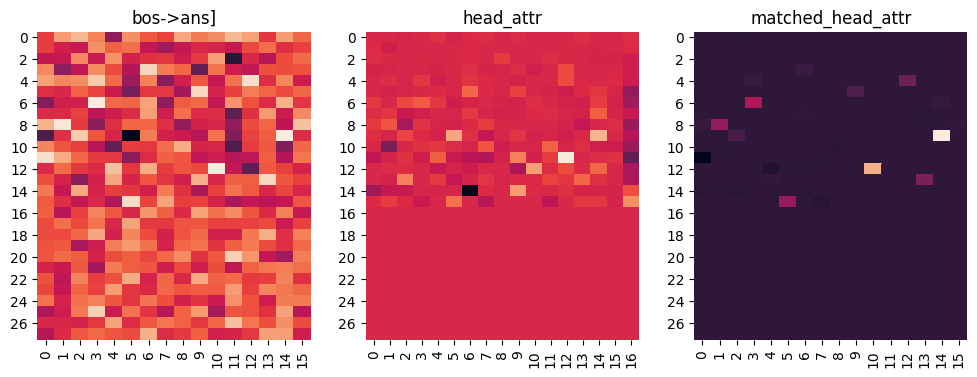

(array([ 9, 12,  6,  8,  4, 11, 15, 13,  5,  3]),
 array([14, 10,  3,  1, 12,  0,  5, 13,  9,  6]),
 array([-2.2278762, -2.2356546, -2.251869 , -2.3912618, -2.654726 ,
       -2.668902 , -2.7797756, -2.9263077, -2.9336903, -3.053412 ],
      dtype=float32))
(array([11,  9,  9, 12, 14, 15, 13, 11, 15,  5]),
 array([12, 14,  5, 10,  9, 16,  2,  9,  5,  6]),
 array([0.9266618 , 0.63918775, 0.5718337 , 0.53227293, 0.51859194,
       0.46144617, 0.39692974, 0.39038047, 0.3246578 , 0.28336564],
      dtype=float32))
(array([ 9, 12,  6, 15,  8, 13,  4,  5,  9,  4]),
 array([14, 10,  3,  5,  1, 13, 12,  9,  2,  3]),
 array([0.06887698, 0.05691175, 0.02456441, 0.02014581, 0.01888977,
       0.01499486, 0.01240979, 0.00641816, 0.00521322, 0.00250935],
      dtype=float32))
[1] top[0, 1] 9-14,12-10


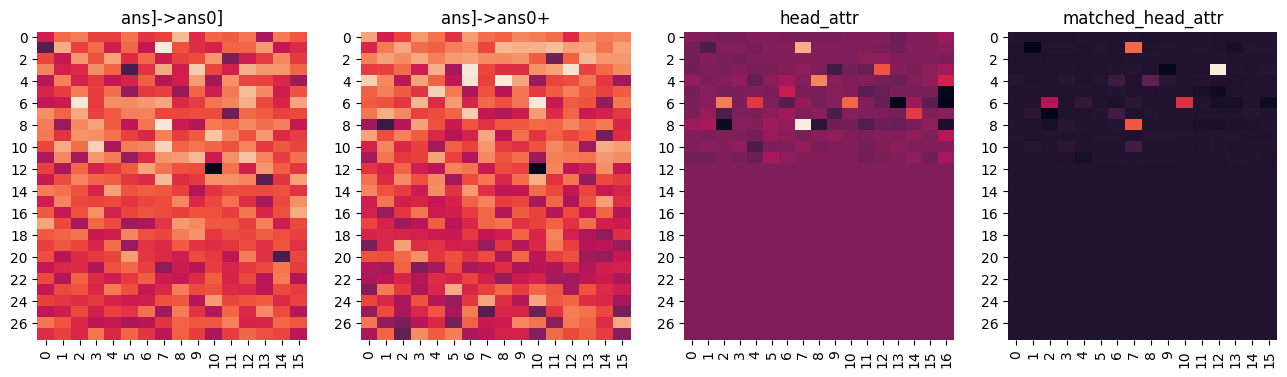

(array([ 1,  8,  6, 10, 10,  3,  9, 11,  5, 13]),
 array([ 7,  7,  2,  7,  3,  9, 10, 12, 12,  7]),
 array([-0.15963337, -0.28242573, -0.35037506, -1.0019914 , -1.0809895 ,
       -1.2719674 , -1.5390176 , -1.5510641 , -1.7296438 , -1.7780204 ],
      dtype=float32))
(array([4, 3, 6, 4, 3, 5, 4, 7, 1, 1]),
 array([ 8,  6, 10,  6, 12,  4,  0,  6, 11,  8]),
 array([-0.3162721 , -0.39403743, -0.40781894, -0.545773  , -0.58862334,
       -1.0567906 , -1.1152685 , -1.2206424 , -1.6136729 , -1.7733696 ],
      dtype=float32))
(array([8, 1, 4, 6, 6, 3, 7, 6, 4, 5]),
 array([ 7,  7,  8,  2, 10, 12, 14,  4, 16,  6]),
 array([0.7556468 , 0.5836636 , 0.46922296, 0.4515553 , 0.39892924,
       0.35807896, 0.29877338, 0.28938335, 0.22745417, 0.19539933],
      dtype=float32))
(array([ 3,  1,  8,  6,  6,  4, 10,  7,  4,  6]),
 array([12,  7,  7, 10,  2,  8,  7,  6,  6,  4]),
 array([0.08851093, 0.05785778, 0.05472214, 0.04574781, 0.03419513,
       0.01553258, 0.00857597, 0.00838605, 0.0072044 , 0.0

In [1061]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [1062]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 9-14,12-10┐
                                                                      └*[2] top[2, 1, 3, 0] 8-7,1-7,6-10,3-12...


[[(8, 7, -0.282)], [(9, 14, -2.228), (12, 10, -2.236)], [(16, 7, -1.271)]]


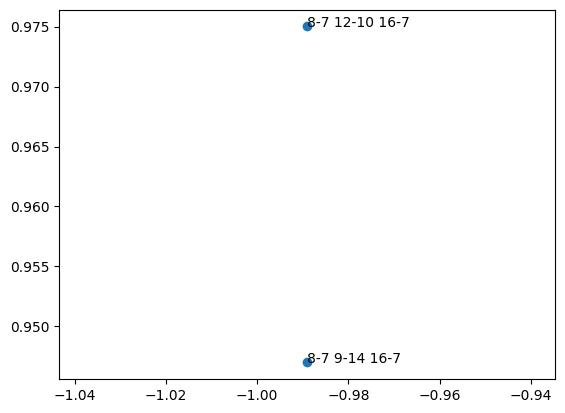

In [1063]:
analyze_head_chains(model, get_head2scores(node));

Bo has a glider. Carl has an axe. Bo can fly
Christopher has a piano. Morgan has a pencil. Morgan can write
August has a TV. Ruby has a pencil. August can watch
                 ┌[0] top[1] 21-14 argmax_attn_labels┐
                 │                                   └*[1] top[0, 1] 8-1,12-10┐
                 │                                                            └[2] top[1, 0] 5-12,3-12
 [-1] root labels┤
                 └[0] top[0] 13-15 argmax_attn_labels┐
                                                     └[1] top[0, 1] 8-1,12-10┐
                                                                             └[2] top[2, 3, 1, 0] 6-5,3-7,5-12,3-12
[-1] root labels


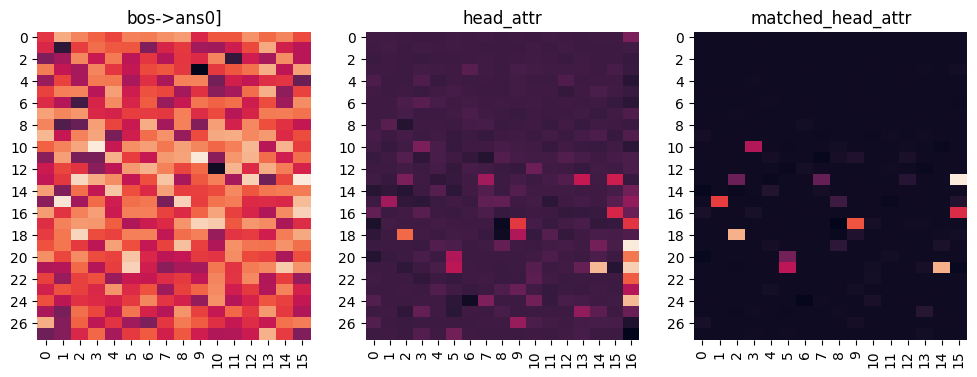

(array([13, 10, 11, 15, 13, 18, 17, 15, 21, 16]),
 array([15,  3,  9,  1,  2,  2,  9,  8,  5, 15]),
 array([-1.0261598, -1.0604143, -1.1139419, -1.2080406, -1.5832882,
       -1.6210164, -1.6938903, -1.7229264, -1.7323914, -1.7354193],
      dtype=float32))
(array([19, 21, 21, 24, 20, 18, 22, 17, 17, 16]),
 array([16, 16, 14, 16, 16,  2, 16,  9, 16, 15]),
 array([0.6515068 , 0.59305984, 0.5506436 , 0.54804575, 0.4310616 ,
       0.40676716, 0.3856864 , 0.32572177, 0.32144114, 0.2896887 ],
      dtype=float32))
(array([13, 21, 18, 17, 15, 16, 21, 10, 20, 13]),
 array([15, 14,  2,  9,  1, 15,  5,  3,  5,  2]),
 array([0.09532356, 0.08046097, 0.08041691, 0.05986866, 0.05541629,
       0.05107973, 0.04191212, 0.03986681, 0.02547992, 0.02365257],
      dtype=float32))
[0] top[1] 21-14 argmax_attn_labels


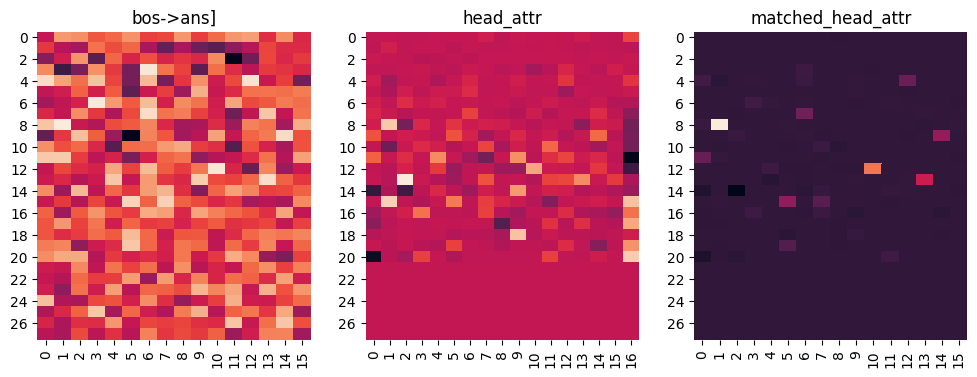

(array([ 8,  6,  3, 12,  4, 13,  7,  4,  9, 15]),
 array([ 1,  3,  6, 10, 12, 13,  6,  0, 14,  5]),
 array([-1.9203614, -1.9865654, -2.0768743, -2.095127 , -2.2192228,
       -2.3512232, -2.3534014, -2.3722172, -2.470023 , -2.6625638],
      dtype=float32))
(array([13, 15, 20,  8, 15, 18, 17, 12, 14, 19]),
 array([ 2,  1, 16,  1, 16,  9, 16, 10,  9, 16]),
 array([43.437767, 37.39757 , 36.92359 , 35.75357 , 34.45647 , 34.385223,
       28.866737, 28.625097, 25.895374, 24.686296], dtype=float32))
(array([ 8, 12, 13,  9, 15,  7,  4, 11, 15, 19]),
 array([ 1, 10, 13, 14,  5,  6, 12,  0,  7,  5]),
 array([5.2398286 , 3.52245   , 2.2440042 , 1.472347  , 1.3994066 ,
       0.97918457, 0.84761   , 0.7988474 , 0.5908859 , 0.4991852 ],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


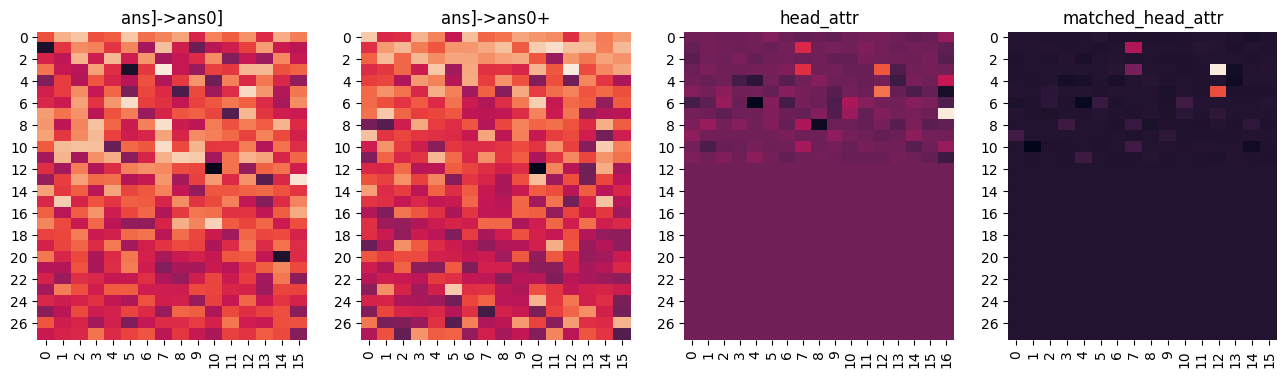

(array([ 3, 13,  8,  6, 10,  5, 17, 11, 15, 11]),
 array([ 7, 15,  7,  5,  7, 12, 10,  8,  1,  9]),
 array([-0.83268255, -1.0278571 , -1.1490549 , -1.1945658 , -1.2268069 ,
       -1.2950945 , -1.521209  , -1.605803  , -1.664125  , -1.7416573 ],
      dtype=float32))
(array([ 3,  1,  6,  1, 10,  0, 23,  7,  3, 15]),
 array([12, 11, 10, 10, 14,  0,  5,  1,  4, 14]),
 array([-1.2190683, -1.5157518, -1.8852134, -1.9236264, -1.9613287,
       -1.9741857, -1.9853134, -2.0315382, -2.0433726, -2.151637 ],
      dtype=float32))
(array([ 7,  5,  3,  3,  1,  4,  8,  6, 10,  7]),
 array([16, 12, 12,  7,  7, 16,  7, 10,  7, 10]),
 array([91.057396, 53.0333  , 46.136307, 34.759933, 32.387978, 25.15246 ,
       18.020742, 16.864248, 16.091612, 12.360432], dtype=float32))
(array([ 3,  5,  1,  3,  9,  6, 10, 11,  8,  6]),
 array([12, 12,  7,  7,  0, 10,  7,  4,  3,  5]),
 array([8.176075  , 4.812926  , 3.0551093 , 1.922856  , 0.7764457 ,
       0.70986336, 0.6840487 , 0.6515384 , 0.63267046, 0.5203662

In [1042]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [988]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

*Ġplay 0.133 {'Ġplay': 0.133, 'Ġshoot': 0.058, 'âĢ': 0.057} 	 Justice has a piano. Chance has a gun. Justice can play
*Ġbake 0.241 {'Ġbake': 0.241, 'Ġfly': 0.136, 'Ġcook': 0.128} 	 Tyler has an oven. London has a plane. Tyler can bake
 Ġfly 0.04 {'Ġprint': 0.727, 'Ġtype': 0.046, 'Ġfly': 0.04} 	 India has a printer. Eva has a glider. Eva can fly
*Ġwash 0.606 {'Ġwash': 0.606, 'Ġdry': 0.074, 'Ġclean': 0.062} 	 Jamie has a phone. Dream has washing machine. Dream can wash
 Ġstab 0.219 {'Ġopen': 0.324, 'Ġstab': 0.219, 'Ġcut': 0.21} 	 Angel has an opener. Laura has a dagger. Laura can stab
 Ġwatch 0.0 {'Ġstab': 0.975, 'Ġkill': 0.005, 'Ġcut': 0.002} 	 Anna has a TV. Michael has a dagger. Anna can watch
 Ġcut 0.077 {'Ġcook': 0.286, 'Ġsaw': 0.119, 'Ġchop': 0.082} 	 King has a saw. Amy has a pot. King can cut
 Ġcook 0.075 {'Ġdrive': 0.37, 'Ġcook': 0.075, 'Ġfix': 0.045} 	 Georgia has a pot. Thomas has a car. Georgia can cook
3.0769495964050293
 Ġchop 0.063 {"'t": 0.073, 'âĢ': 0.069, 'Ġchop': 0.063

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [1047]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
                 ┌[0] top[1] 21-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └*[2] top[1, 2, 0] 5-12,1-7,3-12...
 [-1] root labels┤
                 └[0] top[0] 13-15 argmax_attn_labels┐
                                                     └[1] top[0, 1] 8-1,12-10┐
                                                                             └[2] top[2, 3, 1, 0] 6-5,3-7,5-12,3-12


[[(5, 12, -1.295)], [(8, 1, -1.92), (12, 10, -2.095)], [(21, 14, -1.923)]]


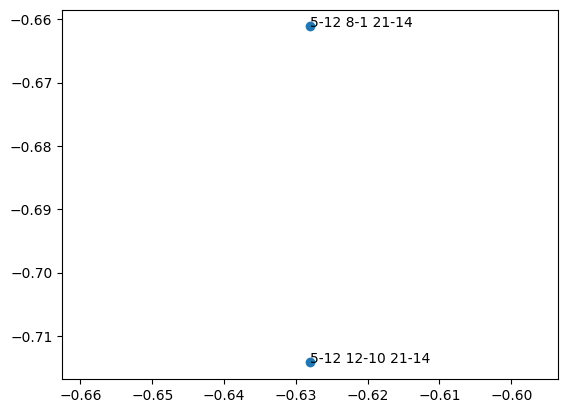

In [1028]:
analyze_head_chains(model, get_head2scores(node));

[[(6, 5, -1.195), (3, 7, -0.833), (5, 12, -1.295)], [(8, 1, -1.92), (12, 10, -2.095)], [(13, 15, -1.026)]]


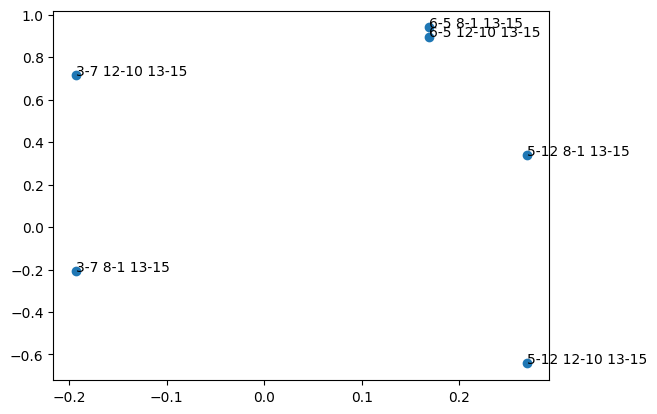

In [981]:
analyze_head_chains(model, get_head2scores(node));

### capital->country

In [470]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=0): 0.068, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=1, abstract=1): 0.111, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0): 0.866, 0.65625
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=1): 1.251, 0.5
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0): 0.093, 0.84375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=1): 0.119, 0.8125
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0): 1.386, 0.4375
MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=1): 2.561, 0.4375


Angelo lives in Canberra. Angelo is from Australia
Emily lives in Bern. Emily is from Switzerland
Leon lives in Rome. Leon is from Italy
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              │                                        ┌[2] top[0, 1] 5-12,8-3
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┤
                                                                                       └*[2] top[0, 1, 2, 3] 5-12,8-3,1-7,6-10...
[-1] root labels


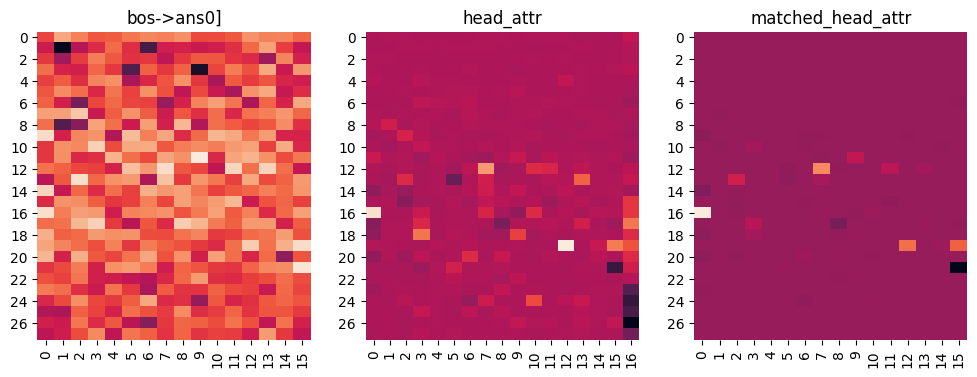

(array([11, 21, 13, 16, 12,  9, 19, 12, 14, 12]),
 array([ 9, 15,  2,  0,  7,  0, 15, 11,  0, 13]),
 array([-0.21577224, -0.45070654, -0.5740944 , -0.59576213, -0.68915856,
       -0.72982705, -0.745999  , -0.956928  , -0.9940366 , -1.0468302 ],
      dtype=float32))
(array([19, 16, 12, 19, 17, 18, 13, 19, 24, 18]),
 array([12,  0,  7, 15, 16,  3, 13, 16, 10,  9]),
 array([1.6328077 , 1.5465269 , 1.0320864 , 0.8404534 , 0.80687124,
       0.8045759 , 0.68991804, 0.59838754, 0.55406755, 0.50006294],
      dtype=float32))
(array([16, 12, 19, 19, 13, 11, 12, 17, 13, 12]),
 array([ 0,  7, 12, 15,  2,  9, 11,  3,  7, 13]),
 array([0.85235643, 0.5181056 , 0.43699065, 0.39859366, 0.19187868,
       0.14302027, 0.12064658, 0.10697585, 0.04785806, 0.04387965],
      dtype=float32))
[0] top[2] 19-12 attn_labels


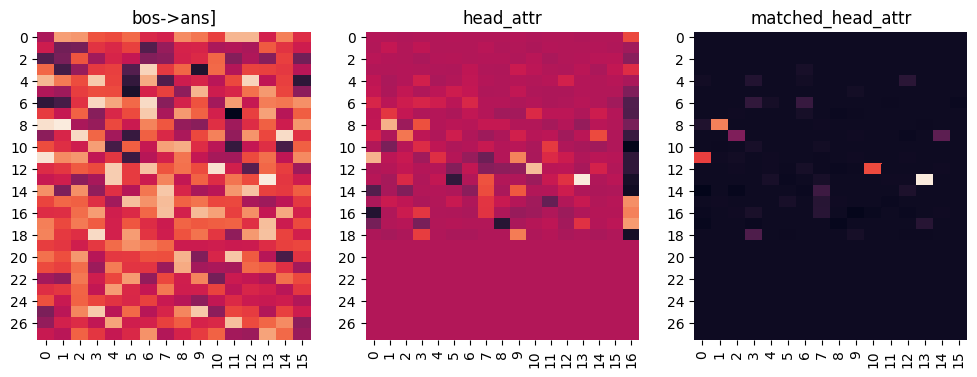

(array([13,  8, 11, 12,  8,  9,  6, 18,  9,  6]),
 array([13,  1,  0, 10,  0, 14,  6,  3,  2,  3]),
 array([-2.1104734, -2.1118917, -2.341813 , -2.3623142, -2.4106543,
       -2.5359712, -2.5639296, -2.565811 , -2.6123538, -2.6466293],
      dtype=float32))
(array([13, 12, 11,  8, 17, 15, 11, 16, 18,  9]),
 array([13, 10,  0,  1, 16, 16,  9, 16,  9,  2]),
 array([1.4362833 , 1.1206292 , 1.0599738 , 1.0442073 , 0.9130223 ,
       0.84071916, 0.766217  , 0.75772417, 0.7288693 , 0.7030485 ],
      dtype=float32))
(array([13,  8, 12, 11,  9,  9, 18, 14,  6,  6]),
 array([13,  1, 10,  0,  2, 14,  3,  7,  6,  3]),
 array([0.17404966, 0.1263583 , 0.10556547, 0.10191982, 0.05157681,
       0.03676775, 0.03060382, 0.02232917, 0.01978488, 0.01676363],
      dtype=float32))
[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0


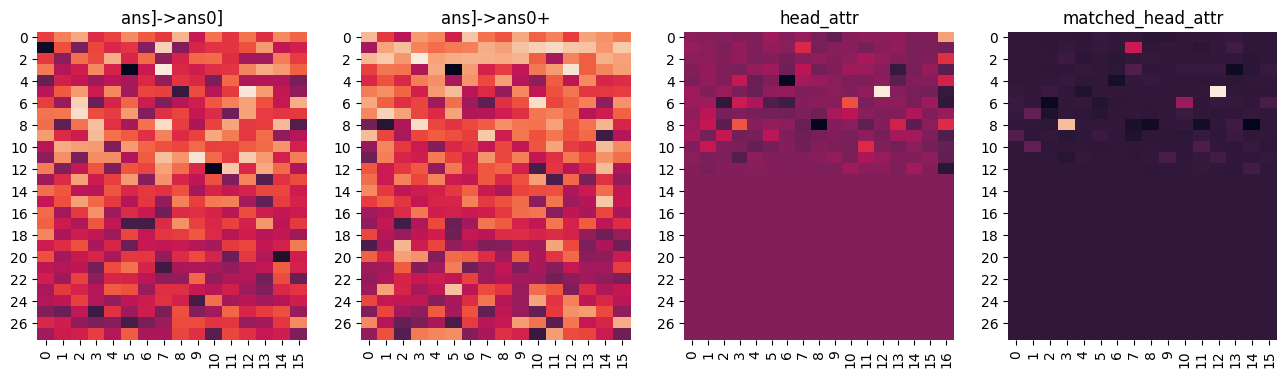

(array([ 3,  5, 11,  7,  8,  1,  6, 11, 12, 11]),
 array([ 7, 12,  9,  2,  7,  7,  2, 12, 11,  7]),
 array([-0.72030103, -0.8439094 , -0.9205216 , -1.0588219 , -1.0695171 ,
       -1.4008708 , -1.4046199 , -1.578186  , -1.6389456 , -1.8323461 ],
      dtype=float32))
(array([2, 3, 6, 8, 1, 7, 1, 1, 2, 9]),
 array([ 3, 12, 10,  3, 11,  1, 10, 15,  1,  7]),
 array([-1.0059502, -1.1935498, -1.3136737, -1.3876293, -1.442794 ,
       -1.5962044, -1.6511365, -1.7942752, -1.8059132, -1.8354278],
      dtype=float32))
(array([ 5,  0,  8,  6,  2,  8, 10,  1,  8,  4]),
 array([12, 16,  3, 10, 16, 16, 11,  7, 13, 16]),
 array([0.81726795, 0.583975  , 0.38171187, 0.3774796 , 0.28694302,
       0.2736831 , 0.2654661 , 0.25668615, 0.23239286, 0.23171113],
      dtype=float32))
(array([ 5,  8,  1,  6,  7, 10,  9,  3, 10, 11]),
 array([12,  3,  7, 10,  1,  1,  0,  7, 11,  9]),
 array([0.08826026, 0.07610155, 0.03723093, 0.02574   , 0.01252321,
       0.01186608, 0.00868085, 0.00799938, 0.00760066, 0.0

In [871]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [843]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

16 0
(0.9464224576950073, 0.9693313837051392)
Berlin->['Germany'] {'ĠBerlin': 34, 'ĠFriedrich': 22, 'ĠGermany': 19, 'ĠReich': 19, 'ĠGerman': 19}
Cairo->['Egypt'] {'ĠCairo': 40, 'Egypt': 39, 'ĠEgypt': 39, 'ĠEgyptian': 38, 'ĠEgyptians': 37}
Ankara->['Turkey'] {'ĠAnkara': 42, 'ĠTurkish': 38, 'ĠErdogan': 37, 'ĠTurkey': 36, 'Turkish': 35}
Athens->['Greece'] {'ĠAthens': 42, 'ĠAthen': 33, 'ĠAthena': 30, 'ĠGreece': 30, 'ĠGreek': 29}
London->['England'] {'ĠLondon': 26, 'London': 26, 'ĠNotting': 25, 'ĠThames': 24, 'ĠBarcl': 19}
Manila->['the Philippines'] {'ĠManila': 34, 'ĠFilipino': 31, 'ĠPhilippines': 31, 'ĠPhilippine': 29, 'ĠFilip': 27}
Ottawa->['Canada'] {'ĠOttawa': 36, 'Ott': 26, 'ĠCanadians': 24, 'ĠCanadian': 24, 'ĠQuebec': 22}
Bern->['Switzerland'] {'Bern': 30, 'ĠBernstein': 30, 'ĠBern': 25, 'bern': 24, 'ĠBernard': 21}
Seoul->['South Korea'] {'ĠSeoul': 39, 'ĠKoreans': 36, 'ĠKorean': 36, 'ĠKorea': 33, 'ĠYong': 29}
Lisbon->['Portugal'] {'ĠLisbon': 40, 'ĠPortuguese': 38, 'ĠPortugal': 37, 'ĠP

In [875]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[2] 19-12 attn_labels┐
                                              └[1] top[0, 1, 2, 3] 13-13,8-1,12-10,11-0┐
                                                                                       └*[2] top[0] 5-12...


Bo lives in Athens. Carl lives in Berlin. Bo is from Athens
Christopher lives in Mexico City. Morgan lives in Ottawa. Morgan is from Ottawa
August lives in Berlin. Ruby lives in Canada. August is from Berlin
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1, 2, 3, 4] 6-2,1-7,3-12,8-7,6-10...
[-1] root labels


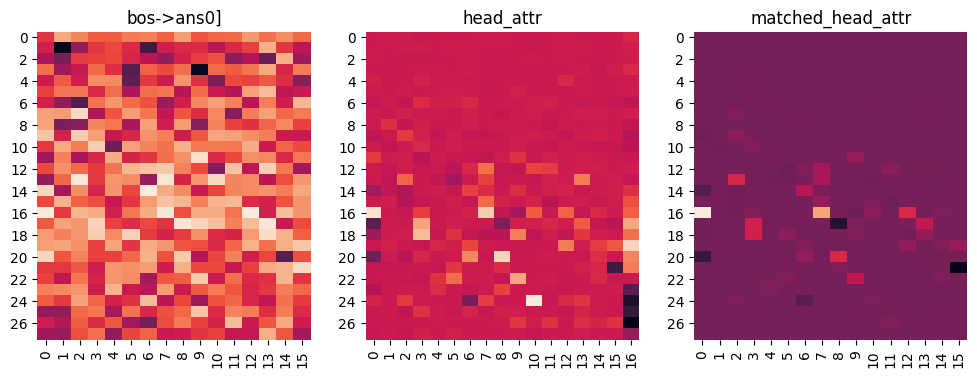

(array([16, 14, 16, 13, 16, 17, 17, 13, 11, 21]),
 array([ 0,  6, 12,  2,  7, 13,  8,  7,  9, 15]),
 array([-1.3288975, -1.3305348, -1.3627592, -1.4088558, -1.4976463,
       -1.499613 , -1.5131693, -1.5281231, -1.6476071, -1.8046031],
      dtype=float32))
(array([24, 16, 20, 19, 16, 18, 17, 22, 17, 20]),
 array([10,  0,  8, 16,  7,  3, 16,  9,  3,  6]),
 array([0.83582604, 0.8029555 , 0.7381003 , 0.73617625, 0.6969557 ,
       0.62472516, 0.5496335 , 0.53898   , 0.5320116 , 0.42316008],
      dtype=float32))
(array([16, 16, 20, 16, 13, 17, 18, 17, 22, 14]),
 array([ 0,  7,  8, 12,  2,  3,  3, 13,  9,  6]),
 array([0.21259774, 0.15587829, 0.07418858, 0.07292817, 0.07134783,
       0.06707115, 0.06559796, 0.05751253, 0.05405492, 0.04663789],
      dtype=float32))
[0] top[0, 1] 16-0,16-7 attn_labels


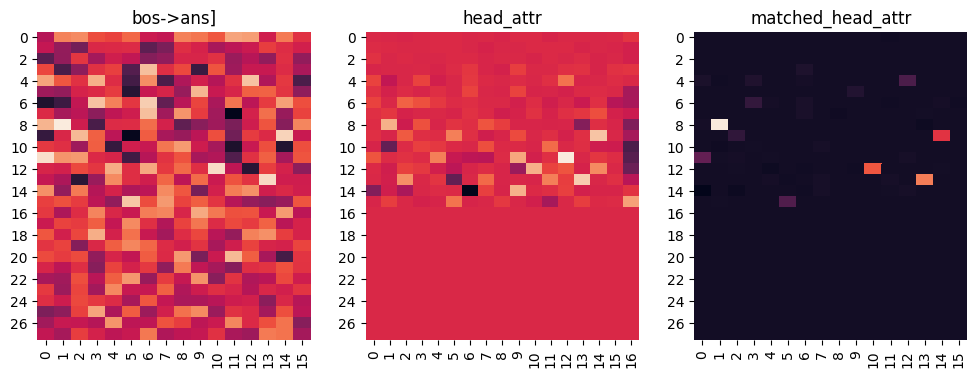

(array([ 8, 11, 12, 13,  9,  6, 15,  6,  4,  3]),
 array([ 1,  0, 10, 13, 14,  6,  5,  3, 12,  6]),
 array([-1.9514141, -2.3488255, -2.4113407, -2.489871 , -2.6965308,
       -2.8692653, -3.103426 , -3.1731105, -3.1838531, -3.2478652],
      dtype=float32))
(array([11, 13,  9, 14,  8, 12, 11, 15, 13, 12]),
 array([12, 13, 14,  9,  1, 10,  9, 16,  2, 14]),
 array([1.2294738 , 1.0032799 , 0.9460625 , 0.81965804, 0.8191863 ,
       0.81483126, 0.7492655 , 0.7142401 , 0.6066006 , 0.5751997 ],
      dtype=float32))
(array([ 8, 13, 12,  9, 11, 15,  4,  6,  9,  5]),
 array([ 1, 13, 10, 14,  0,  5, 12,  3,  2,  9]),
 array([0.11638427, 0.08319264, 0.07308626, 0.06380157, 0.02548152,
       0.01938173, 0.01808166, 0.01033581, 0.00938567, 0.00518399],
      dtype=float32))
[1] top[0, 1, 2] 8-1,13-13,12-10


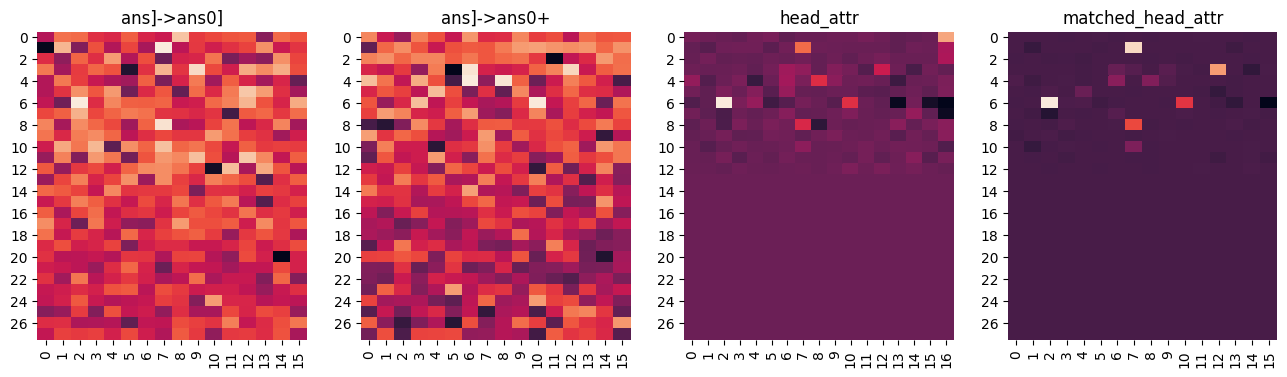

(array([ 6,  1,  8,  3, 11,  5,  0, 10, 11, 12]),
 array([ 2,  7,  7,  9, 12, 12,  8,  7,  9, 11]),
 array([-0.29563287, -0.29856926, -0.5963911 , -0.858142  , -1.4844072 ,
       -1.4849362 , -1.5643399 , -1.6877527 , -1.7045727 , -1.766141  ],
      dtype=float32))
(array([4, 6, 4, 3, 3, 4, 6, 5, 4, 1]),
 array([ 6, 10,  8,  6, 12,  0,  3,  4,  3, 10]),
 array([-0.41375035, -0.46466488, -0.57811064, -0.6015241 , -0.9390356 ,
       -1.5189505 , -1.528825  , -1.5703702 , -1.9797645 , -2.196197  ],
      dtype=float32))
(array([6, 0, 1, 6, 4, 8, 3, 2, 1, 4]),
 array([ 2, 16,  7, 10,  8,  7, 12, 16, 16,  6]),
 array([1.5166017 , 1.1418262 , 0.8637782 , 0.6062534 , 0.5906905 ,
       0.5521585 , 0.47588474, 0.31910214, 0.29902315, 0.26566285],
      dtype=float32))
(array([ 6,  1,  3,  8,  6,  4,  4, 10,  5,  3]),
 array([ 2,  7, 12,  7, 10,  6,  8,  7,  4,  6]),
 array([0.12341819, 0.11587791, 0.09278938, 0.06545615, 0.05880314,
       0.02373844, 0.02093031, 0.01953756, 0.01284882, 0.0

In [876]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [880]:
print(key); node = add_node_to_result(result, topi=[0,1])

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0, 1] 16-0,16-7 attn_labels┐
                                                     └[1] top[0, 1, 2] 8-1,13-13,12-10┐
                                                                                      └*[2] top[0, 1] 6-2,1-7...


[[(6, 2, -0.296)], [(8, 1, -1.951), (13, 13, -2.49), (12, 10, -2.411)], [(16, 0, -1.329), (16, 7, -1.498)]]


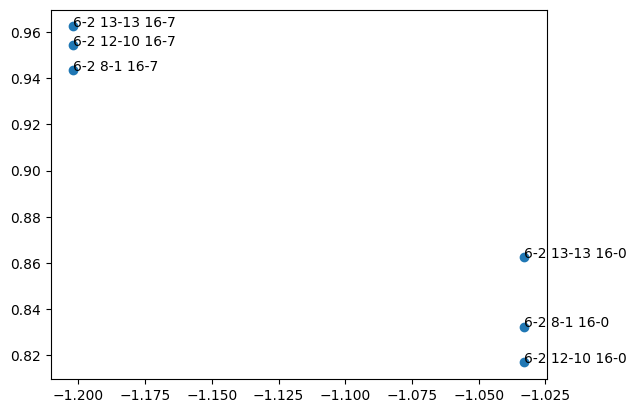

In [881]:
analyze_head_chains(model, get_head2scores(node));

Bo lives in Brasília. Carl lives in Mexico City. Bo is from Brazil
Christopher lives in Bangkok. Morgan lives in Ottawa. Morgan is from Canada
August lives in Beijing. Ruby lives in Moscow. August is from China
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...
[-1] root labels


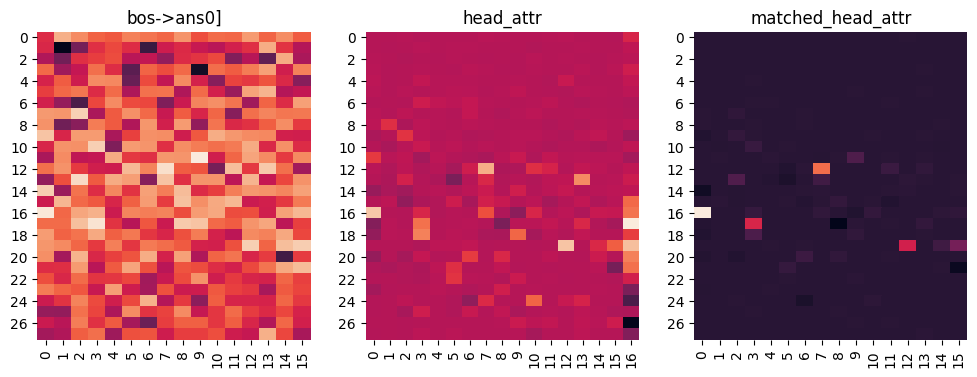

(array([11, 16, 17, 12, 13,  7, 10, 19, 19, 14]),
 array([ 9,  0,  3,  7,  2,  2,  3, 12, 15,  0]),
 array([-1.1805654, -1.2904716, -1.437311 , -1.5688195, -1.6804394,
       -2.0120149, -2.0358503, -2.0490222, -2.0688548, -2.0724943],
      dtype=float32))
(array([17, 16, 19, 19, 12, 13, 20, 18, 16, 21]),
 array([16,  0, 12, 16,  7, 13, 16,  3, 16, 16]),
 array([0.8685818 , 0.7155201 , 0.7043894 , 0.6862899 , 0.6186234 ,
       0.4928573 , 0.4540257 , 0.45271584, 0.40817076, 0.4015888 ],
      dtype=float32))
(array([16, 12, 17, 19, 19, 13, 11, 18, 13, 19]),
 array([ 0,  7,  3, 12, 15,  2,  9,  3,  7, 14]),
 array([0.19686891, 0.12885363, 0.0947455 , 0.09076821, 0.04233965,
       0.02215736, 0.02180293, 0.02030192, 0.01336572, 0.0123677 ],
      dtype=float32))
[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels


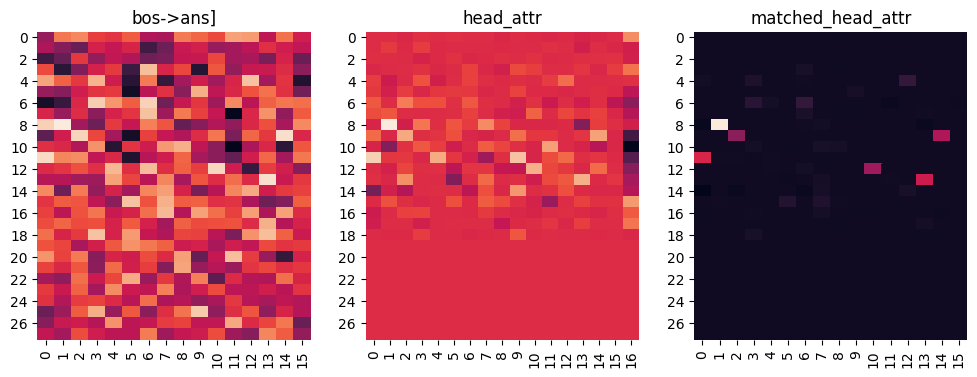

(array([ 8, 13,  9, 11, 12,  9,  6,  8,  6, 25]),
 array([ 1, 13, 14,  0, 10,  2,  6,  0,  3,  9]),
 array([-1.7855884, -2.0952206, -2.130491 , -2.2637904, -2.3503032,
       -2.4313354, -2.5269203, -2.5658863, -2.6493416, -2.7442076],
      dtype=float32))
(array([ 8, 11, 11, 12, 13, 11,  9,  9, 10, 15]),
 array([ 1,  0,  9, 10, 13,  4,  2, 14, 11, 16]),
 array([125.75547 , 104.74787 ,  95.36834 ,  82.49108 ,  82.20734 ,
        78.589676,  76.4427  ,  72.20157 ,  71.51051 ,  67.07172 ],
      dtype=float32))
(array([ 8, 11, 13,  9, 12,  9,  6,  4,  6, 15]),
 array([ 1,  0, 13, 14, 10,  2,  6, 12,  3,  5]),
 array([21.088987 , 10.889139 , 10.115046 ,  8.576027 ,  7.8647203,
        6.720792 ,  2.117462 ,  2.078264 ,  1.4833612,  1.1182349],
      dtype=float32))
[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10


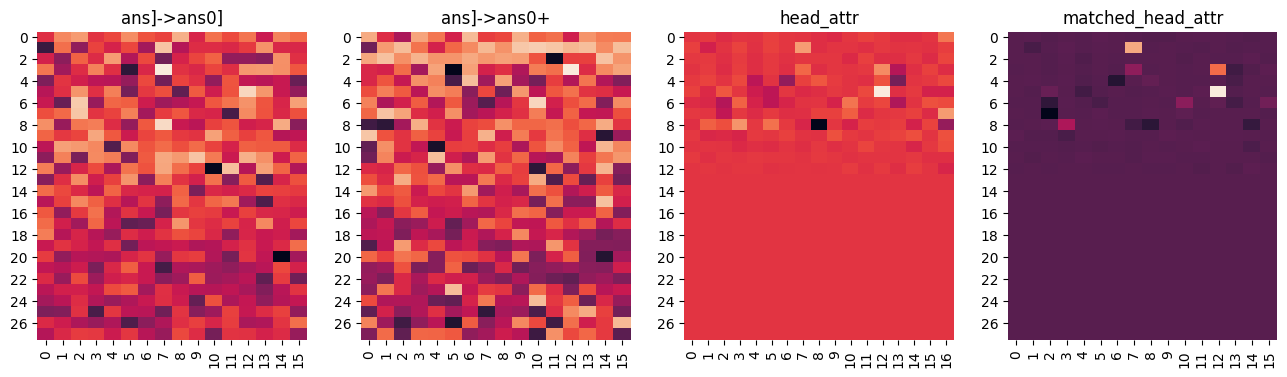

(array([ 3,  8,  5,  6,  7,  1, 11, 12, 11,  0]),
 array([ 7,  7, 12,  2,  2,  7,  9, 11, 12,  8]),
 array([-0.61562794, -1.1192677 , -1.2378955 , -1.5842346 , -1.7106717 ,
       -1.7589614 , -1.7813857 , -1.8983191 , -2.3354354 , -2.3577268 ],
      dtype=float32))
(array([ 3,  6,  1,  1,  9,  1,  2,  7,  2, 15]),
 array([12, 10, 10,  9,  0, 11, 14,  1,  1, 14]),
 array([-1.4686711, -1.9352639, -2.1320124, -2.2571776, -2.260981 ,
       -2.2744708, -2.32167  , -2.3365078, -2.3607073, -2.3668222],
      dtype=float32))
(array([5, 1, 7, 8, 3, 0, 6, 8, 3, 6]),
 array([12,  7, 16,  3, 12, 16, 10,  5,  7,  3]),
 array([187.65778 ,  97.962555,  96.05014 ,  90.71257 ,  80.564354,
        60.32404 ,  59.1686  ,  55.56412 ,  47.260704,  41.657387],
      dtype=float32))
(array([5, 1, 3, 8, 3, 6, 6, 5, 4, 6]),
 array([12,  7, 12,  3,  7, 10, 15,  2,  8, 12]),
 array([14.483035  , 11.292467  ,  8.700681  ,  3.7441878 ,  2.4364793 ,
        2.2838955 ,  1.201804  ,  0.7948787 ,  0.55621827,  0.3

In [802]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [677]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 16-0,12-7,19-12 attn_labels┐
                 │                                            └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                 │                                                                                             └[2] top[0, 1, 3] 5-12,3-12,1-7
 [-1] root labels┤
                 └[0] top[0, 1, 3] 16-0,12-7,19-12 argmax_attn_labels┐
                                                                     └[1] top[0, 1, 2, 3, 4] 8-1,11-0,13-13,9-14,12-10┐
                                                                                                                      └*[2] top[0, 1, 2] 5-12,1-7,3-12...


[[(5, 12, -1.238)], [(8, 1, -1.786), (11, 0, -2.264), (13, 13, -2.095), (9, 14, -2.13), (12, 10, -2.35)], [(16, 0, -1.29), (12, 7, -1.569), (19, 12, -2.049)]]


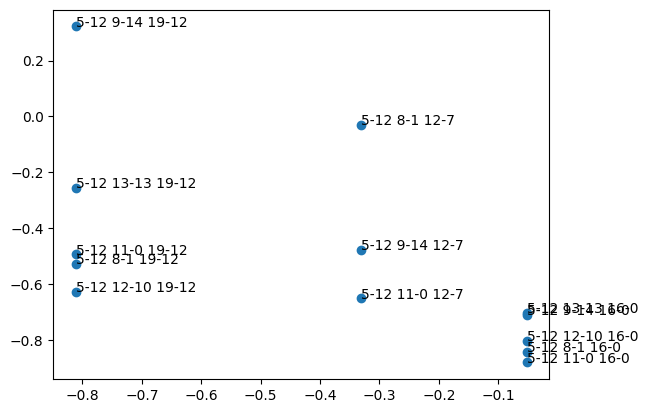

[(((5, 12), (8, 1), (16, 0)), -0.8428910970687866, -0.051999927),
 (((5, 12), (8, 1), (12, 7)), -0.030665799975395203, -0.33099997),
 (((5, 12), (8, 1), (19, 12)), -0.5285608768463135, -0.811),
 (((5, 12), (11, 0), (16, 0)), -0.8814032077789307, -0.051999927),
 (((5, 12), (11, 0), (12, 7)), -0.6516086459159851, -0.33099997),
 (((5, 12), (11, 0), (19, 12)), -0.4943164885044098, -0.811),
 (((5, 12), (13, 13), (16, 0)), -0.7047533988952637, -0.051999927),
 (((5, 12), (13, 13), (19, 12)), -0.25689059495925903, -0.811),
 (((5, 12), (9, 14), (16, 0)), -0.7109839916229248, -0.051999927),
 (((5, 12), (9, 14), (12, 7)), -0.4771130084991455, -0.33099997),
 (((5, 12), (9, 14), (19, 12)), 0.3221599757671356, -0.811),
 (((5, 12), (12, 10), (16, 0)), -0.8043627142906189, -0.051999927),
 (((5, 12), (12, 10), (19, 12)), -0.628407895565033, -0.811)]

In [806]:
analyze_head_chains(model, get_head2scores(node))

### person_adjs.opposite

In [343]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.027, 0.9375
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.102, 0.90625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0): 1.261, 0.5625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=1): 1.538, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0): 0.451, 0.625
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=1): 0.349, 0.75
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0): 3.566, 0.3125
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=1): 3.773, 0.25


Joy is hardworking. So Joy's not lazy
Anne is harsh. So Anne's not gentle
Morgan is rational. So Morgan's not irrational
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └*[1] top[0, 1] 8-1,12-10
[-1] root labels


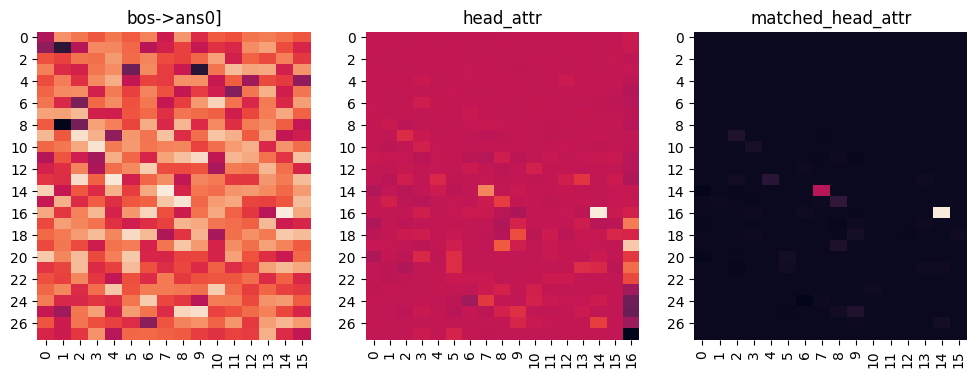

(array([16, 14, 13, 15, 10,  9, 25, 13, 11, 18]),
 array([14,  7,  4,  8,  3,  2,  9,  2,  9,  5]),
 array([-0.22404538, -0.26426464, -0.32291535, -0.47671288, -0.52815974,
       -0.5657489 , -0.6306189 , -0.758794  , -0.7767543 , -0.8513253 ],
      dtype=float32))
(array([16, 19, 14, 17, 21, 19, 18, 22, 26, 15]),
 array([14, 16,  7, 16, 16,  8,  9, 16, 14,  8]),
 array([1.7829967 , 1.4742178 , 0.92033106, 0.8625574 , 0.7433384 ,
       0.6010051 , 0.5150038 , 0.48811558, 0.40587863, 0.3955037 ],
      dtype=float32))
(array([16, 14, 15, 13, 25,  9, 19, 10, 18, 26]),
 array([14,  7,  8,  4,  9,  2,  8,  3,  9, 14]),
 array([7.9581943 , 3.4826114 , 0.8296476 , 0.6714766 , 0.47457597,
       0.46025598, 0.40867478, 0.27440712, 0.25377205, 0.2051951 ],
      dtype=float32))
[0] top[0] 16-14 attn_labels


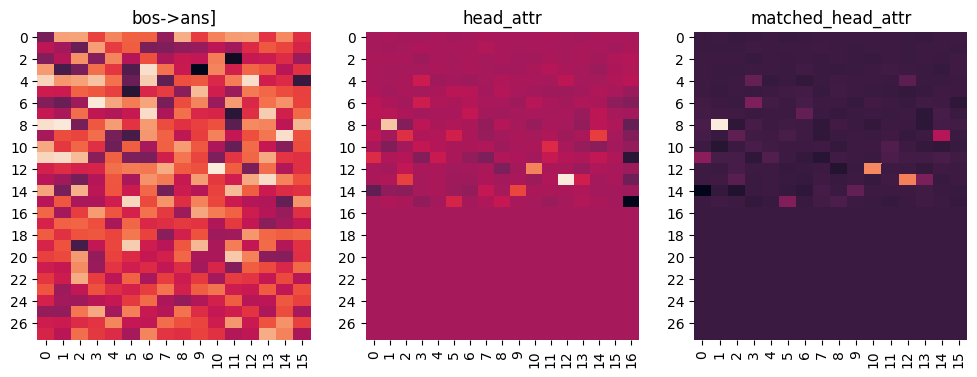

(array([12,  6,  8,  8,  3,  4,  9,  7, 13, 11]),
 array([10,  3,  1,  0,  6, 12, 14,  6, 13,  1]),
 array([-2.0619197, -2.147152 , -2.1584582, -2.3844886, -2.3936834,
       -2.3952484, -2.4289227, -2.4505653, -2.4905105, -2.51614  ],
      dtype=float32))
(array([13,  8, 12, 14, 13,  9,  9, 11, 10, 15]),
 array([12,  1, 10,  9,  2, 14,  2,  0, 11,  5]),
 array([2.1855073 , 1.794246  , 1.2097158 , 0.75793827, 0.69399714,
       0.6832046 , 0.5568255 , 0.5192549 , 0.5060235 , 0.4414171 ],
      dtype=float32))
(array([ 8, 12, 13,  9, 11, 15,  6, 13,  4,  7]),
 array([ 1, 10, 12, 14,  0,  5,  3, 13,  3,  6]),
 array([0.83126277, 0.58669394, 0.5659246 , 0.28127885, 0.19405212,
       0.16885033, 0.15801533, 0.15140642, 0.10328428, 0.0972256 ],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


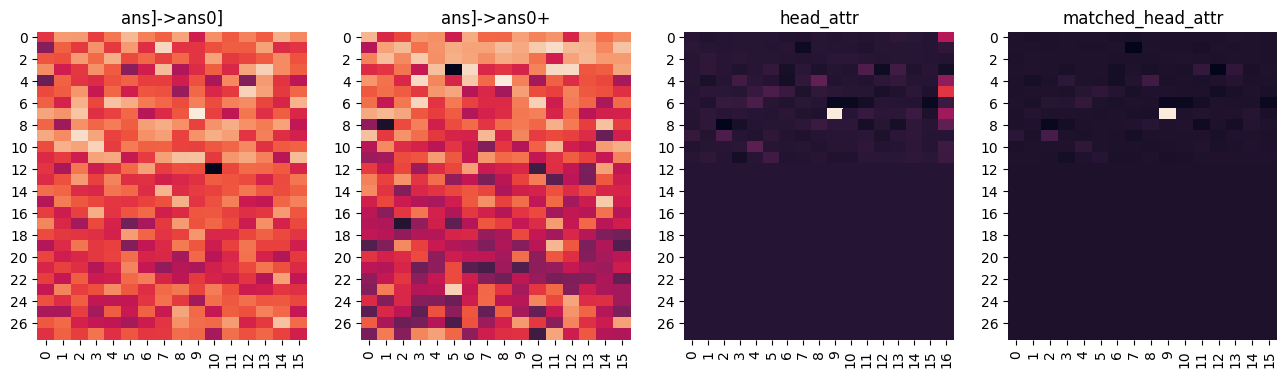

(array([ 7,  9,  1, 10,  5,  3,  7,  6, 26, 11]),
 array([ 9,  2,  7,  3, 12, 13,  2,  4, 14,  9]),
 array([-0.4647833 , -0.91090393, -1.0842161 , -1.2195952 , -1.2474614 ,
       -1.2913882 , -1.6618898 , -1.7153547 , -1.7185242 , -1.7532122 ],
      dtype=float32))
(array([ 4,  1,  4,  3,  3,  3,  6, 23,  6,  1]),
 array([ 8, 11,  3, 12,  6, 11,  3,  5, 10, 10]),
 array([-0.65721524, -1.0485238 , -1.0864106 , -1.0934249 , -1.1174902 ,
       -1.1213977 , -1.1998528 , -1.3498194 , -1.3556361 , -1.5138632 ],
      dtype=float32))
(array([ 7,  5,  0,  7,  4,  4,  8, 10,  3,  9]),
 array([ 9, 16, 16, 16, 16,  8, 16,  4, 11,  2]),
 array([2.318398  , 1.2229468 , 0.9039402 , 0.7549218 , 0.6695328 ,
       0.3926266 , 0.37536943, 0.3501625 , 0.26363483, 0.26055413],
      dtype=float32))
(array([ 7,  9,  4,  3,  6,  3, 10,  5,  4,  9]),
 array([ 9,  2,  8, 11,  4, 13,  4,  5,  3,  0]),
 array([1.1945882 , 0.13914141, 0.11671253, 0.07705309, 0.07432283,
       0.06705794, 0.06301634, 0.06115

In [359]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [370]:
print(key); node = add_node_to_result(result, topi=[0])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


Christopher is passive. Morgan is rich. So Morgan's rich
August is knowledgeable. Ruby is thin. So August's knowledgeable
Ryan is popular. Robin is quiet. So Ryan's popular
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...
[-1] root labels


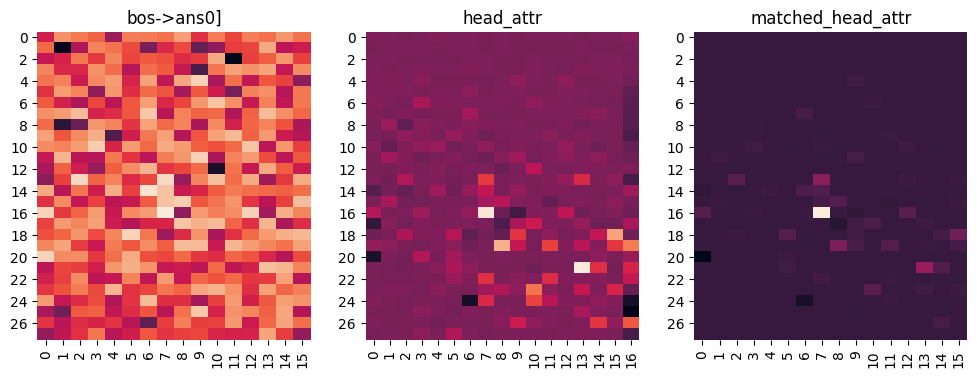

(array([16, 14, 13, 13, 16, 18, 20,  4, 16, 11]),
 array([ 7,  6,  7,  2,  0,  5,  0,  9, 12,  9]),
 array([-0.8131221, -1.1140809, -1.3658707, -1.4227219, -1.550431 ,
       -1.5607324, -1.5697958, -1.5797439, -1.6435707, -1.6617503],
      dtype=float32))
(array([21, 16, 19, 18, 19, 23, 26, 24, 19, 13]),
 array([13,  7,  8, 15, 16, 10, 16, 10, 11,  7]),
 array([0.75155824, 0.7355008 , 0.5843423 , 0.5458761 , 0.4470967 ,
       0.42752582, 0.36593425, 0.31886303, 0.31549644, 0.30079457],
      dtype=float32))
(array([16, 21, 13, 19, 18, 23, 13, 16, 18, 16]),
 array([ 7, 13,  7,  8, 15, 10,  2, 12,  5,  0]),
 array([0.32617354, 0.09005119, 0.07675026, 0.06296989, 0.05223418,
       0.0355777 , 0.03315381, 0.03299941, 0.02903952, 0.02850244],
      dtype=float32))
[0] top[0] 16-7 attn_labels


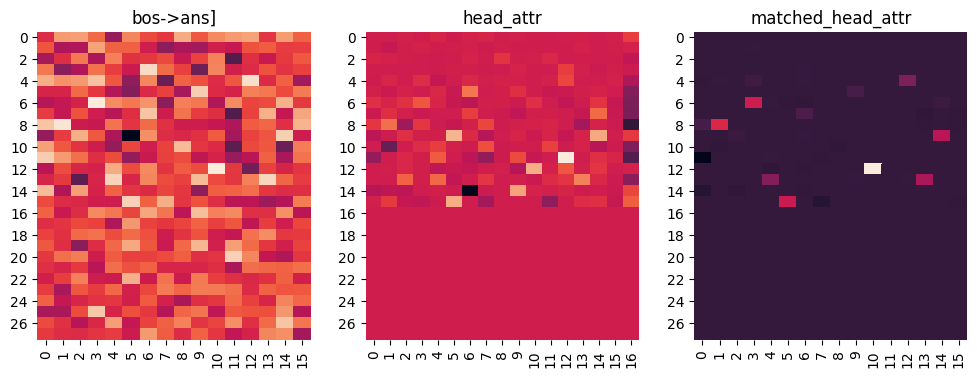

(array([ 6, 12,  8,  4,  3, 13, 13, 15, 20,  9]),
 array([ 3, 10,  1, 12,  6, 13,  4,  5, 11, 14]),
 array([-2.0432267, -2.0723977, -2.266554 , -2.484486 , -2.6210263,
       -2.802127 , -2.9011645, -2.9306583, -2.9438295, -3.0412364],
      dtype=float32))
(array([11,  9, 12, 15,  9, 14, 13,  5,  8,  7]),
 array([12,  5, 10,  5, 14,  9, 13,  6,  1, 14]),
 array([0.7693001 , 0.5414798 , 0.51048654, 0.5035944 , 0.49987787,
       0.47721595, 0.35205713, 0.31638402, 0.29327953, 0.2701404 ],
      dtype=float32))
(array([12,  8,  6, 15,  9, 13, 13,  4,  7,  8]),
 array([10,  1,  3,  5, 14, 13,  4, 12,  6,  0]),
 array([0.06426188, 0.03040393, 0.02753537, 0.02687275, 0.02388206,
       0.02136313, 0.01450619, 0.0135276 , 0.00445843, 0.00352038],
      dtype=float32))
[1] top[0, 1] 12-10,8-1


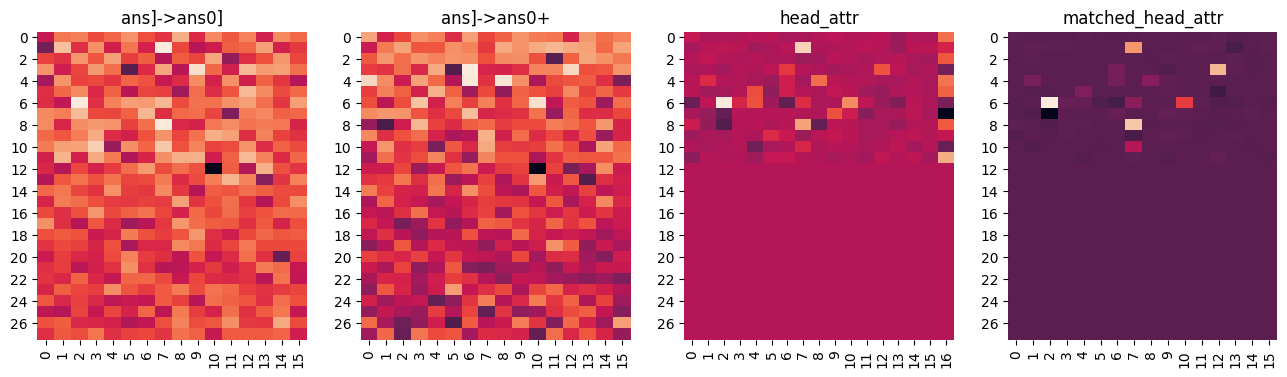

(array([ 1,  6,  8,  3, 10, 10,  1,  7, 11,  5]),
 array([ 7,  2,  7,  9,  3,  7,  1,  2, 12, 12]),
 array([-0.10544297, -0.12014531, -0.1850719 , -0.5820397 , -1.184849  ,
       -1.4089417 , -1.7394853 , -1.8467633 , -1.9650996 , -1.9652803 ],
      dtype=float32))
(array([3, 4, 4, 6, 3, 4, 6, 7, 8, 1]),
 array([ 6,  6,  8, 10, 12,  0,  3,  6,  3, 11]),
 array([-0.21864541, -0.33301038, -0.4052481 , -0.5228414 , -0.7983227 ,
       -0.841054  , -1.346777  , -1.532387  , -1.7368424 , -1.7376413 ],
      dtype=float32))
(array([ 6,  1, 11,  8,  6,  4,  0,  4,  5,  8]),
 array([ 2,  7, 16,  7, 10, 16, 16,  8, 16, 16]),
 array([0.6271033 , 0.5563282 , 0.44647613, 0.4140543 , 0.35706034,
       0.29953283, 0.2877331 , 0.2827124 , 0.25118467, 0.24094087],
      dtype=float32))
(array([ 6,  8,  3,  1,  6, 10,  6,  4,  5,  4]),
 array([ 2,  7, 12,  7, 10,  7,  7,  8,  4,  1]),
 array([0.06739227, 0.05882639, 0.05555389, 0.04800212, 0.03118702,
       0.01840849, 0.00964398, 0.00909121, 0.007

In [417]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [385]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0, 1] 12-10,8-1┐
                                                                     └*[2] top[0, 1, 2, 3, 4] 6-2,8-7,3-12,1-7,6-10...


Christopher is irresponsible. Morgan is poor. So Morgan's not rich
August is hot. Ruby is small. So August's not cold
Ryan is unconscious. Robin is quiet. So Ryan's not conscious
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...
[-1] root labels


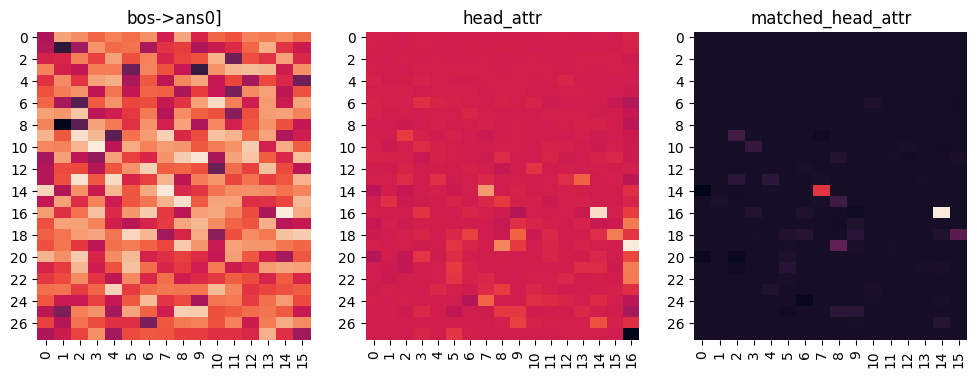

(array([10, 16, 14, 11, 13, 15,  9, 13,  6, 18]),
 array([ 3, 14,  7,  9,  2,  8,  2,  4, 10,  5]),
 array([-1.0614762, -1.0834801, -1.1901063, -1.2660172, -1.3361347,
       -1.4233662, -1.436903 , -1.563286 , -1.590735 , -1.712683 ],
      dtype=float32))
(array([19, 16, 14, 19, 21, 18, 22, 17, 24, 18]),
 array([16, 14,  7,  8, 16, 15, 16, 16,  7,  9]),
 array([0.9225615 , 0.85220003, 0.5222215 , 0.44205382, 0.4086256 ,
       0.3954818 , 0.39397603, 0.38965353, 0.2994766 , 0.2949795 ],
      dtype=float32))
(array([16, 14, 19, 18,  9, 15, 10, 13, 25, 13]),
 array([14,  7,  8, 15,  2,  8,  3,  4,  8,  2]),
 array([0.2883979 , 0.15885401, 0.05732693, 0.05438753, 0.03474189,
       0.03422713, 0.02544804, 0.01949975, 0.01885692, 0.01821908],
      dtype=float32))
[0] top[0] 16-14 attn_labels


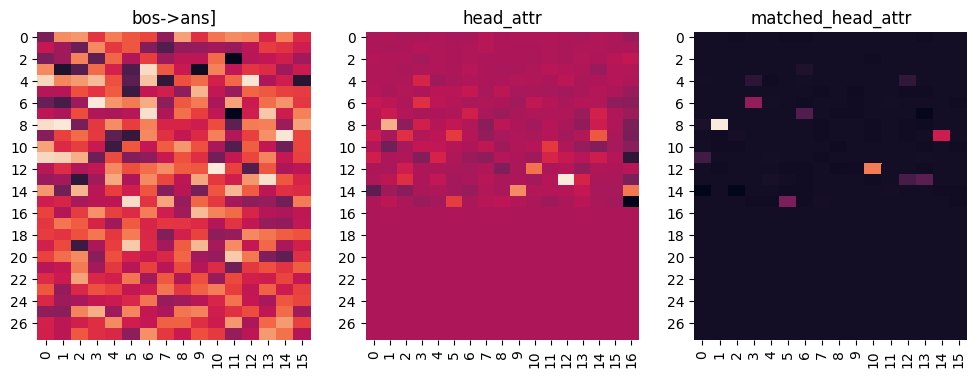

(array([12,  6,  8,  4,  9, 13,  7,  8, 15,  3]),
 array([10,  3,  1, 12, 14, 13,  6,  0,  5,  6]),
 array([-2.002304 , -2.0551844, -2.0881045, -2.1751802, -2.1937742,
       -2.2998815, -2.337555 , -2.3848898, -2.4324052, -2.4835942],
      dtype=float32))
(array([13,  8, 14, 14, 12,  9, 15,  9, 10,  9]),
 array([12,  1,  9, 16, 10, 14,  5,  5, 11,  2]),
 array([0.79002386, 0.57762516, 0.45729977, 0.40136495, 0.37706846,
       0.31034058, 0.22494863, 0.21906604, 0.21601075, 0.19114912],
      dtype=float32))
(array([ 8, 12,  9,  6, 15, 13,  7, 13, 11,  4]),
 array([ 1, 10, 14,  3,  5, 13,  6, 12,  0, 12]),
 array([0.07158036, 0.05091322, 0.03460147, 0.02411781, 0.01975619,
       0.01408757, 0.01208335, 0.01073118, 0.00910435, 0.00616032],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


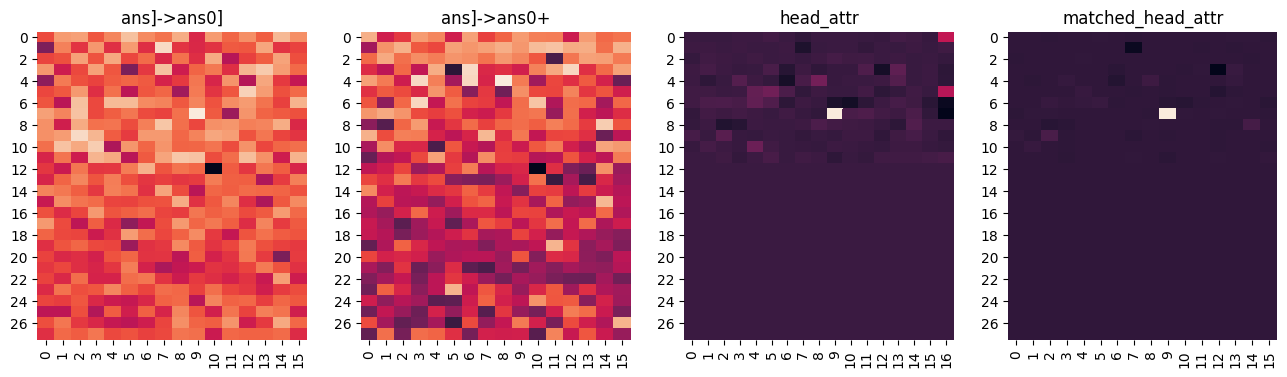

(array([ 7,  1,  9,  5, 10,  3, 11,  8, 10,  7]),
 array([ 9,  7,  2, 12,  3, 13,  8,  7,  1,  2]),
 array([-0.48755345, -1.1073177 , -1.1164478 , -1.4089204 , -1.5828502 ,
       -1.7160457 , -1.7882301 , -1.8945122 , -1.9793423 , -1.9846205 ],
      dtype=float32))
(array([4, 3, 4, 6, 3, 4, 8, 6, 1, 1]),
 array([ 8,  6,  3,  3, 12,  6, 14, 10, 11, 10]),
 array([-0.82827485, -1.2663082 , -1.30692   , -1.324405  , -1.331464  ,
       -1.3490177 , -1.6154763 , -1.8305976 , -1.8823582 , -2.0159717 ],
      dtype=float32))
(array([ 7,  0,  5,  4,  5, 10,  5,  6,  3,  9]),
 array([ 9, 16, 16,  8,  5,  4,  4,  4, 13,  2]),
 array([1.396103  , 0.53617567, 0.48715025, 0.23154691, 0.21675475,
       0.199749  , 0.16530544, 0.16239291, 0.14587918, 0.12329111],
      dtype=float32))
(array([ 7,  9,  8,  4,  3,  6,  6,  5, 10,  4]),
 array([ 9,  2, 14,  8, 13,  5,  2,  4,  1, 13]),
 array([0.16704938, 0.01277332, 0.01098615, 0.00688249, 0.00492415,
       0.00444001, 0.00388898, 0.00366408, 0.003

In [421]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [412]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)
                 ┌[0] top[0] 16-14 argmax_attn_labels┐
                 │                                   └[1] top[0, 1] 8-1,12-10┐
                 │                                                           └[2] top[0] 7-9
 [-1] root labels┤
                 └[0] top[0] 16-14 attn_labels┐
                                              └[1] top[0, 1] 8-1,12-10┐
                                                                      └*[2] top[0] 7-9...


### thing->type

In [315]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.032, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.117, 0.90625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.594, 0.65625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.354, 0.53125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.793, 0.625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.286, 0.8125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.174, 0.46875
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.824, 0.46875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=0): 0.048, 0.875
MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=1, abstract=1): 0.191, 0.90625
MlM_gen(persons

London has a burger. London's food
Jamie has a pizza. Jamie's food
Joy has a pistol. Joy's weapon
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[0, 1] 5-12,7-2...
[-1] root labels


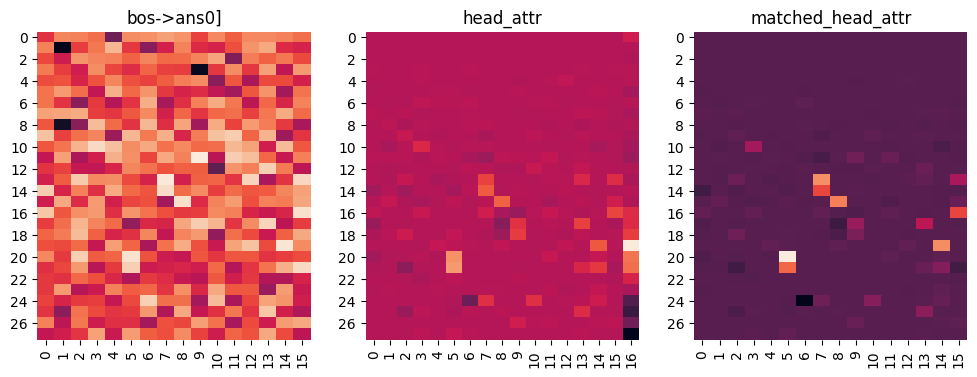

(array([11, 13, 19, 20, 16, 15, 14, 10, 21, 13]),
 array([ 9,  7, 14,  5, 15,  8,  7,  3, 15, 15]),
 array([-0.4349876, -0.5271155, -0.6725031, -0.7400898, -0.7721441,
       -0.7932828, -0.9576964, -1.026036 , -1.0345848, -1.0595406],
      dtype=float32))
(array([19, 21, 20, 20, 21, 15, 14, 19, 16, 13]),
 array([16,  5,  5, 16, 16,  8,  7, 14, 15,  7]),
 array([1.651996  , 1.029985  , 0.96665406, 0.78627765, 0.7544155 ,
       0.67617255, 0.62602866, 0.6084214 , 0.5003369 , 0.4799834 ],
      dtype=float32))
(array([20, 13, 19, 15, 21, 14, 16, 17, 13, 10]),
 array([ 5,  7, 14,  8,  5,  7, 15, 13, 15,  3]),
 array([1.3061308 , 0.9105848 , 0.9047116 , 0.85237265, 0.7648076 ,
       0.65368176, 0.64798385, 0.40298358, 0.3184108 , 0.2960562 ],
      dtype=float32))
[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels


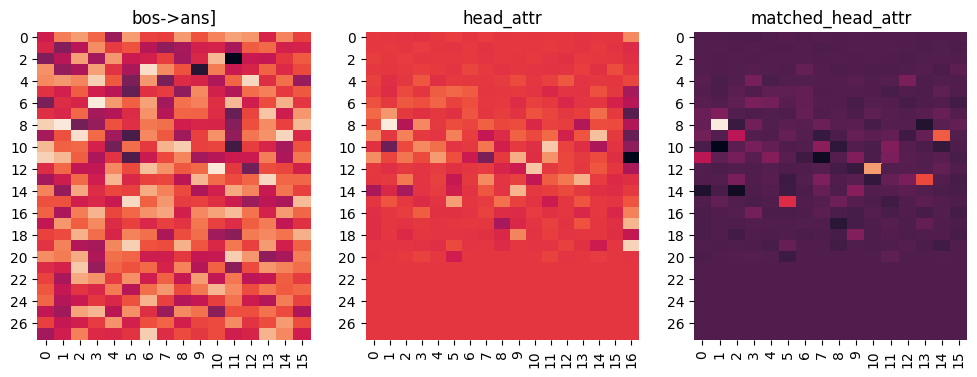

(array([ 6,  8, 12,  9,  3, 15, 13,  4,  9, 11]),
 array([ 3,  1, 10,  2,  6,  5, 13, 12, 14,  0]),
 array([-2.0047698, -2.0751946, -2.0947797, -2.3899155, -2.4032595,
       -2.5390391, -2.571194 , -2.5823462, -2.6415858, -2.7976642],
      dtype=float32))
(array([ 8, 19, 10, 12,  9, 14, 17, 13, 11, 15]),
 array([ 1, 16, 11, 10, 14,  9, 16, 13,  9,  5]),
 array([0.9747391 , 0.82241213, 0.7610413 , 0.7319919 , 0.7036818 ,
       0.64335304, 0.6406404 , 0.6252868 , 0.5944871 , 0.51662207],
      dtype=float32))
(array([ 8, 12,  9, 13, 15, 11,  9, 10, 14, 11]),
 array([ 1, 10, 14, 13,  5,  0,  2,  7,  9,  4]),
 array([0.46970972, 0.34943622, 0.26638612, 0.24318929, 0.20347148,
       0.15300176, 0.15045455, 0.08416142, 0.07752506, 0.07396084],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


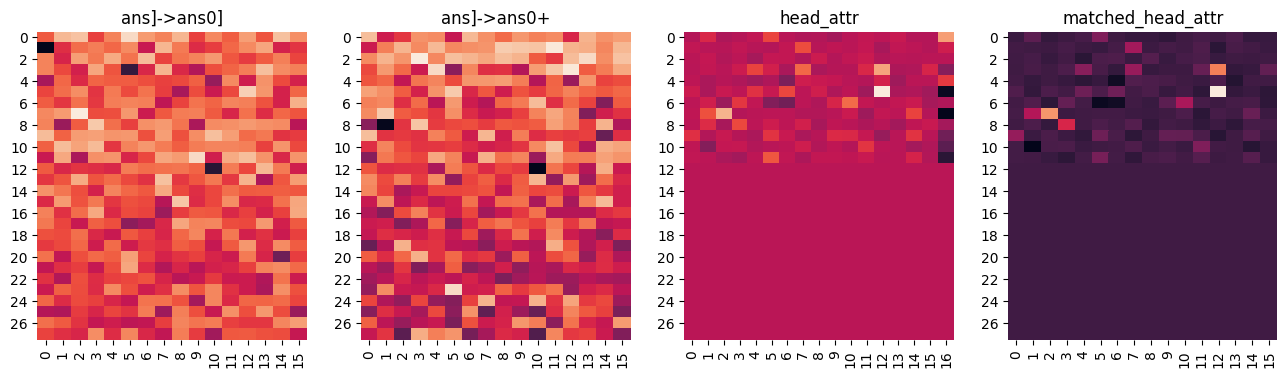

(array([ 7,  0, 11,  5,  8, 15,  0, 13,  0,  9]),
 array([ 2,  5,  9, 12,  3,  8,  2,  7, 14, 10]),
 array([-0.3700801 , -0.91300535, -0.93113196, -1.226944  , -1.4634625 ,
       -1.5716724 , -1.6603969 , -1.7137558 , -1.7353265 , -1.74996   ],
      dtype=float32))
(array([ 2,  1,  3, 23,  3,  2,  1,  7,  5,  1]),
 array([ 3, 11, 12,  5,  4, 13,  8,  1,  5,  9]),
 array([-0.34843445, -0.4046321 , -0.4277269 , -0.78305674, -0.78762954,
       -0.81143206, -1.1962155 , -1.2218091 , -1.2308171 , -1.3081578 ],
      dtype=float32))
(array([ 5,  7,  3,  0,  6,  3, 11,  7,  1,  8]),
 array([12,  2, 12, 16, 10,  7,  5,  1,  7,  3]),
 array([1.2855846 , 0.9356196 , 0.85248685, 0.8200028 , 0.5468836 ,
       0.5278702 , 0.44569322, 0.41489646, 0.39586794, 0.38460428],
      dtype=float32))
(array([5, 7, 3, 8, 7, 6, 1, 3, 9, 3]),
 array([12,  2, 12,  3,  1, 10,  7,  7,  0,  4]),
 array([0.61430156, 0.4553765 , 0.41683966, 0.2716534 , 0.20253491,
       0.18628792, 0.17362618, 0.15562657, 0.150

In [139]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [142]:
print(key); node = add_node_to_result(result, topi=[1, 2])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[1, 2] 7-2,3-12...


Bo has a bear. Carl has a pineapple. Bo's bear
Christopher has wine. Morgan has spaghetti. Morgan's spaghetti
August has black. Ruby has a lime. August's black
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0] 12-10
[-1] root labels


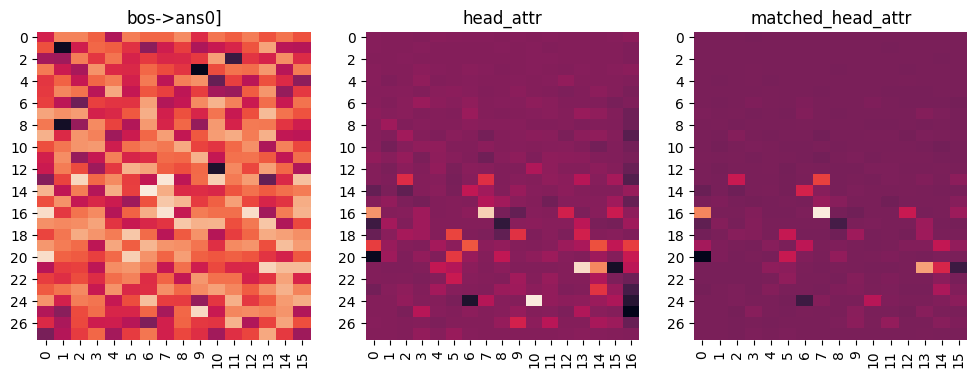

(array([14, 13, 16, 16, 20, 16, 25, 13, 21, 20]),
 array([ 6,  7,  7, 12,  0,  0,  9,  2, 13,  5]),
 array([-0.76847124, -0.91620743, -1.0253844 , -1.1890159 , -1.2004476 ,
       -1.2044504 , -1.3372848 , -1.4165361 , -1.4887413 , -1.6328306 ],
      dtype=float32))
(array([24, 21, 16, 16, 21, 19, 19, 18, 19, 19]),
 array([10, 13,  7,  0, 14,  6, 14,  5,  0, 16]),
 array([0.961745  , 0.89983845, 0.8550615 , 0.6408211 , 0.60438335,
       0.45135754, 0.433631  , 0.3990986 , 0.37840158, 0.37788907],
      dtype=float32))
(array([16, 21, 16, 13, 21, 14, 16, 13, 20, 18]),
 array([ 7, 13,  0,  7, 14,  6, 12,  2,  5,  5]),
 array([0.83389354, 0.604429  , 0.5320444 , 0.35702586, 0.27561784,
       0.26199418, 0.2219705 , 0.22174115, 0.22023506, 0.21290773],
      dtype=float32))
[0] top[0] 16-7 attn_labels


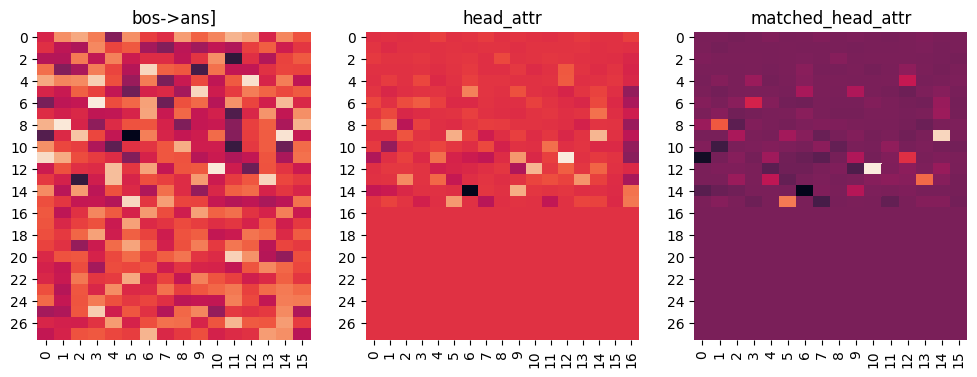

(array([ 6, 12,  8,  9,  4, 11, 15,  5,  3, 13]),
 array([ 3, 10,  1, 14, 12,  0,  5,  9,  6, 13]),
 array([-2.123184 , -2.2026026, -2.2260034, -2.3891857, -2.4952831,
       -2.658862 , -2.81563  , -2.8529582, -2.8708003, -2.9066348],
      dtype=float32))
(array([11, 12,  9,  9, 14, 15, 11, 13, 13,  5]),
 array([12, 10, 14,  5,  9,  5,  9, 13,  2,  6]),
 array([0.94266975, 0.6408508 , 0.6386491 , 0.59435934, 0.59105384,
       0.4876091 , 0.47970265, 0.4581871 , 0.40486157, 0.3693422 ],
      dtype=float32))
(array([12,  9, 15, 13,  8, 11,  6,  4, 13, 14]),
 array([10, 14,  5, 13,  1, 12,  3, 12,  4,  9]),
 array([0.2909516 , 0.26730826, 0.17317939, 0.1576349 , 0.14327697,
       0.10633796, 0.09084104, 0.07399539, 0.0668023 , 0.0574955 ],
      dtype=float32))
[1] top[0] 12-10


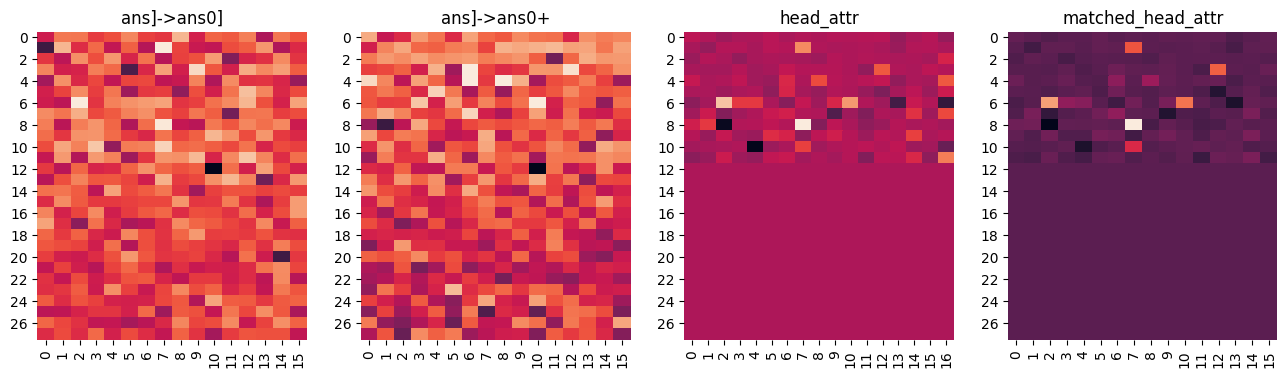

(array([ 1,  6,  8,  3, 10, 10, 11,  5, 11,  6]),
 array([ 7,  2,  7,  9,  7,  3, 12, 12,  9, 12]),
 array([-0.12368098, -0.13077638, -0.26115006, -0.78683645, -0.9868426 ,
       -1.4075432 , -1.4351188 , -1.6455195 , -1.8874338 , -1.9593313 ],
      dtype=float32))
(array([ 4,  6,  4,  3,  3,  4,  7,  5,  6, 23]),
 array([ 6, 10,  8,  6, 12,  0,  6,  4,  3,  5]),
 array([-0.31093156, -0.31979668, -0.3385723 , -0.34999603, -0.6376282 ,
       -0.84697556, -0.95705634, -1.0610068 , -1.3670614 , -1.6841705 ],
      dtype=float32))
(array([ 8,  6,  6,  1, 11,  4,  3,  4,  7, 10]),
 array([ 7,  2, 10,  7, 16, 16, 12,  8, 16,  7]),
 array([0.63601977, 0.5212428 , 0.40400568, 0.3651063 , 0.33129334,
       0.24795131, 0.24558514, 0.21417469, 0.21101579, 0.1912424 ],
      dtype=float32))
(array([ 8,  6,  6,  3,  1, 10,  4,  6,  7,  4]),
 array([ 7,  2, 10, 12,  7,  7,  8,  3,  6,  6]),
 array([0.29616523, 0.22044423, 0.18283053, 0.16659595, 0.15712117,
       0.11983133, 0.05907141, 0.04806

In [150]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


Alan has a blackberry. Jacob has an elephant. Alan's fruit
Morgan has a gun. Davis has a hamburger. Morgan's weapon
Austin has a deer. Thomas has meat. Thomas's food
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └*[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 ├[0] 11-9 attn_labels┐
                 │                    └[1] top[0] 8-1┐
                 │                                   └[2] top[0, 1] 3-12,7-2
                 └[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                                                                    └[1] top[0, 1] 8-1,12-10┐
                                                                                            └[2] top[0, 1, 3] 5-12,3-12,7-2
[-1] root labels


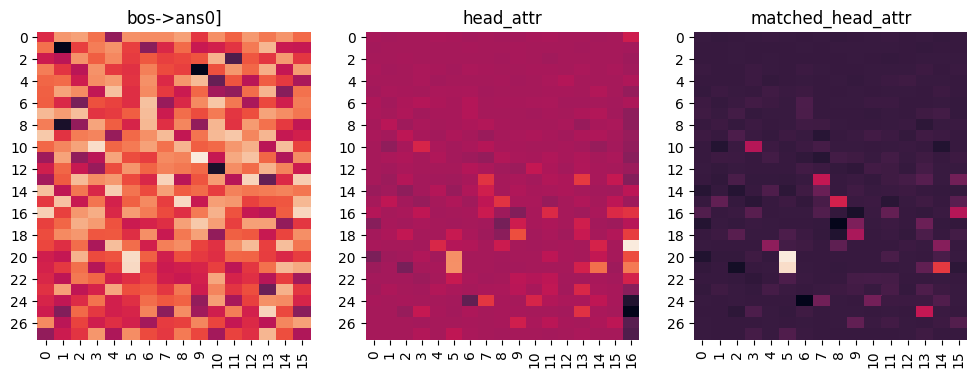

(array([11, 10, 20, 15, 21, 16, 13, 25, 13, 16]),
 array([ 9,  3,  5,  8,  5, 15, 12, 13,  7,  0]),
 array([-1.2674766, -1.6482041, -1.7172701, -1.7815722, -1.8076308,
       -1.8884598, -1.933879 , -1.9424105, -1.9547232, -2.0370746],
      dtype=float32))
(array([19, 21, 20, 21, 21, 18, 20, 18, 13, 24]),
 array([16,  5,  5, 16, 14,  9, 16, 16, 13,  7]),
 array([1.1065601 , 0.6738789 , 0.6702883 , 0.58036315, 0.5375647 ,
       0.41118476, 0.4067158 , 0.34230423, 0.32954222, 0.3187341 ],
      dtype=float32))
(array([20, 21, 21, 15, 13, 25, 10, 16, 18, 19]),
 array([ 5,  5, 14,  8,  7, 13,  3, 15,  9,  4]),
 array([0.390322  , 0.37279677, 0.20106155, 0.17056097, 0.1526186 ,
       0.15236934, 0.13750218, 0.13642497, 0.12428343, 0.09571555],
      dtype=float32))
[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels


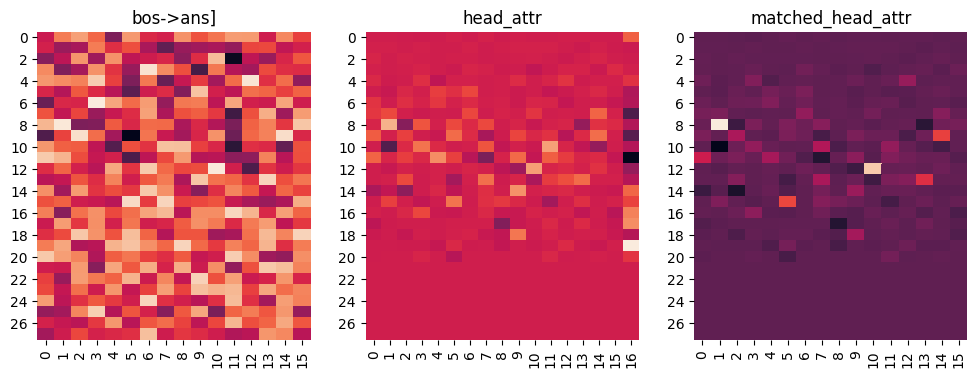

(array([ 6, 12,  8,  4,  3,  9,  9, 15, 16, 24]),
 array([ 3, 10,  1, 12,  6,  2, 14,  5, 11,  6]),
 array([-2.1202505, -2.1813905, -2.2281203, -2.3211892, -2.4319775,
       -2.5134633, -2.528109 , -2.6391044, -2.7577412, -2.7972775],
      dtype=float32))
(array([19,  8, 10, 12, 14, 17, 11, 16, 18, 15]),
 array([16,  1, 11, 10,  9, 16,  4, 16,  9,  5]),
 array([0.6698531 , 0.45983768, 0.40328616, 0.39848846, 0.35765412,
       0.3453579 , 0.34316713, 0.30421916, 0.27467614, 0.26424968],
      dtype=float32))
(array([ 8, 12, 15,  9, 13, 11, 10,  9, 13, 11]),
 array([ 1, 10,  5, 14, 13,  0,  7,  2,  7,  4]),
 array([0.20637919, 0.18267635, 0.10012855, 0.09701532, 0.08507187,
       0.07069803, 0.05257459, 0.04743757, 0.04717468, 0.04504041],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


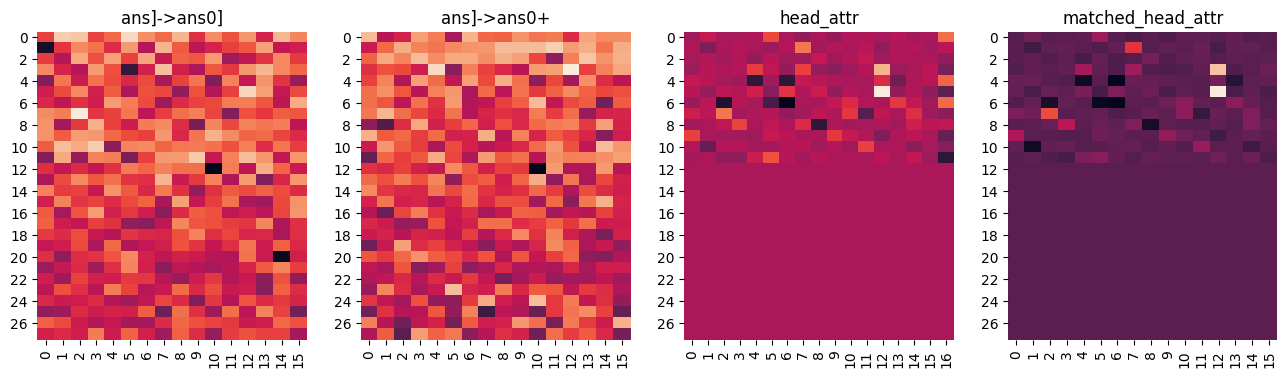

(array([ 7,  0,  5,  0, 10, 11,  0,  3, 10, 11]),
 array([ 2,  5, 12,  1,  3,  9,  2,  7,  1, 12]),
 array([-0.8029821, -1.3519015, -1.4143901, -1.6527418, -1.654027 ,
       -1.7690463, -1.8784103, -2.040913 , -2.0806189, -2.134634 ],
      dtype=float32))
(array([ 3,  3,  1,  2, 24, 23,  1,  2, 10,  1]),
 array([12,  4, 11, 13, 10,  5,  8,  3, 14,  9]),
 array([-0.7665804, -1.2390473, -1.479734 , -1.749217 , -1.8781241,
       -1.8878758, -1.9278226, -1.9299415, -1.9315186, -1.9402082],
      dtype=float32))
(array([ 5,  3,  7,  1,  0,  6,  4, 11,  0,  8]),
 array([12, 12,  2,  7, 16, 16, 16,  5,  5,  3]),
 array([0.86935115, 0.65089214, 0.43882847, 0.4347899 , 0.40814888,
       0.39541632, 0.37949353, 0.32751548, 0.29330683, 0.28055373],
      dtype=float32))
(array([ 5,  3,  7,  1,  8,  9,  3,  3,  0, 10]),
 array([12, 12,  2,  7,  3,  0,  4,  7,  5, 11]),
 array([0.38553452, 0.33191723, 0.19622234, 0.1699038 , 0.11536194,
       0.09843516, 0.08393712, 0.08256423, 0.07644407, 0.0

In [205]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])